# Asset Clustering using Graph based Approach

## Content
1. Introduction
2. Dataset
3. Cluster Analysis and visulation tools
4. Training and Inference
5. Conclusion

### 1. Introduction

In this tutorial, we use sflow data to come up with a graph representation where each node in the graph is an asset. Since sflow data is directional, we use `source` as the target asset. The feature matrix for this asset is created using derived and aggregated features from sflow data and armis data. The adjacency matrix is derived using the graph representation of the devices from sflow data. Each row in the resulting dataset is an asset and can be uniquely identified by the mac address.

The model uses a graph clustering approach proposed in this __[**paper**](https://ieeexplore.ieee.org/document/9741755)__ which assigns each host present in the dataset to a cluster based on 
1. Aggregated and derived features from sflow Logs of that particular host
2. The host connectivity to adjacent assets in the graphical representation (derived from sflow logs)

### 2. Dataset
Simulated sample cumulus and arista sflow data from ~3000 internal Armis device and application data. All data are processed using `faker` to remove any identity information. 

In [1]:
%load_ext autoreload
%autoreload 2
from data_loader import *
from model import EGAE, GAE
import torch
import warnings
import numpy as np
import os
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pacmap
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import networkx as nx
from pyvis.network import Network

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
%matplotlib inline

#### Load sflow network data

In [2]:
name = 'sflow'
data_path = "../dataset"
features, adjacency, feat_df, mac_dict, sflow_raw, G, adj_raw = load_data(name, data_path)

Loading from raw data file...
(19998, 17)
unique source mac : 763
unique dest mac : 169
Calculating adjacency matrix
[(0, ['19:12:53:98:9a:d0', '31:d3:22:98:b8:d9']), (1, ['6f:6f:13:9a:0b:6f']), (2, ['3b:44:19:f7:0a:a9']), (3, ['19:12:53:98:9a:d0']), (4, ['3b:44:19:f7:0a:a9'])]
[(0, [179, 129]), (1, [644]), (2, [101]), (3, [179]), (4, [101])]
adj type : <class 'scipy.sparse._arrays.csr_array'>


#### Read ARMIS enrichment data for the sflow

In [3]:

armis_data_device = pd.read_csv(os.path.join(data_path, 'armis_enrichment_device_v3.csv'))
armis_data_device['mac_address'] = armis_data_device['mac_address'].str.lower()
armis_data_device['mac_address'] = armis_data_device['mac_address'].str.replace(" ", "")

armis_data_app = pd.read_csv(os.path.join(data_path,'armis_enrichment_app_v3.csv'))
armis_data_app['mac_address'] = armis_data_app['mac_address'].str.lower()

### 3. Analyze Cluster

Here we define some python functions that help us understand and visaulize the asset clusters. These functions can be used to visualize and compare clusters formed by different parameter settings.
We generate the following visualizations:

1. Silhouette plot:  A silhouette plot is a graphical representation that provides insight into the quality and separation of clusters in a clustering solution. It helps to assess how well individual data points are clustered and separated from other clusters. The silhouette plot is particularly useful for evaluating the appropriateness of a clustering algorithm, the number of clusters to use, and the overall structure of the clusters. A higher silhouette score indicates that the data points within a cluster are closer to each other and farther away from data points in other clusters. This suggests better-defined clusters.
By comparing silhouette scores for different numbers of clusters, you can identify the number of clusters that results in the highest average silhouette score. This helps in avoiding both under-clustering and over-clustering scenarios.

2. Cardinality, Magnitude and Cardinality vs Magnitude: This function enables us to compare clusters based on their sizes (cardinality) and average magnitudes, providing insights into the distribution of data points and their overall "size" within each cluster. 

3. PCA and PACMAP plot: These techniques help us overcome the limitations of visualizing data in more than three dimensions, making complex relationships and patterns within clusters more accessible.

4. Feature distributions per cluster: This per feature plot helps us understand how a feature is distributed across different clusters.

5. Comparison of the mean per cluster to overall mean in percent : Compares the deviation in mean value of a feature in a cluster to its overall mean in percentage. 

6. Radial Cluster chacrteristics (Feature means per cluster) : A radial feature mean per cluster plot is a visualization technique that provides a comprehensive view of how individual features vary across different clusters. This type of plot is particularly useful when we want to understand how clusters are differentiated not only in terms of their overall characteristics but also in terms of the specific attributes or features that define them. Different clusters might be defined by their unique feature patterns. A radial plot allows us to see how each feature contributes to the separation of clusters. It highlights which features have the most variation across clusters and could be important for cluster characterization


First, we define a Class 'radial' which will later help us plot the radial cluster chacraetistics plot.

In [4]:
class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

Next, we define functions that facilitate the plotting of aforemntioned visualisations for cluster intrepratability. 

In [5]:

# Cluster analysis and plotting libraries
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 5
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:feat_df.cluster.nunique()],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:3]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:feat_df.cluster.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 0.98)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


def analyze_cluster(alpha, predictions, km, X):
    print('========== reg={} =========='.format(alpha))
    cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
    feat_df['cluster'] = predictions
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

    plot_cluster_cardinality(km.labels_,
                             ax=ax1,
                             title="Cardinality",
                             color=cluster_colors
                            )

    plot_cluster_magnitude(X,
                           km.labels_,
                           km.cluster_centers_,
                           euclidean,
                           ax=ax2,
                           title="Magnitude",
                           color=cluster_colors
                          )

    plot_magnitude_vs_cardinality(X,
                                  km.labels_,
                                  km.cluster_centers_,
                                  euclidean,
                                  color=cluster_colors[0:km.n_clusters],
                                  ax=ax3, 
                                  title="Magnitude vs. Cardinality")

    fig.autofmt_xdate(rotation=0)
    plt.tight_layout()
    plt.show()
    
    

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

    # PCA
    pca_scaled_std = PCA(n_components=2,random_state=42)
    X_std_pca = pca_scaled_std.fit_transform(X)

    for l, c, m in zip(range(0, 5), cluster_colors[0:km.n_clusters], ('^', 's', 'o', '+', '*')):
        ax1.scatter(X_std_pca[predictions == l, 0],
                    X_std_pca[predictions == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    # PACMAP
    embedding = pacmap.PaCMAP(random_state=42)
    X_std_pacmap = embedding.fit_transform(X)

    for l, c, m in zip(range(0, 5), cluster_colors[0:km.n_clusters], ('^', 's', 'o', '+', '*')):
        ax2.scatter(X_std_pacmap[predictions == l, 0],
                    X_std_pacmap[predictions == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    ax1.set_title("PCA Visualization")
    ax2.set_title("PACMAP Visualization")

    labels = np.unique(km.labels_)
    labels = ["cluster "+str(l) for l in labels]
    fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
    plt.tight_layout()
    plt.show()
    
    features = feat_df.columns.tolist()[2:-1]
    ncols = 4
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    fig = plt.figure(figsize=(15,15))

    for n, feature in enumerate(features):
        ax = plt.subplot(nrows, ncols, n + 1)
        box = feat_df[[feature, 'cluster']].boxplot(by='cluster',ax=ax,return_type='both',patch_artist = True)

        for row_key, (ax,row) in box.iteritems():
            ax.set_xlabel('cluster')
            ax.set_title(feature,fontweight="bold")
            for i,box in enumerate(row['boxes']):
                box.set_facecolor(cluster_colors[i])

    fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
    plt.tight_layout()
    plt.show()
    
    # Merge feature dataframe with armis device data
    feat_df_2 = pd.merge(left=feat_df, right=armis_data_device, left_on=['raw_mac'], right_on=['mac_address'], how='left')
    assert feat_df.shape[0]==feat_df_2.shape[0], "shape incorrect"

    # Merge feature-armis device dataframe with armis app data
    feat_df_3 = pd.merge(left=feat_df_2, right=armis_data_app, left_on=['raw_mac'], right_on=['mac_address'], how='left')
    assert feat_df_3.shape[0]==feat_df_2.shape[0], "shape incorrect"

    # Drop duplicate mac address columns as a result of merge
    feat_df_3.drop(columns=['mac_address_x','mac_address_y'], inplace=True)
    
    # Display category (armis) distributions per cluster
    print(pd.DataFrame(feat_df_3[['cluster','category']].groupby(['cluster','category']).size()*100 / (feat_df_3[['cluster']].groupby(['cluster']).size())))
    
    # Display mtype (armis) distributions per cluster
    print(pd.DataFrame(feat_df_3[['cluster','mtype']].groupby(['cluster','mtype']).size()*100 / (feat_df_3[['cluster']].groupby(['cluster']).size())))
    
    # Comparison of mean per cluster to overall mean in percent
    X_new = feat_df.iloc[:,2:]
    X_mean = pd.concat([pd.DataFrame(X_new.mean().drop('cluster'), columns=['mean']), 
                       X_new.groupby('cluster').mean().T], axis=1)

    X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_dev_rel.drop(columns=['mean'], inplace=True)
    X_mean.drop(columns=['mean'], inplace=True)
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(feat_df.iloc[:,2:-1])
    X_std = pd.DataFrame(X_std, columns=feat_df.iloc[:,2:-1].columns)
    X_std['cluster'] = feat_df['cluster']
    X_std.insert(loc=0, column='raw_mac', value=feat_df['raw_mac'])
    X_std.insert(loc=1, column='mac_id', value=feat_df['mac_id'])
    
    X_std_new =  X_std.iloc[:,2:]
    X_std_mean = pd.concat([pd.DataFrame(X_std_new.mean().drop('cluster'), columns=['mean']), 
                       X_std_new.groupby('cluster').mean().T], axis=1)

    X_std_dev_rel = X_std_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_std_dev_rel.drop(columns=['mean'], inplace=True)
    X_std_mean.drop(columns=['mean'], inplace=True)
    
    cluster_comparison_bar(X_dev_rel, cluster_colors, title="Comparison of the mean per cluster to overall mean in percent")
    
    # Radial Comparison plot
    fig = plt.figure(figsize=(8, 8))
    features = feat_df.columns.tolist()[2:-1]
    no_features = len(features)
    radar = Radar(fig, features, np.unique(km.labels_))

    for k in range(0,km.n_clusters):
        cluster_data = X_std_mean[k].values.tolist()
        radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

    radar.ax.legend()
    radar.ax.set_title("Cluster characteristics: Feature means per cluster", size=22, pad=60)
    plt.show()
    


### 4. Training and Inference

##### Model archictecture
The model architecture was proposed in the EGAE paper [1]. Inputs of EGAE consist of two parts, graph and features. After encoding, data are mapped into a latent feature space as part of the encoder module. There are two decoder modules: 
1. Decoder for clustering: Relaxed k-means is embedded into GAE to induce it to generate preferable embeddings. 
2. Decoder for Graph : Optimize (minimize) reconstruction error


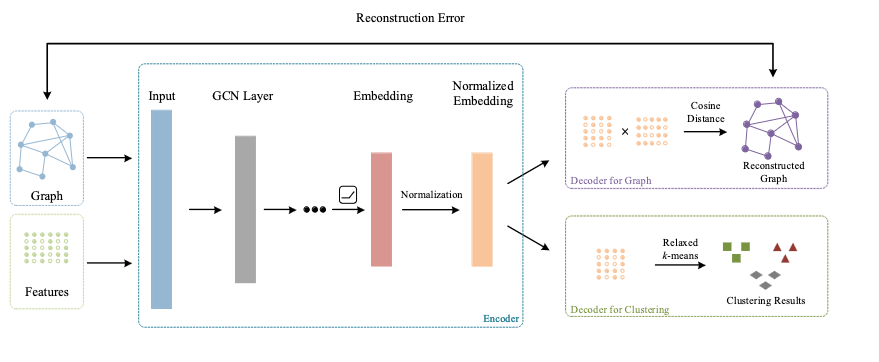

Fig 1. Illustration of EGAE. Inputs of EGAE consist of two parts, graph and features. After encoding, data is mapped into a latent feature space which employs inner-products as metrics [1]

##### Training
Train EGAE model using features and adjacency matrix.

In [6]:
# Parameters
max_epoch = 10 # suggested 50
layers = [256, 128]
acts = [torch.nn.functional.relu] * len(layers)
learning_rate = 10**-4*4
pretrain_learning_rate = 0.001
results_dict = {}

#### We test out the cluster characteristics for different regularisation coefficient and alpha values.

1. Regularisation Coefficient: The regularisation coefficient is a hyperparameter that controls the strength of the regularisation applied to the learned node representations. Regularisation is a technique used in machine learning to prevent overfitting, where the model learns to fit noise in the training data rather than the underlying patterns. By introducing regularization, we can encourage the model to produce simpler and more generalizable representations.
In the case of graph autoencoders, the regularization coefficient determines the importance of the graph regularization term in the loss function. The graph regularization term ensures that the learned node representations adhere to the structure of the graph, encouraging similar representations for nodes that are connected in the graph. This helps in capturing the relationships and patterns present in the graph.

2. Alpha : The alpha parameter typically refers to the balance between two components in the loss function used during training. Graph autoencoders are designed to learn representations of nodes in a graph such that they capture the graph structure and the underlying features of the nodes. The loss function guides the learning process by quantifying how well the autoencoder is reconstructing the input data while preserving the graph topology.

In [7]:

def main_s():

    i = 0
    for coeff_reg in [0.001]:
        for alpha in [0.01, 0.1, 1, 10, 100]:
            print('========== alpha={}, reg={} =========='.format(alpha, coeff_reg))
            gae = EGAE(features, adjacency, 5, alpha, layers=layers, acts=acts,
                       max_epoch=max_epoch, max_iter=4, coeff_reg=coeff_reg, learning_rate=learning_rate)
            gae.pretrain(10, learning_rate=pretrain_learning_rate)
            losses, predictions, km, X = gae.run()
    
            analyze_cluster(alpha, predictions, km, X)
            results_dict[alpha] = {
                'predictions': predictions,
                'km': km,
                'X': X
            }
            i += 1 
            
    
    return results_dict


========== alpha=0.01, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.542758464813232
loss: 4.9466
loss: 4.5276
loss: 4.5488
loss: 4.6733
loss: 4.6153
loss: 4.5454
loss: 4.4489
loss: 4.3051
loss: 4.1162


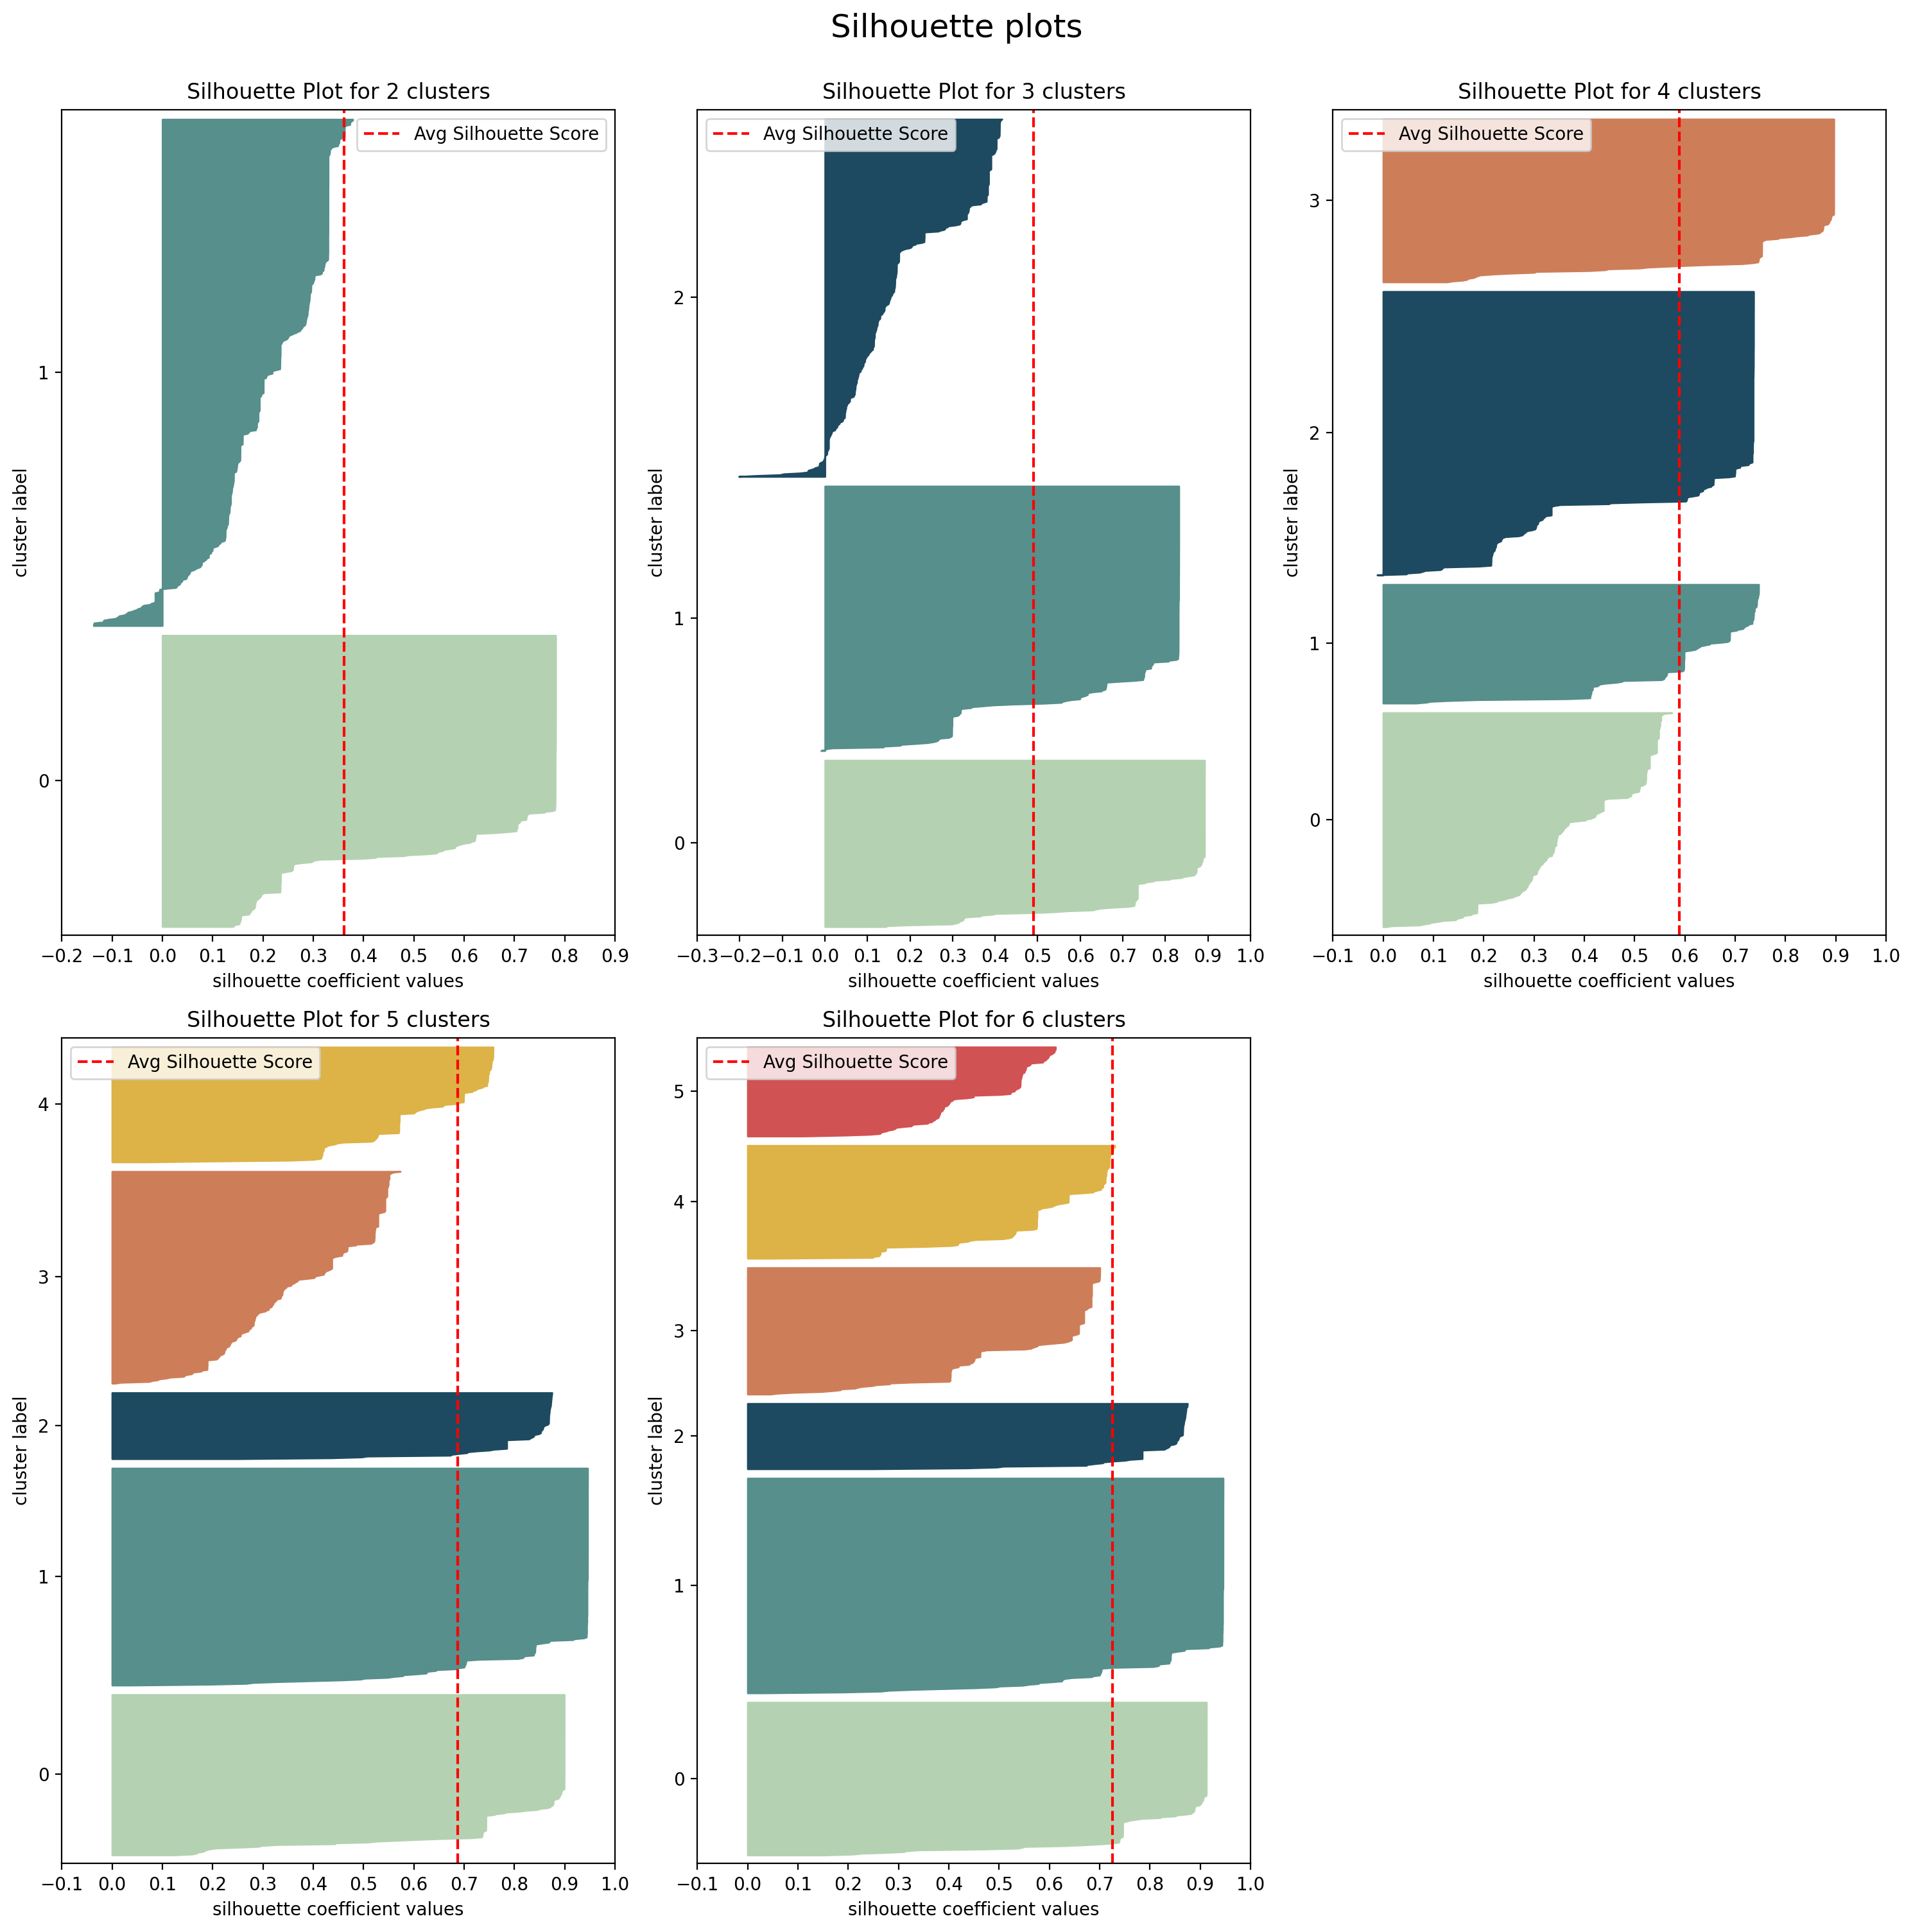

loss: 3.9086
========== reg=0.01 ==========


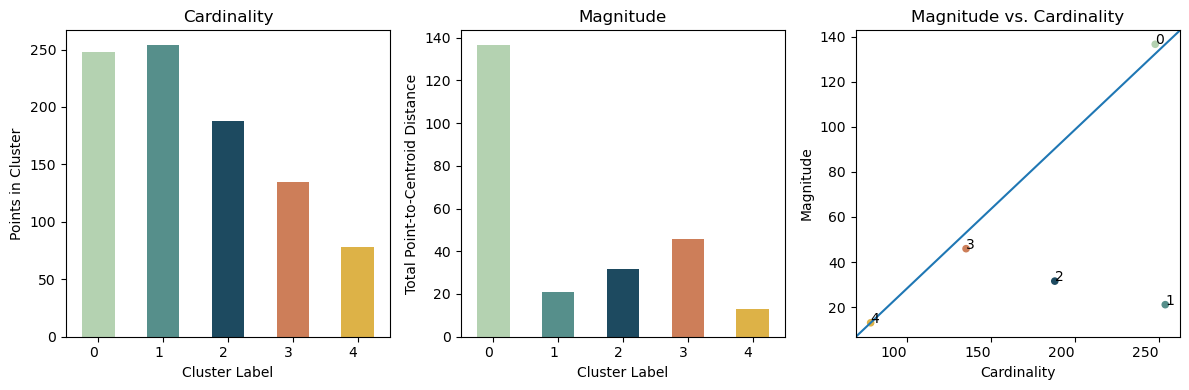

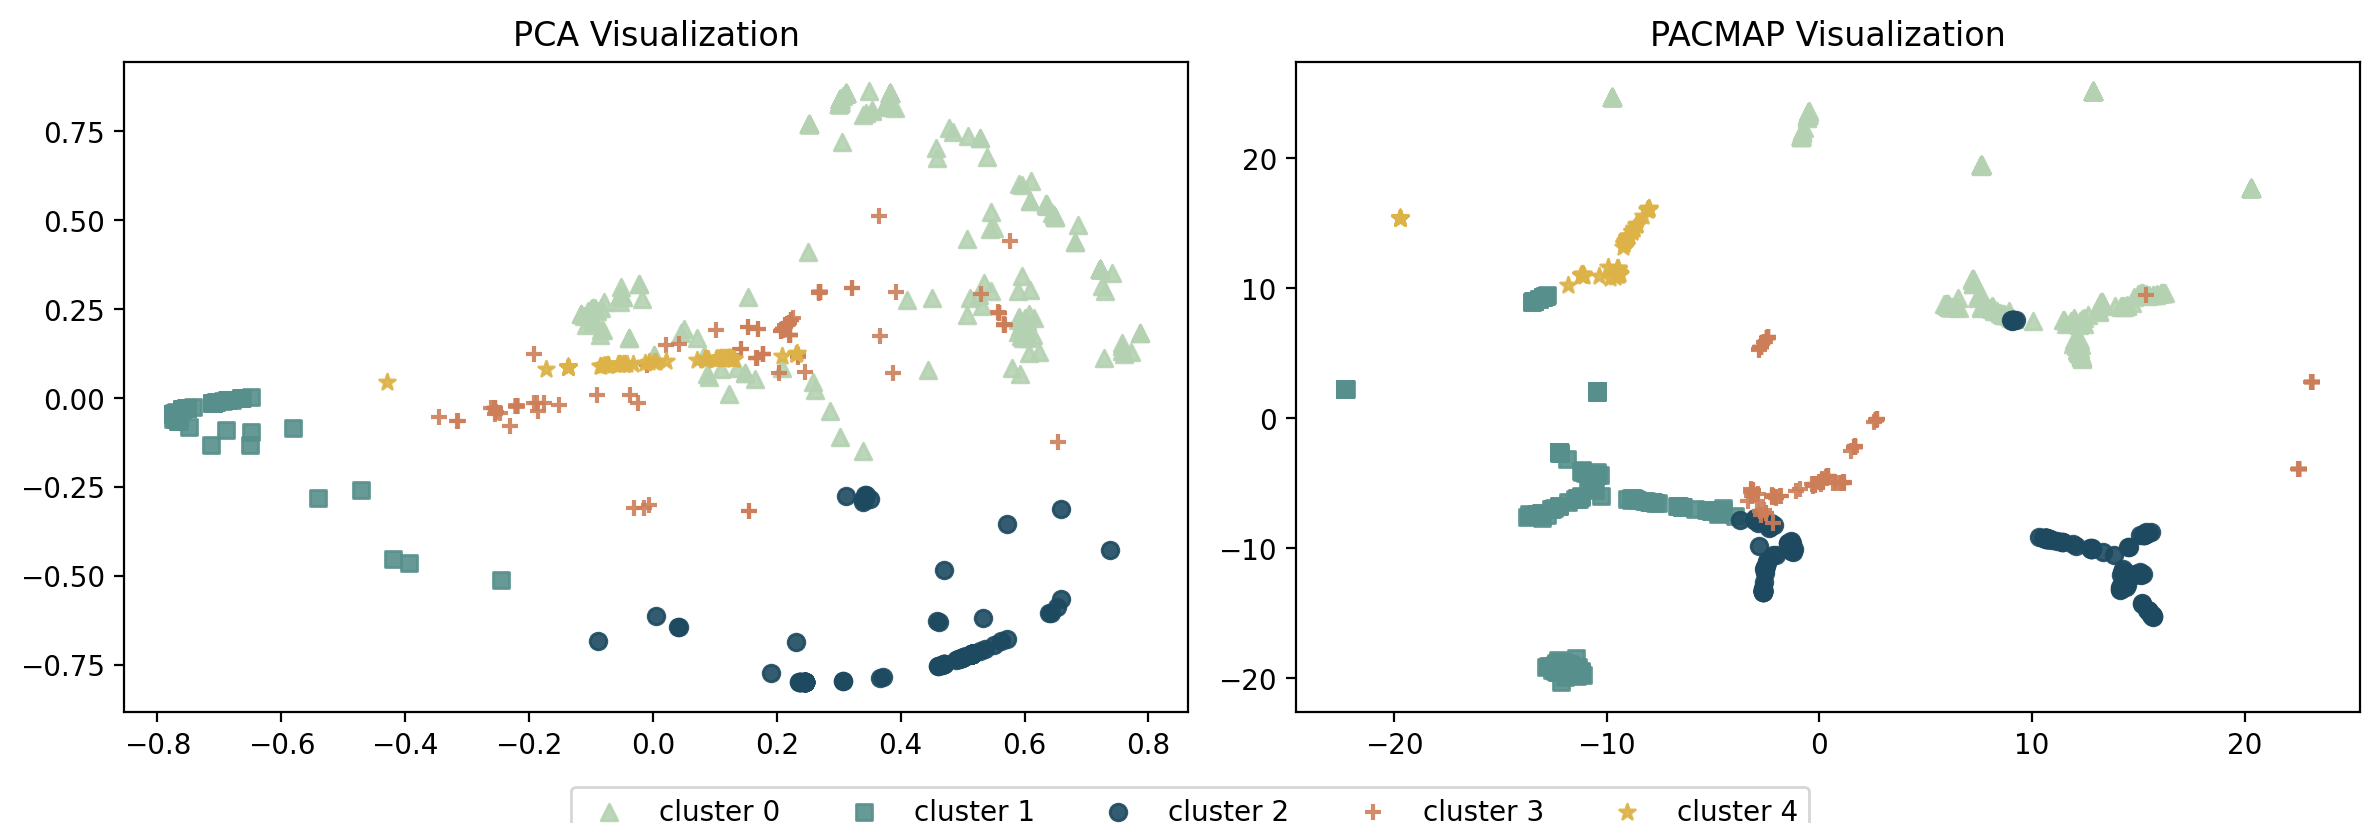

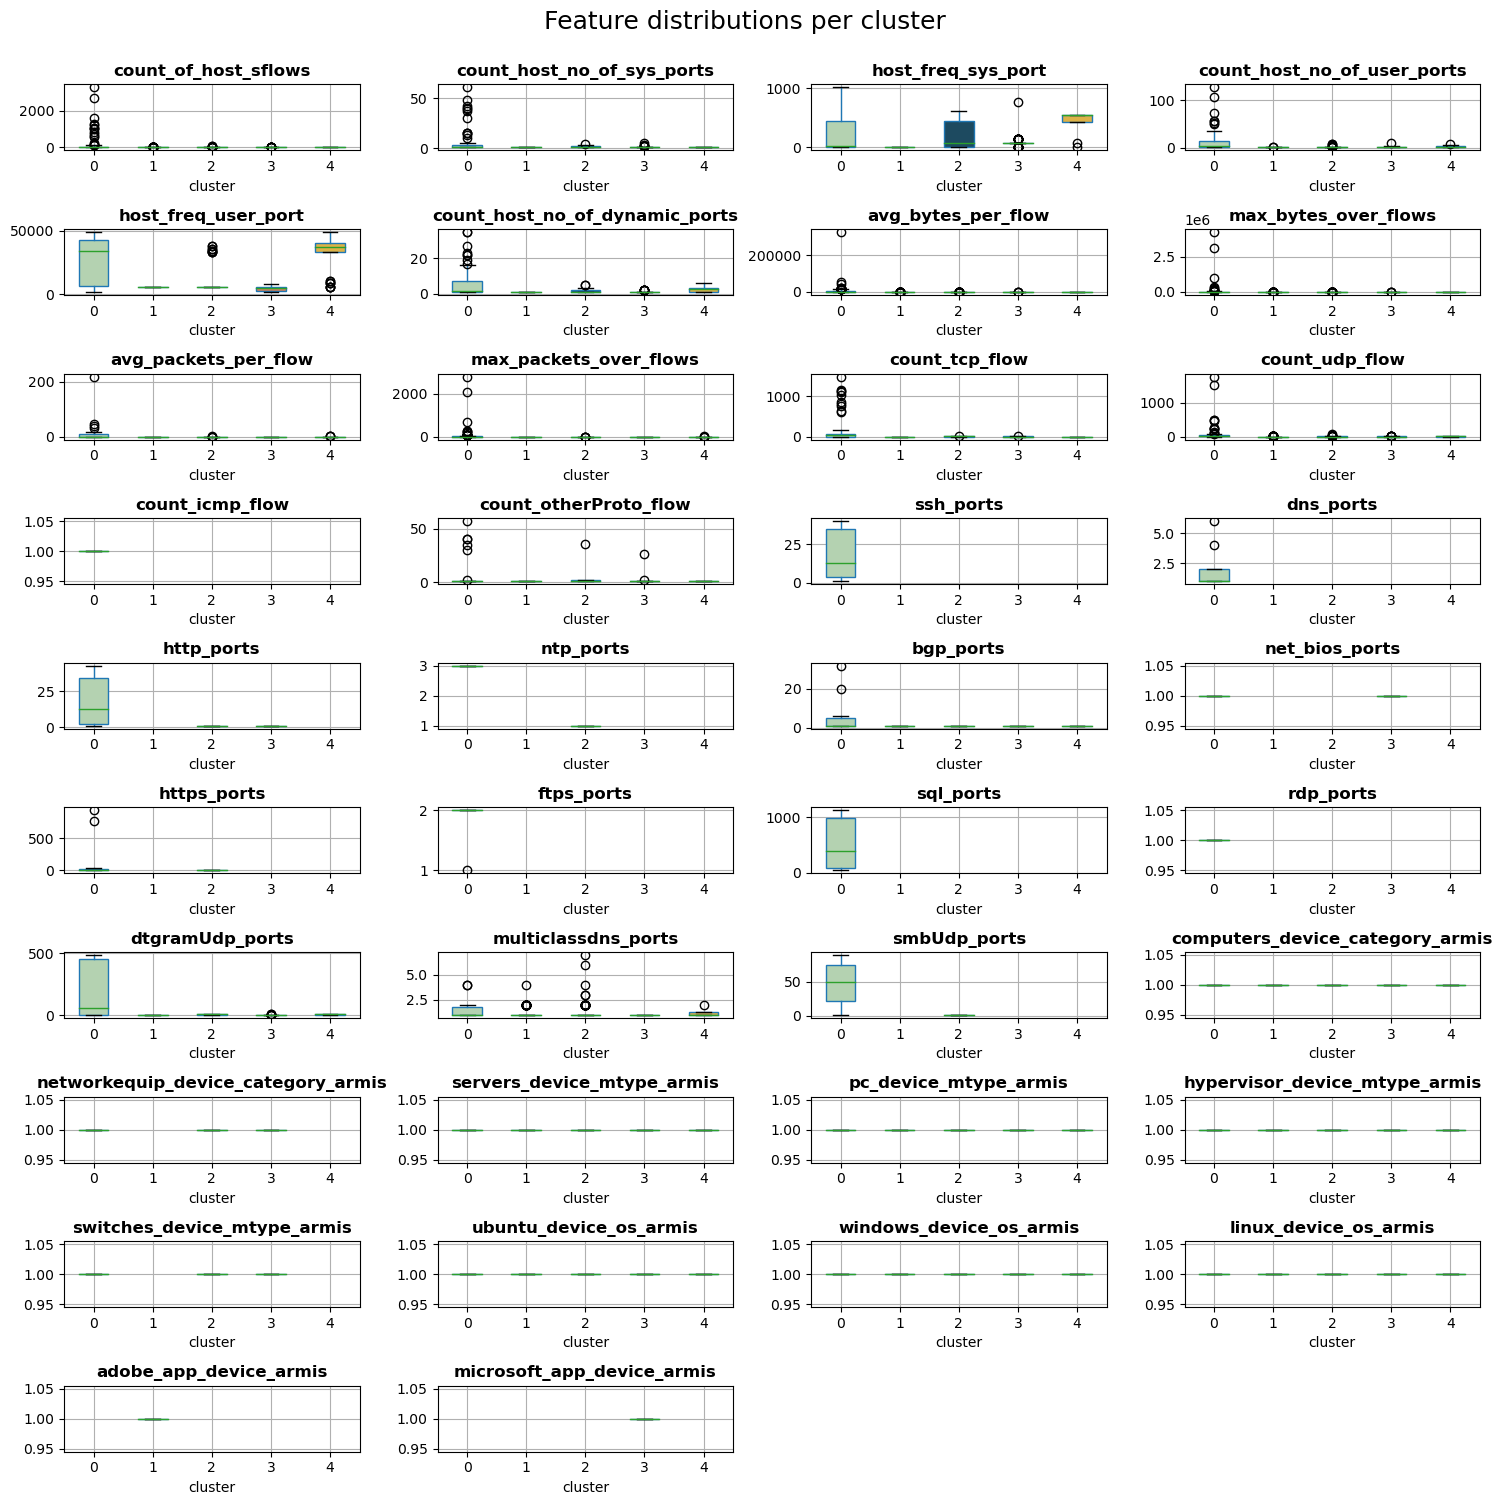

                                   0
cluster category                    
0       Computers          19.354839
        Network Equipment   4.838710
1       Computers          66.535433
2       Computers          51.063830
        Network Equipment   0.531915
3       Computers          36.296296
        Network Equipment   0.740741
4       Computers          32.051282
                                    0
cluster mtype                        
0       Hypervisor           1.612903
        Personal Computers   2.822581
        Servers             14.919355
        Switches             4.032258
1       Hypervisor           1.574803
        Personal Computers   3.937008
        Servers             58.661417
2       Hypervisor           1.595745
        Personal Computers   2.659574
        Servers             40.425532
        Switches             0.531915
3       Hypervisor           2.222222
        Personal Computers   4.444444
        Servers             29.629630
        Switches      

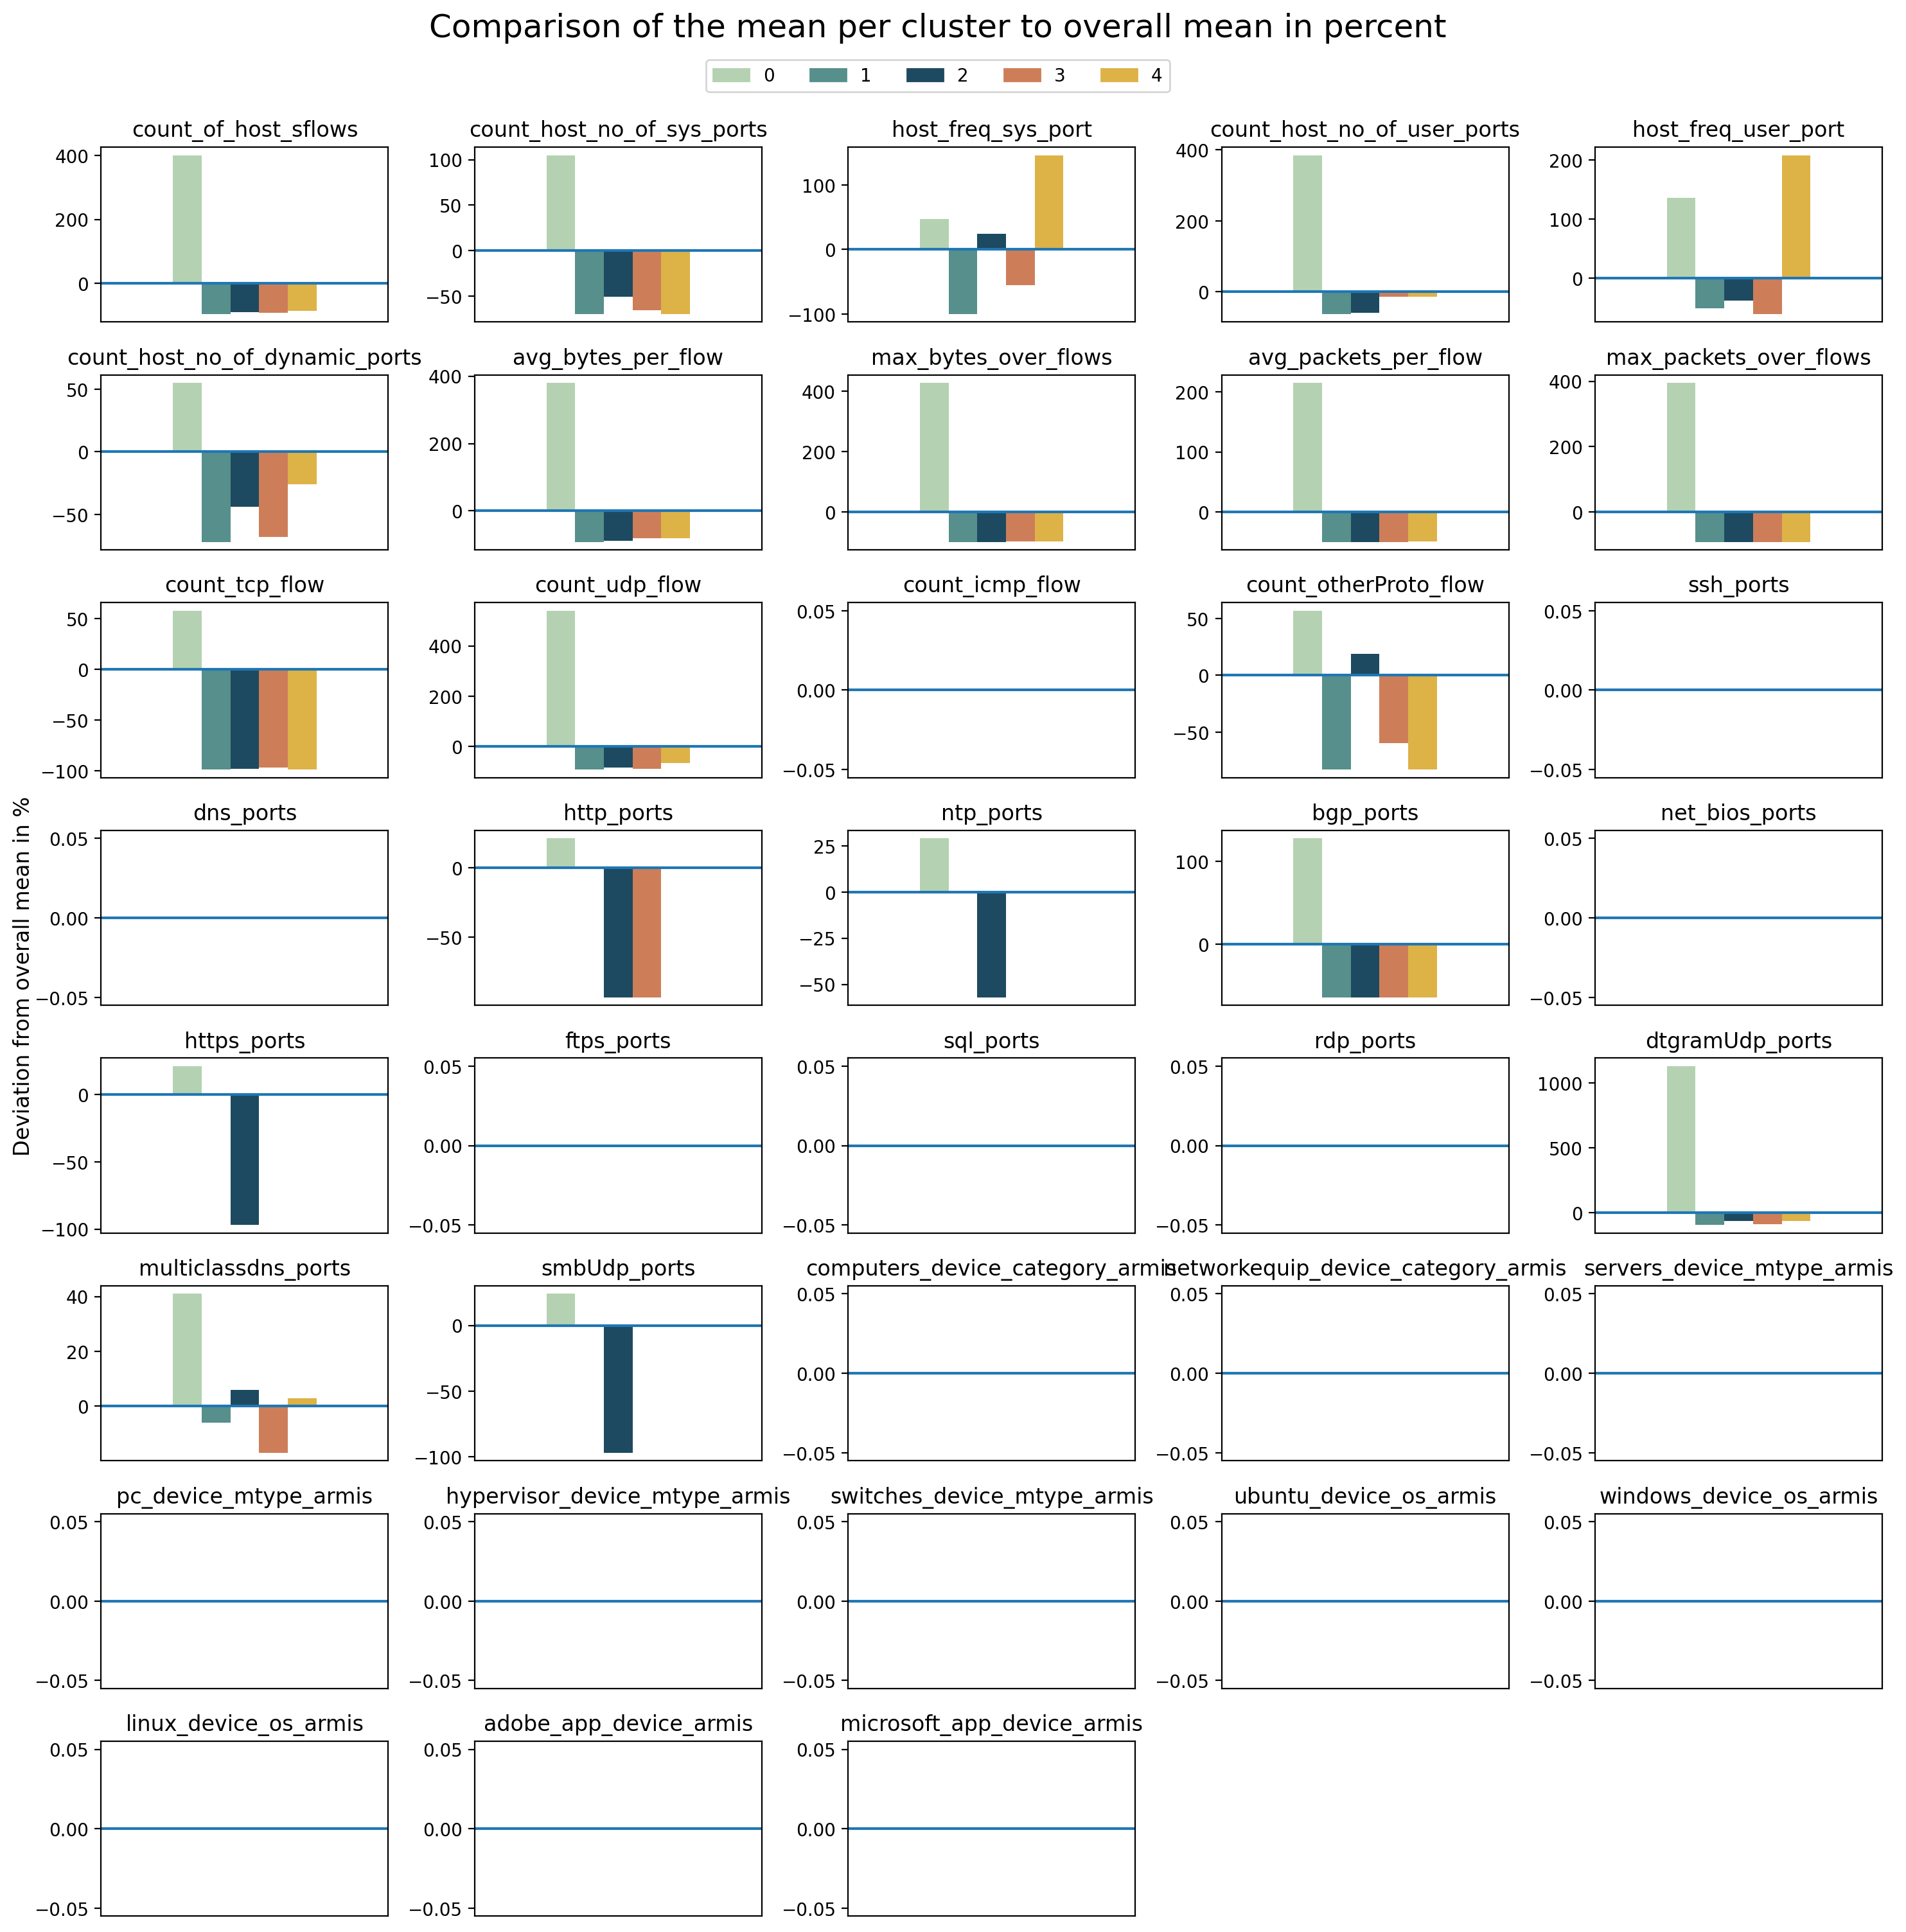

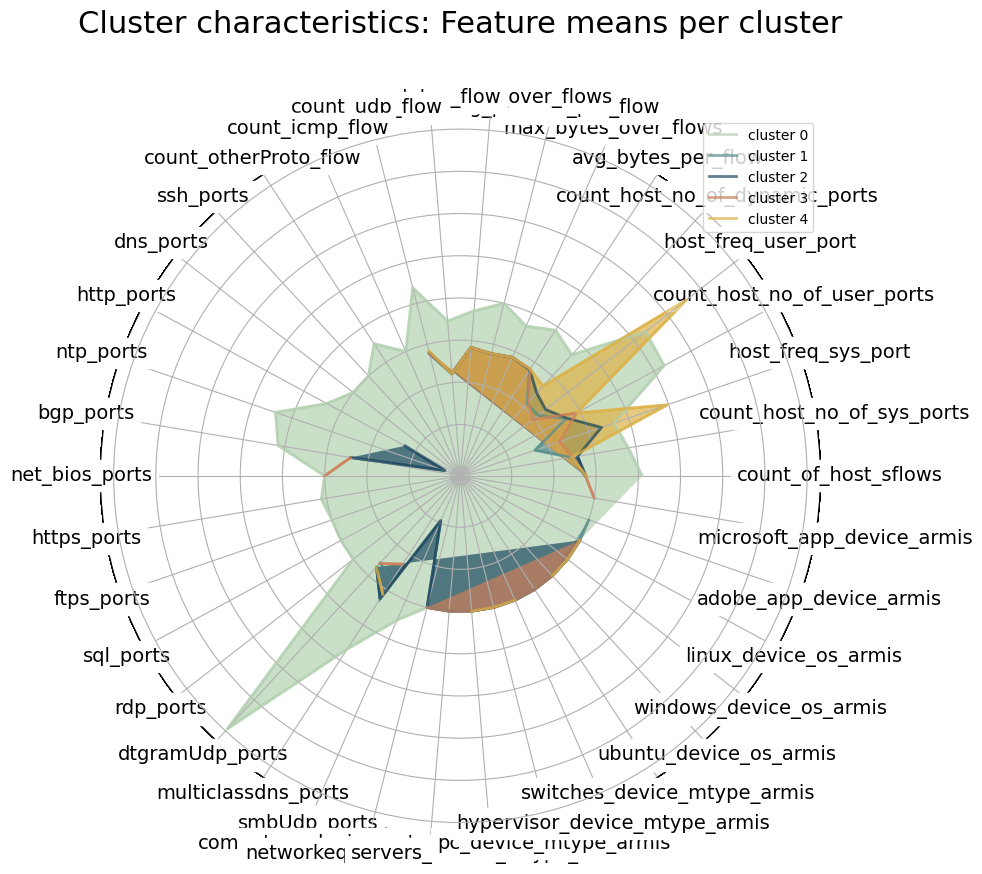

========== alpha=0.1, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.942268371582031
loss: 5.3539
loss: 4.9419
loss: 4.7807
loss: 4.6755
loss: 4.3757
loss: 4.3290
loss: 4.2270
loss: 4.0839
loss: 4.1640


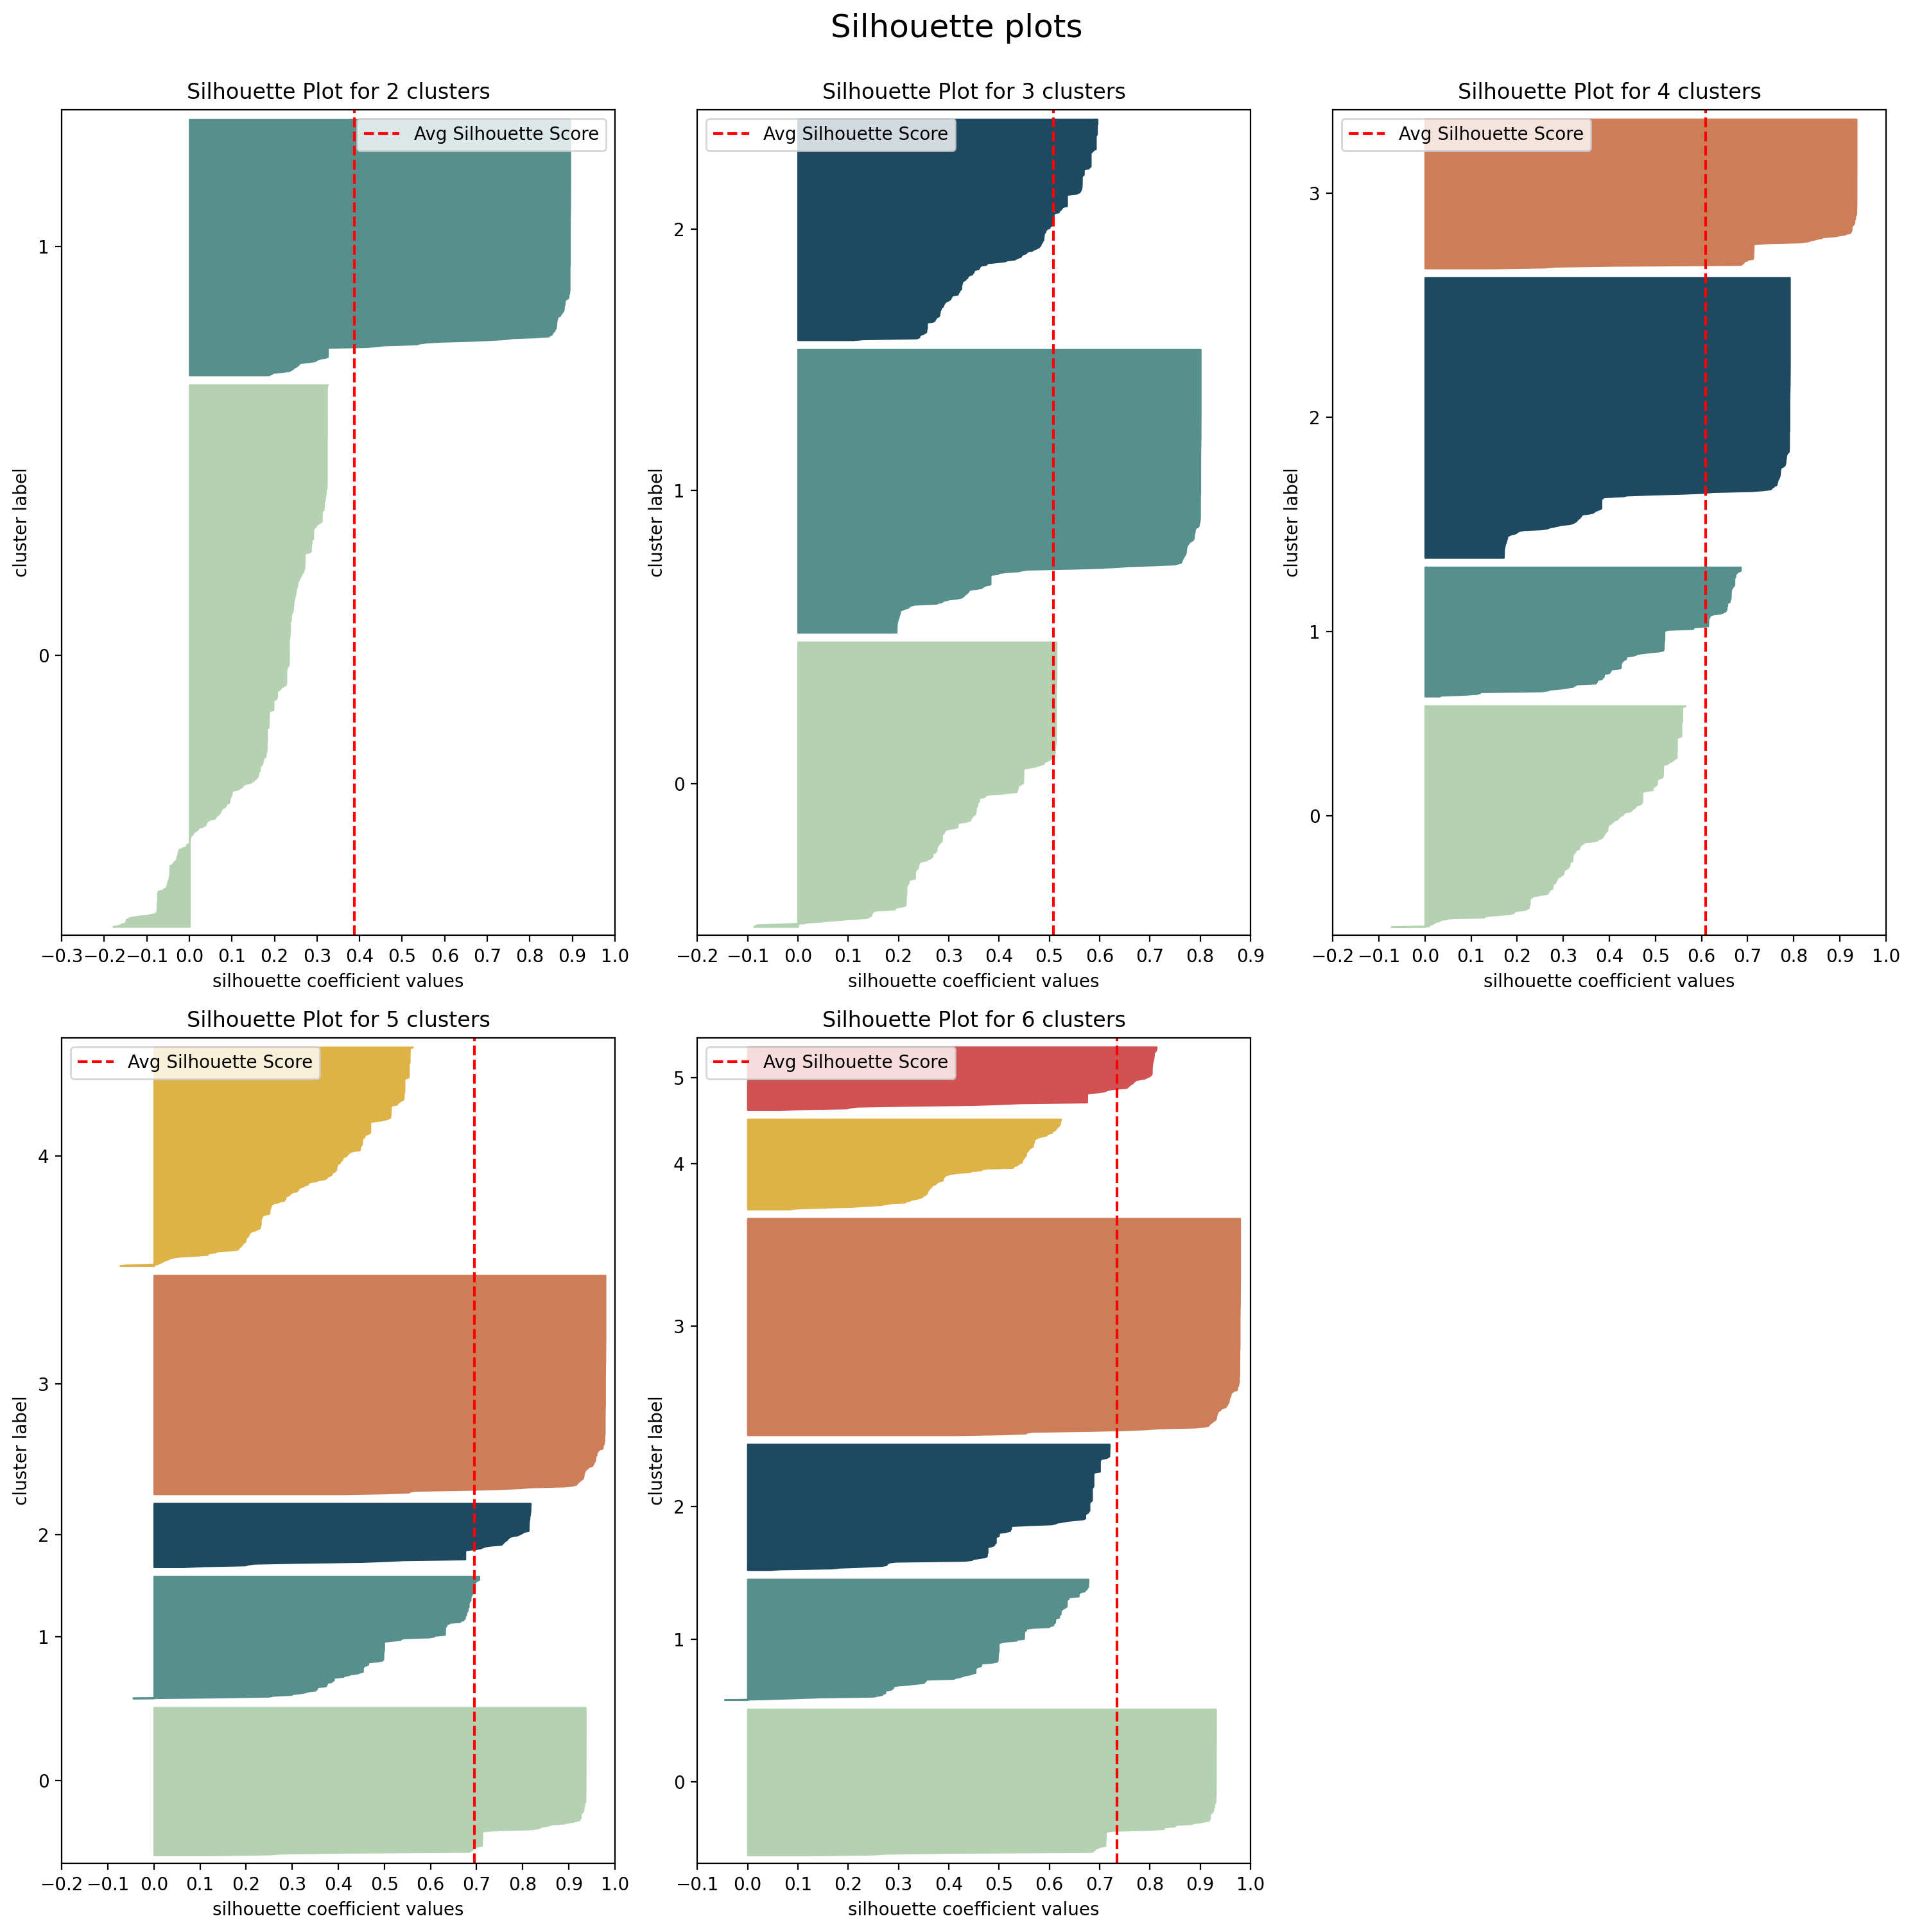

loss: 4.1551
========== reg=0.1 ==========


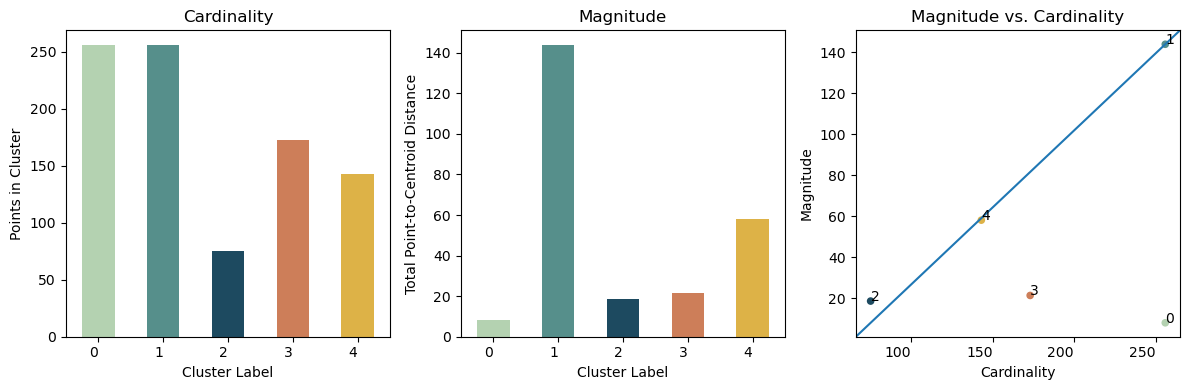

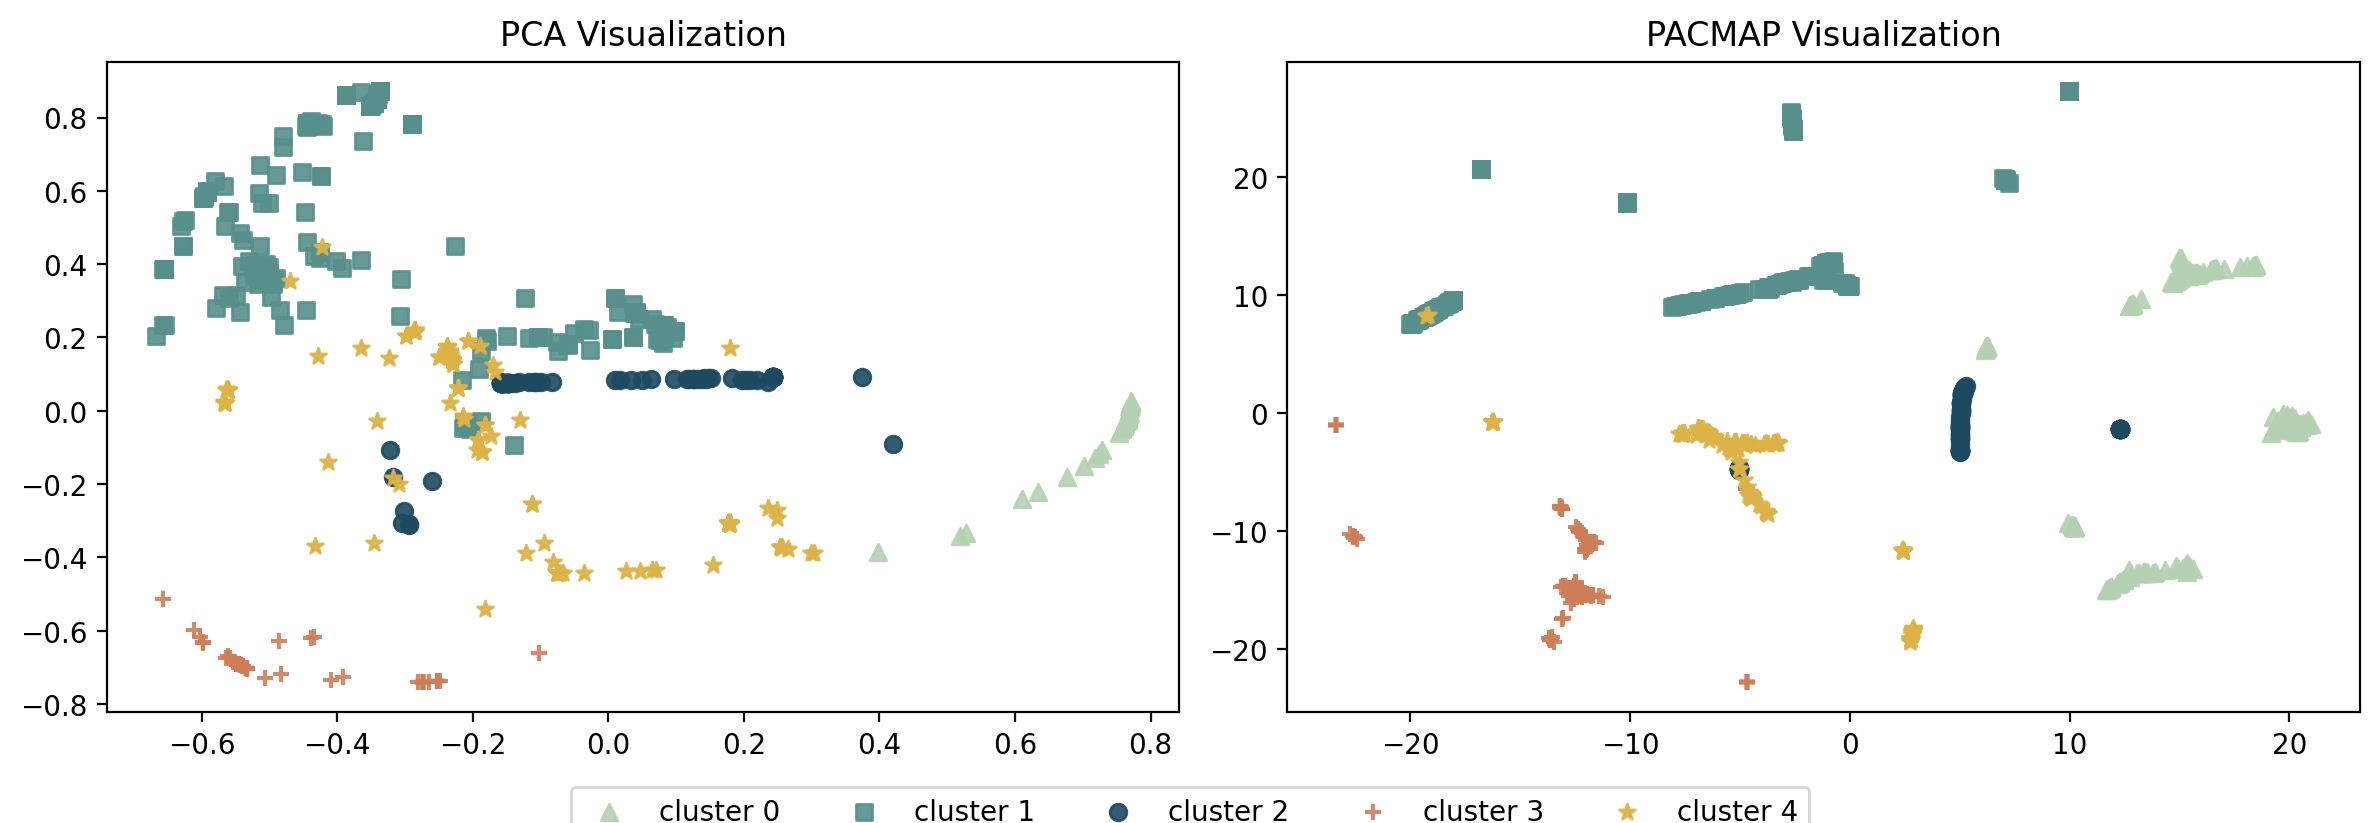

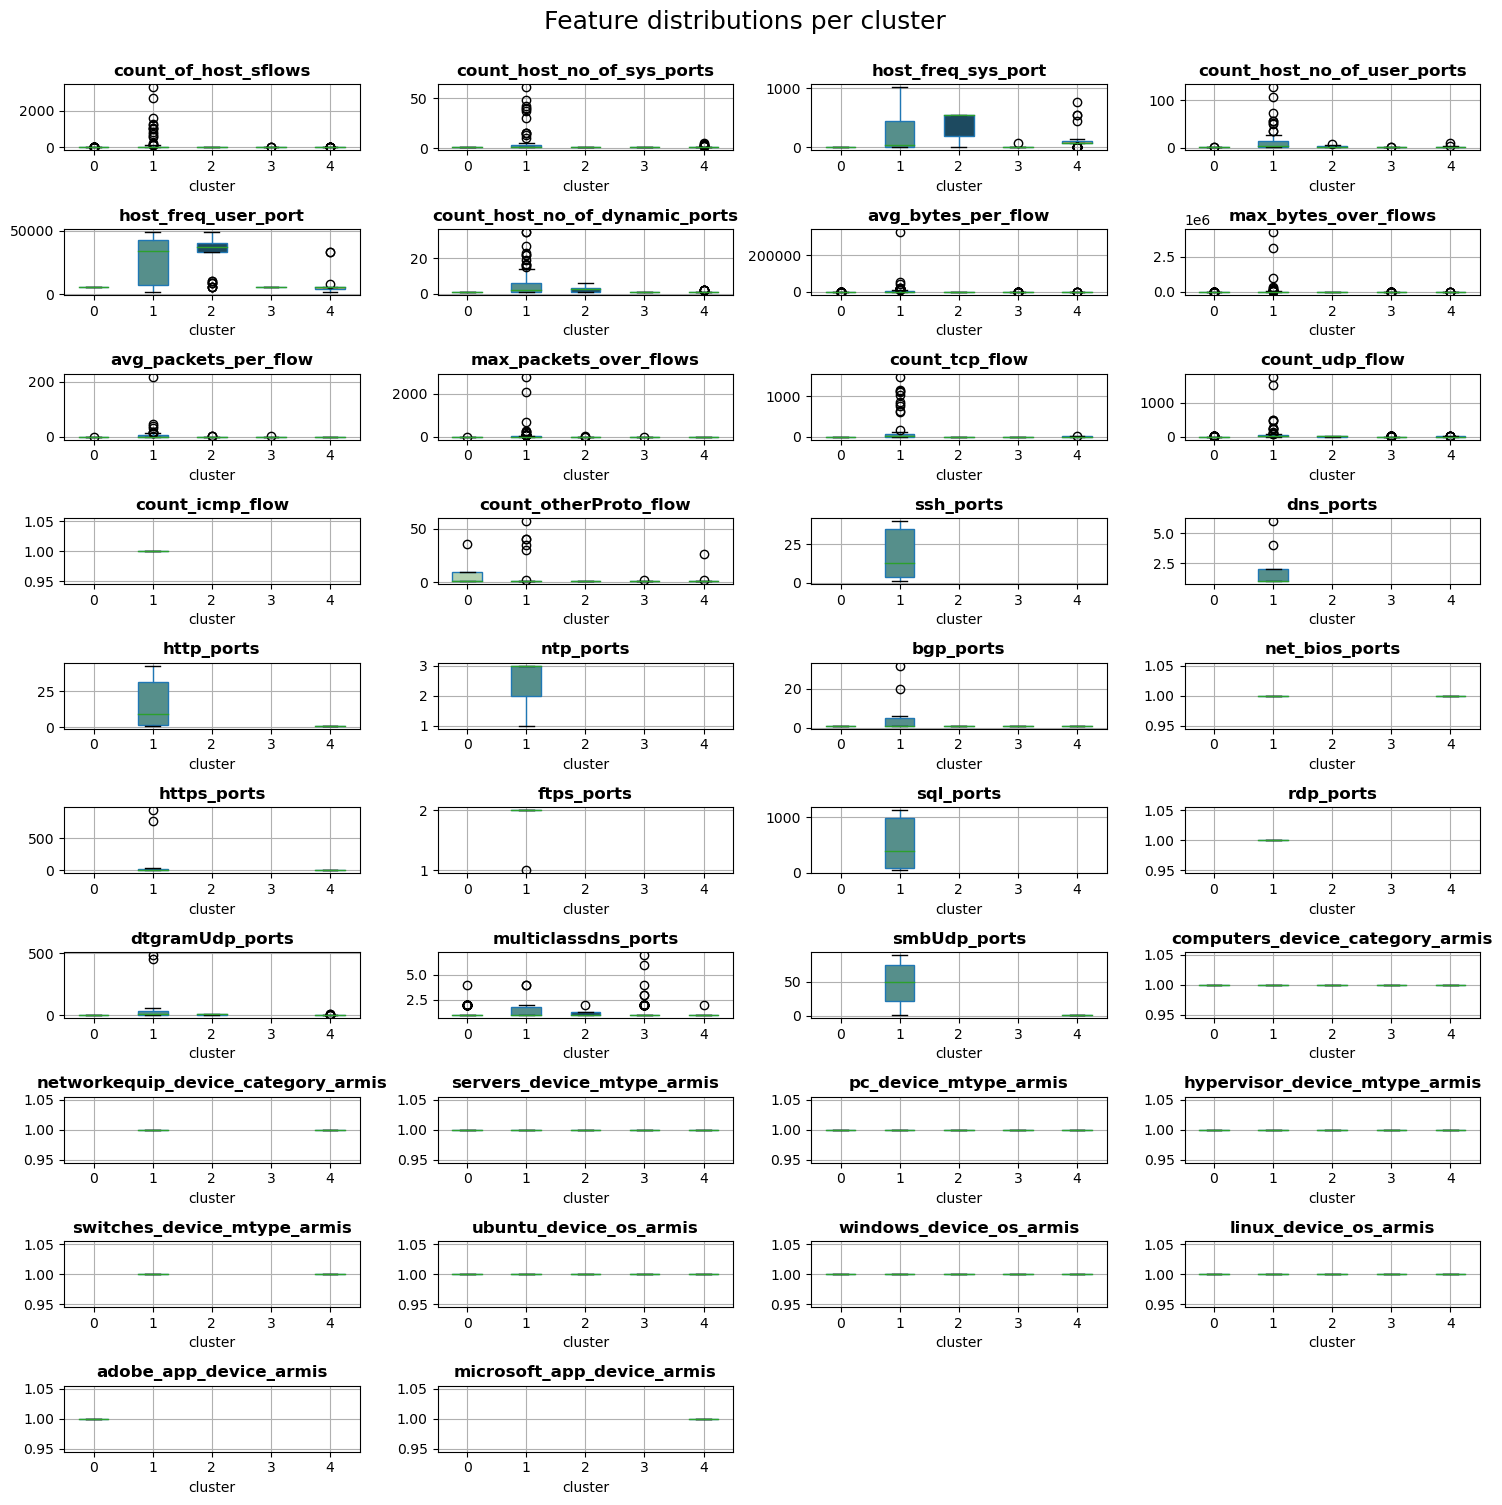

                                   0
cluster category                    
0       Computers          66.015625
1       Computers          18.750000
        Network Equipment   4.687500
2       Computers          32.000000
3       Computers          54.913295
4       Computers          35.664336
        Network Equipment   1.398601
                                    0
cluster mtype                        
0       Hypervisor           1.562500
        Personal Computers   3.906250
        Servers             58.203125
1       Hypervisor           1.562500
        Personal Computers   2.734375
        Servers             14.453125
        Switches             3.906250
2       Hypervisor           1.333333
        Personal Computers   5.333333
        Servers             25.333333
3       Hypervisor           1.734104
        Personal Computers   2.890173
        Servers             43.352601
4       Hypervisor           2.097902
        Personal Computers   4.195804
        Servers      

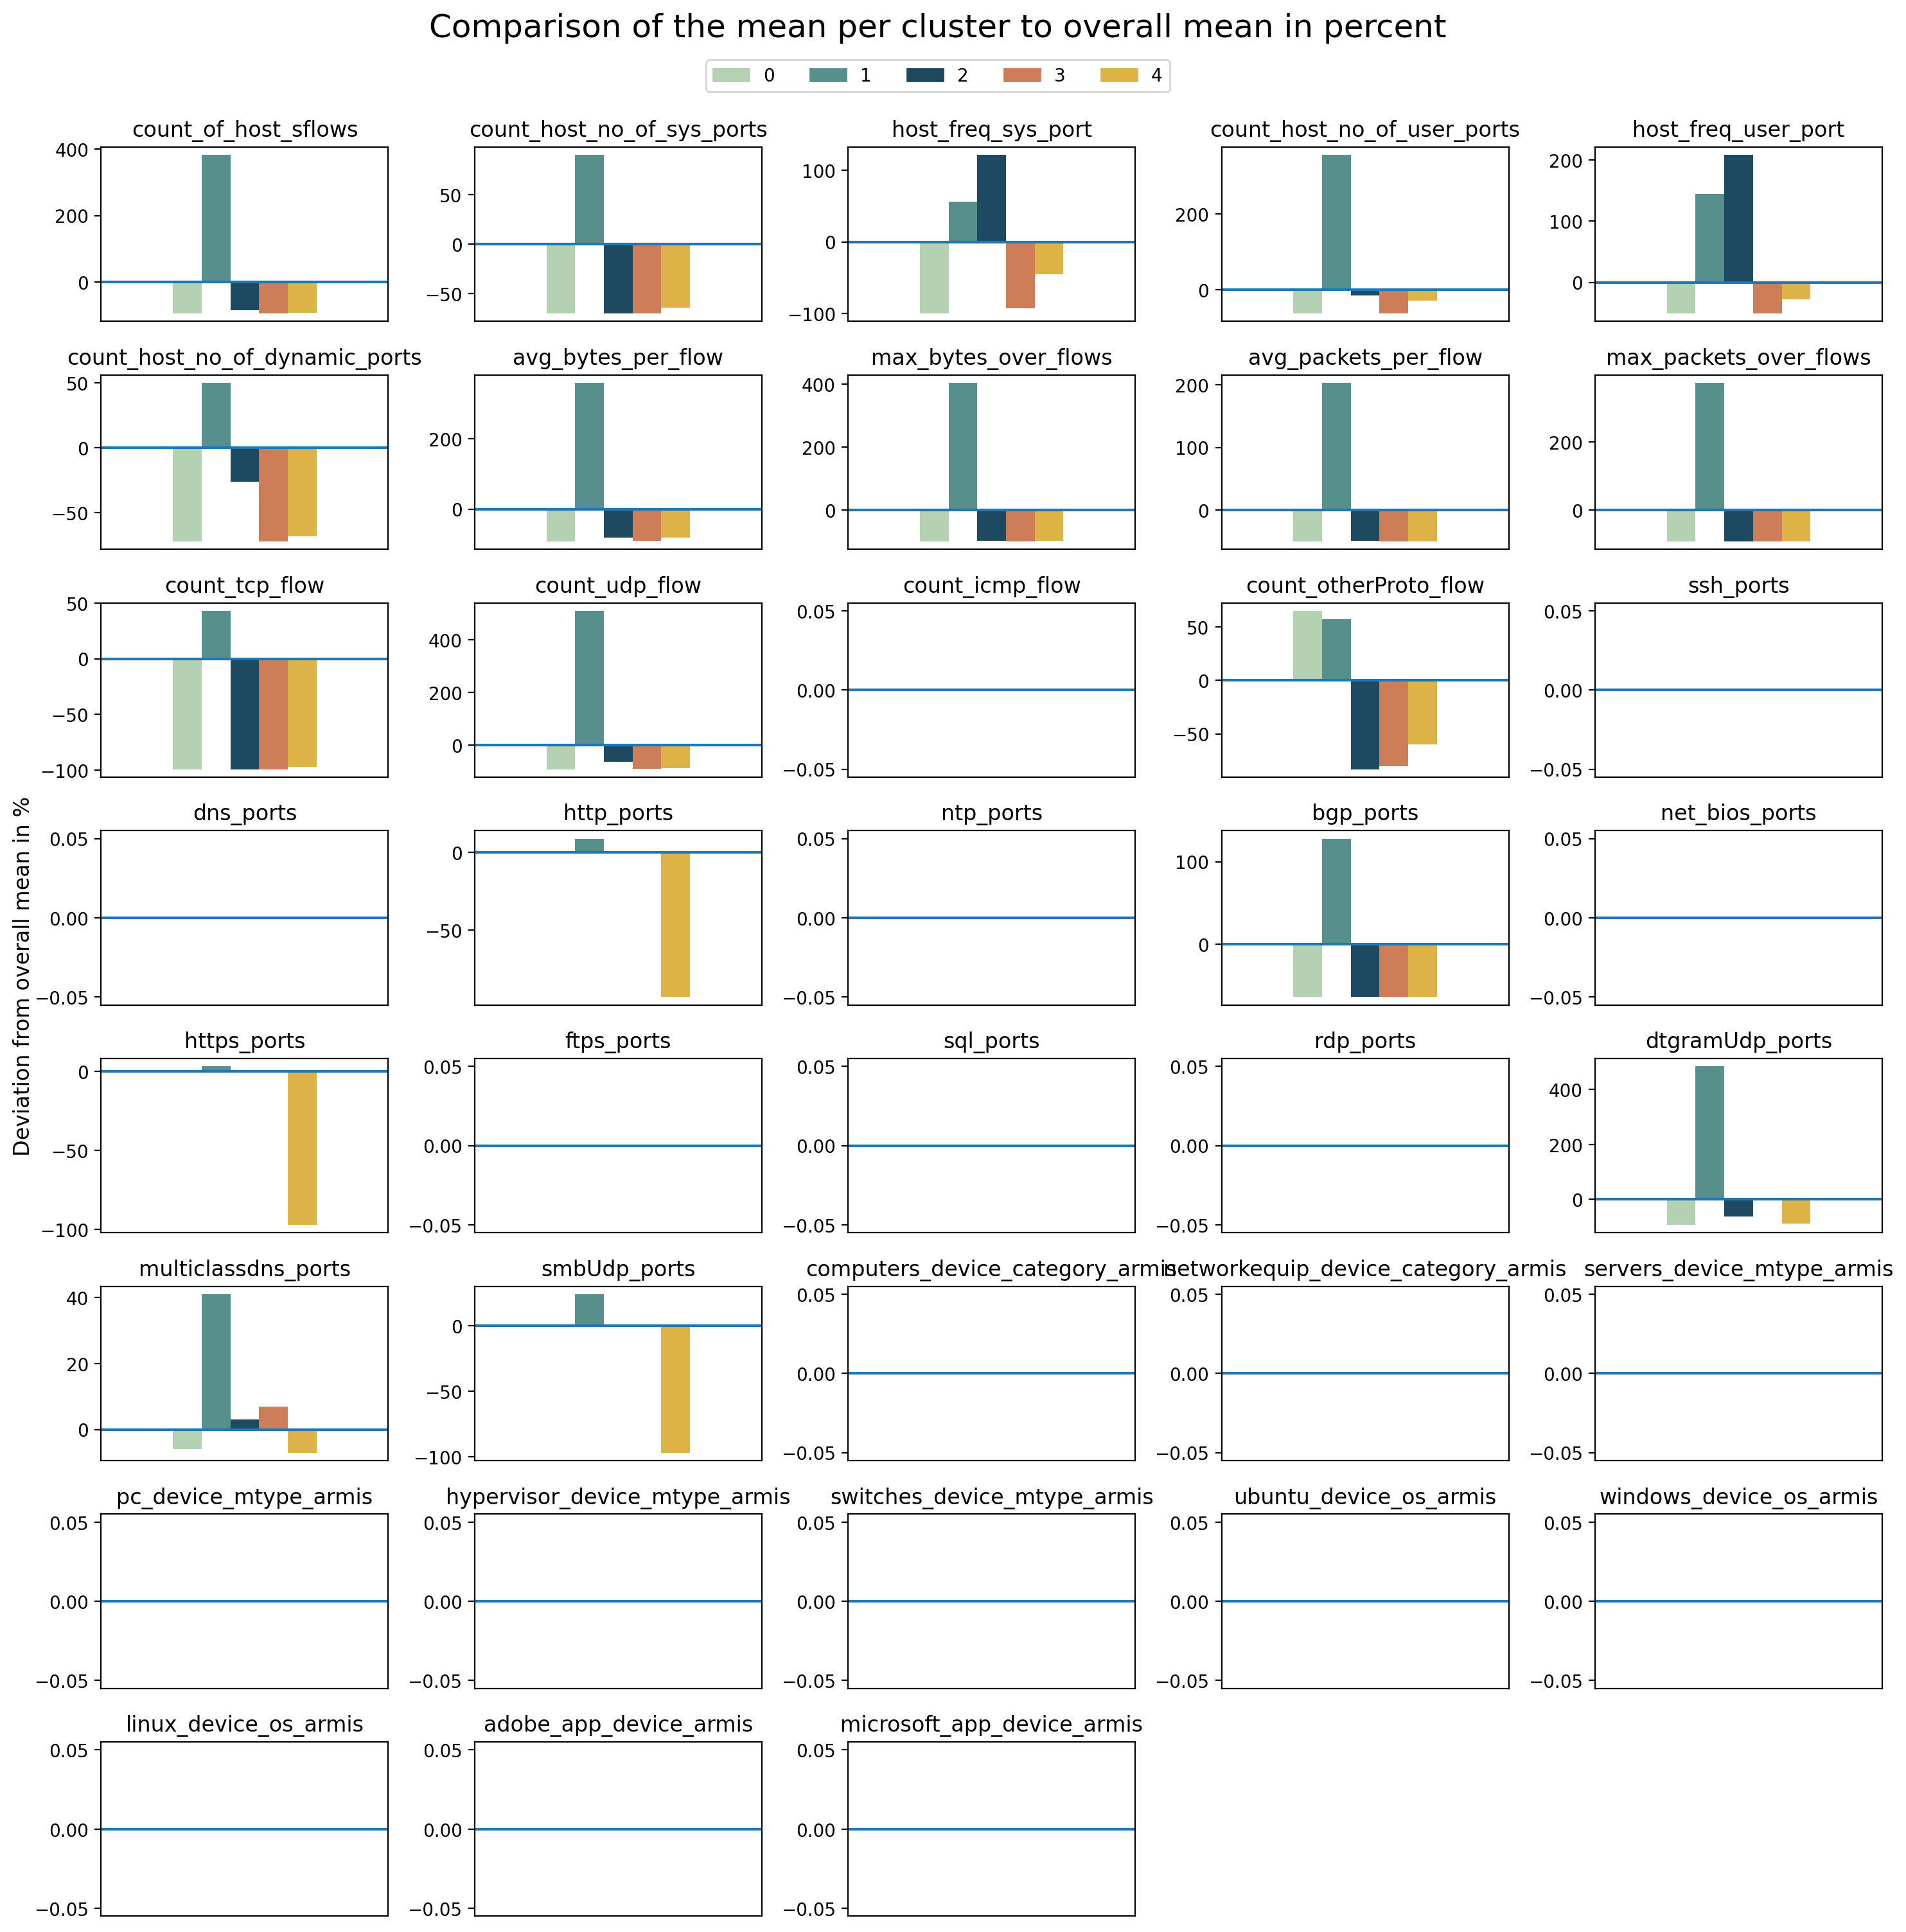

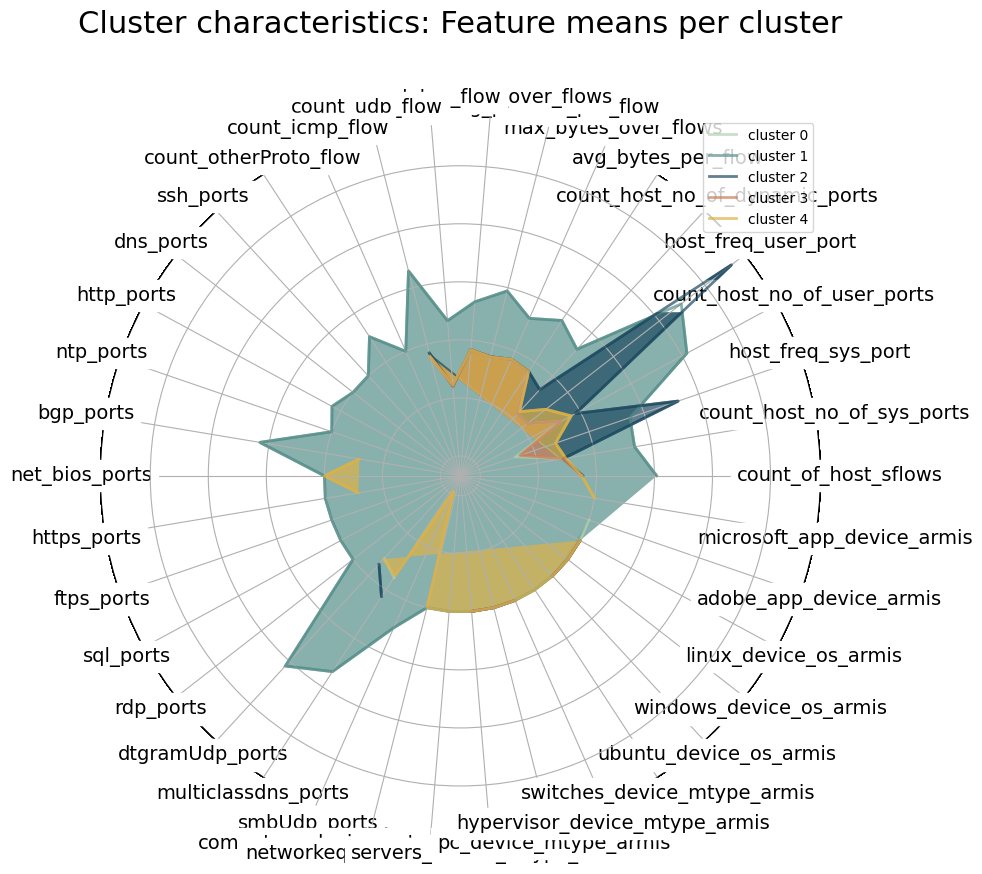

========== alpha=1, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.883720397949219
loss: 5.4241
loss: 5.0833
loss: 4.7619
loss: 4.4083
loss: 4.4617
loss: 4.2988
loss: 4.2864
loss: 4.3415
loss: 4.3246


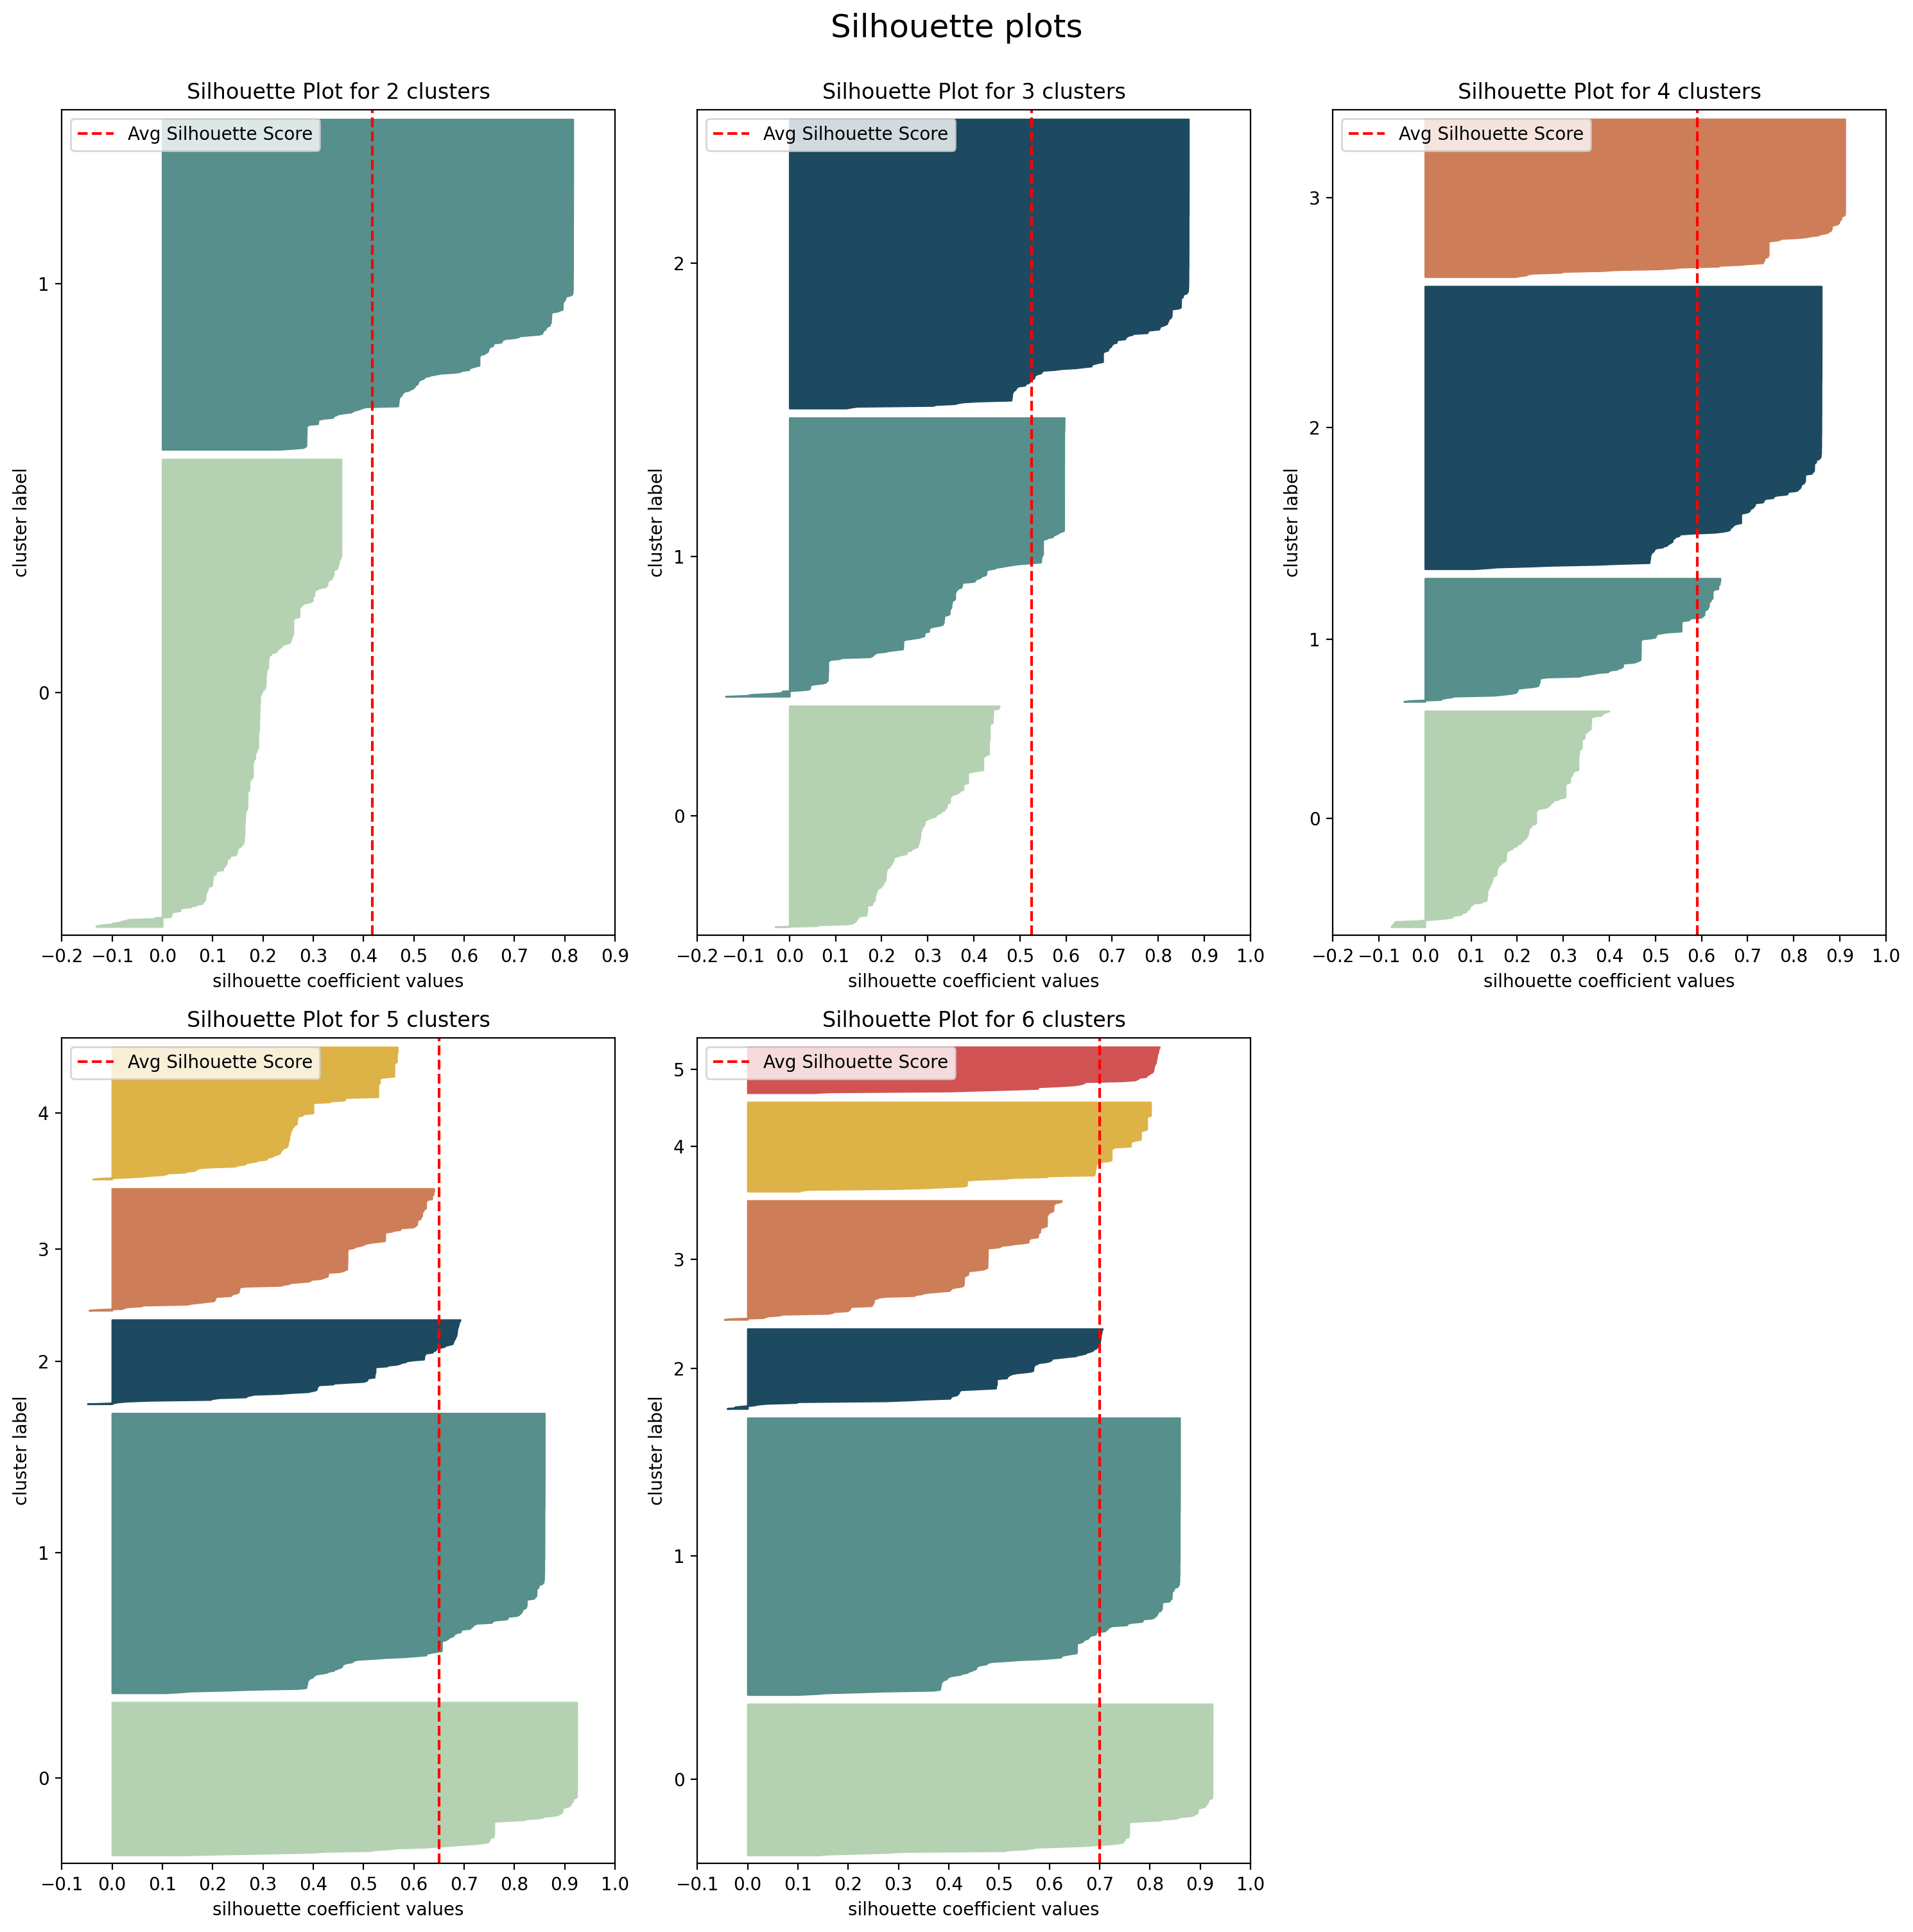

loss: 4.3130
========== reg=1 ==========


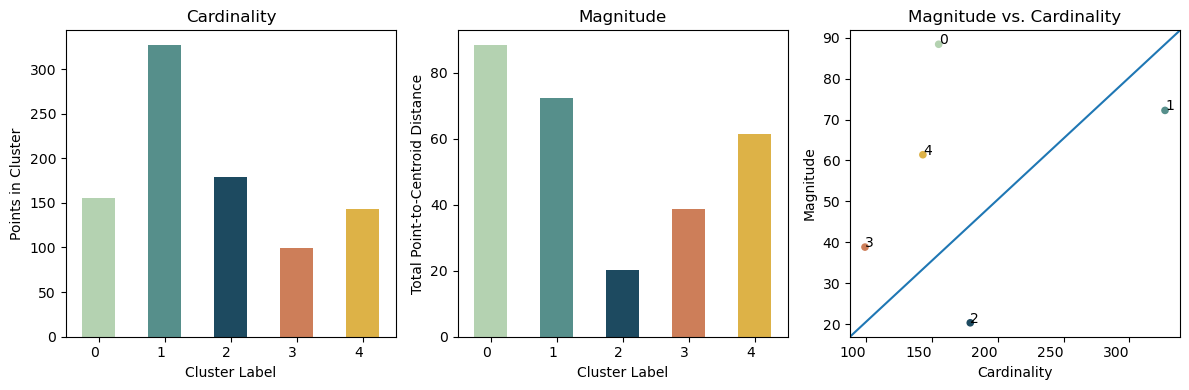

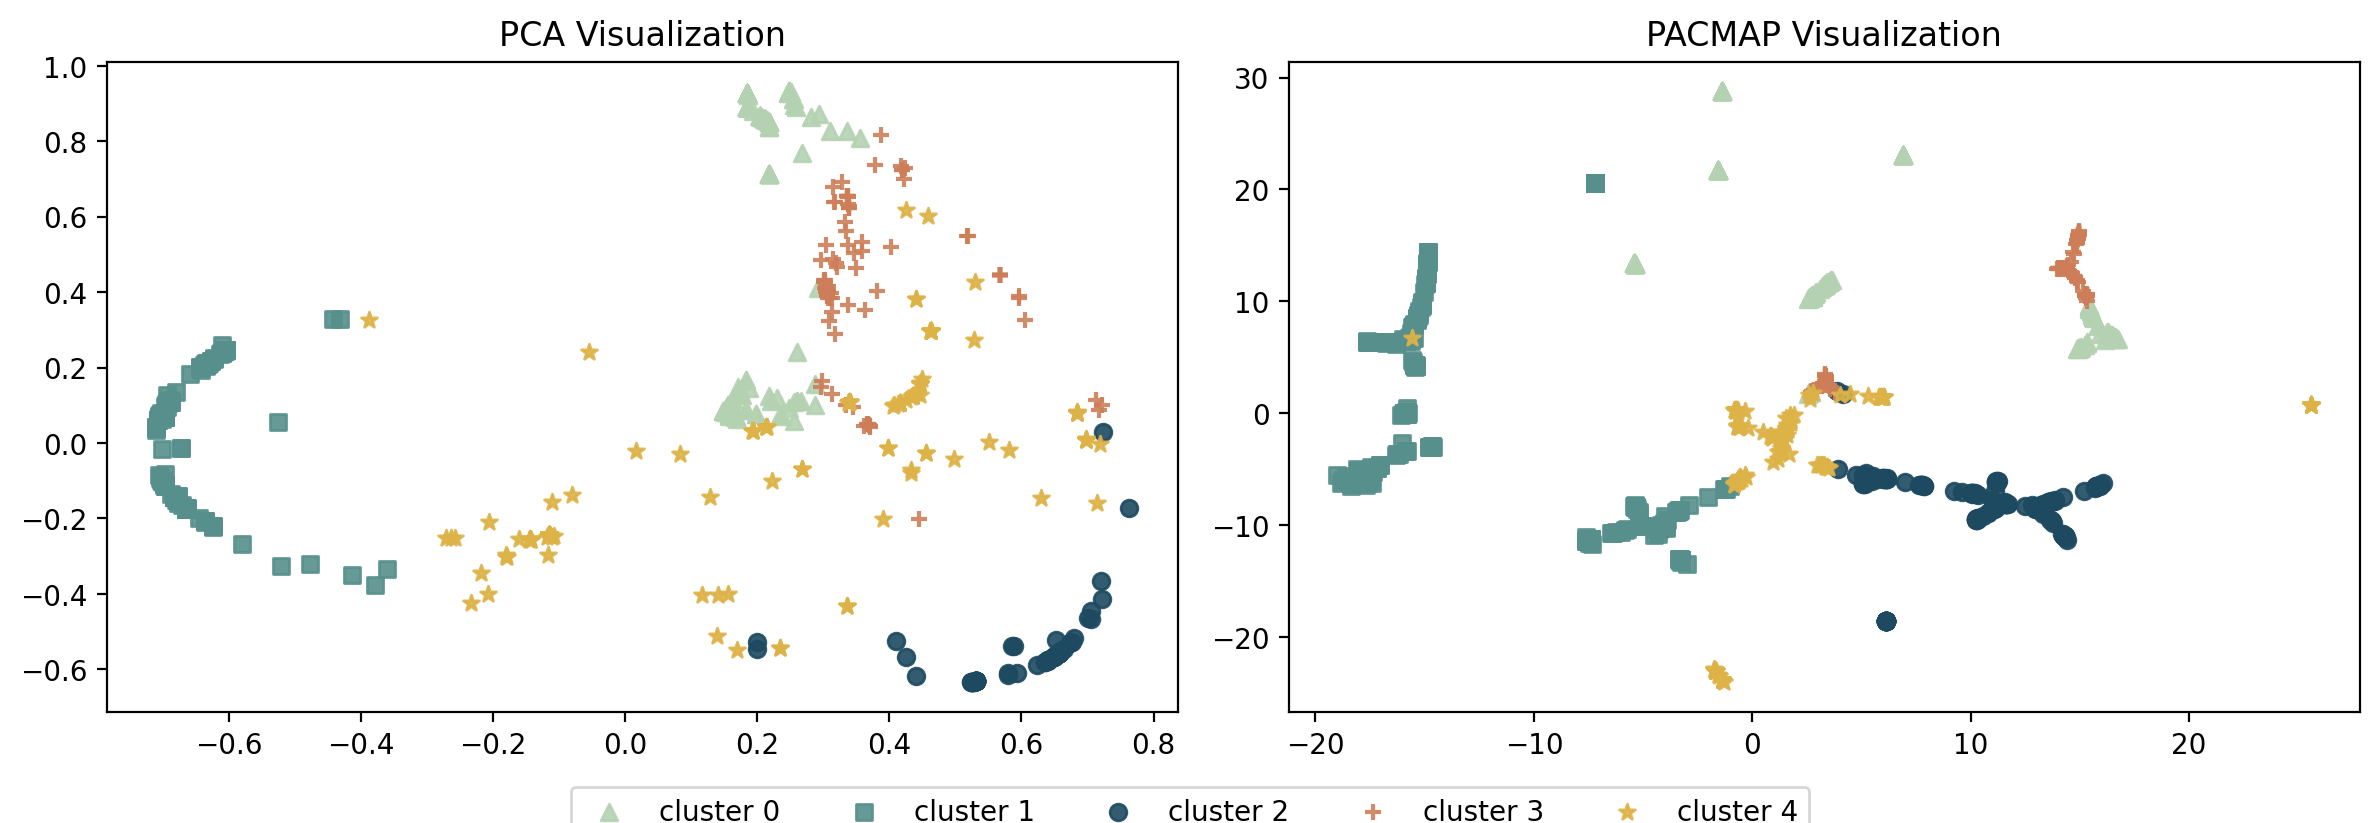

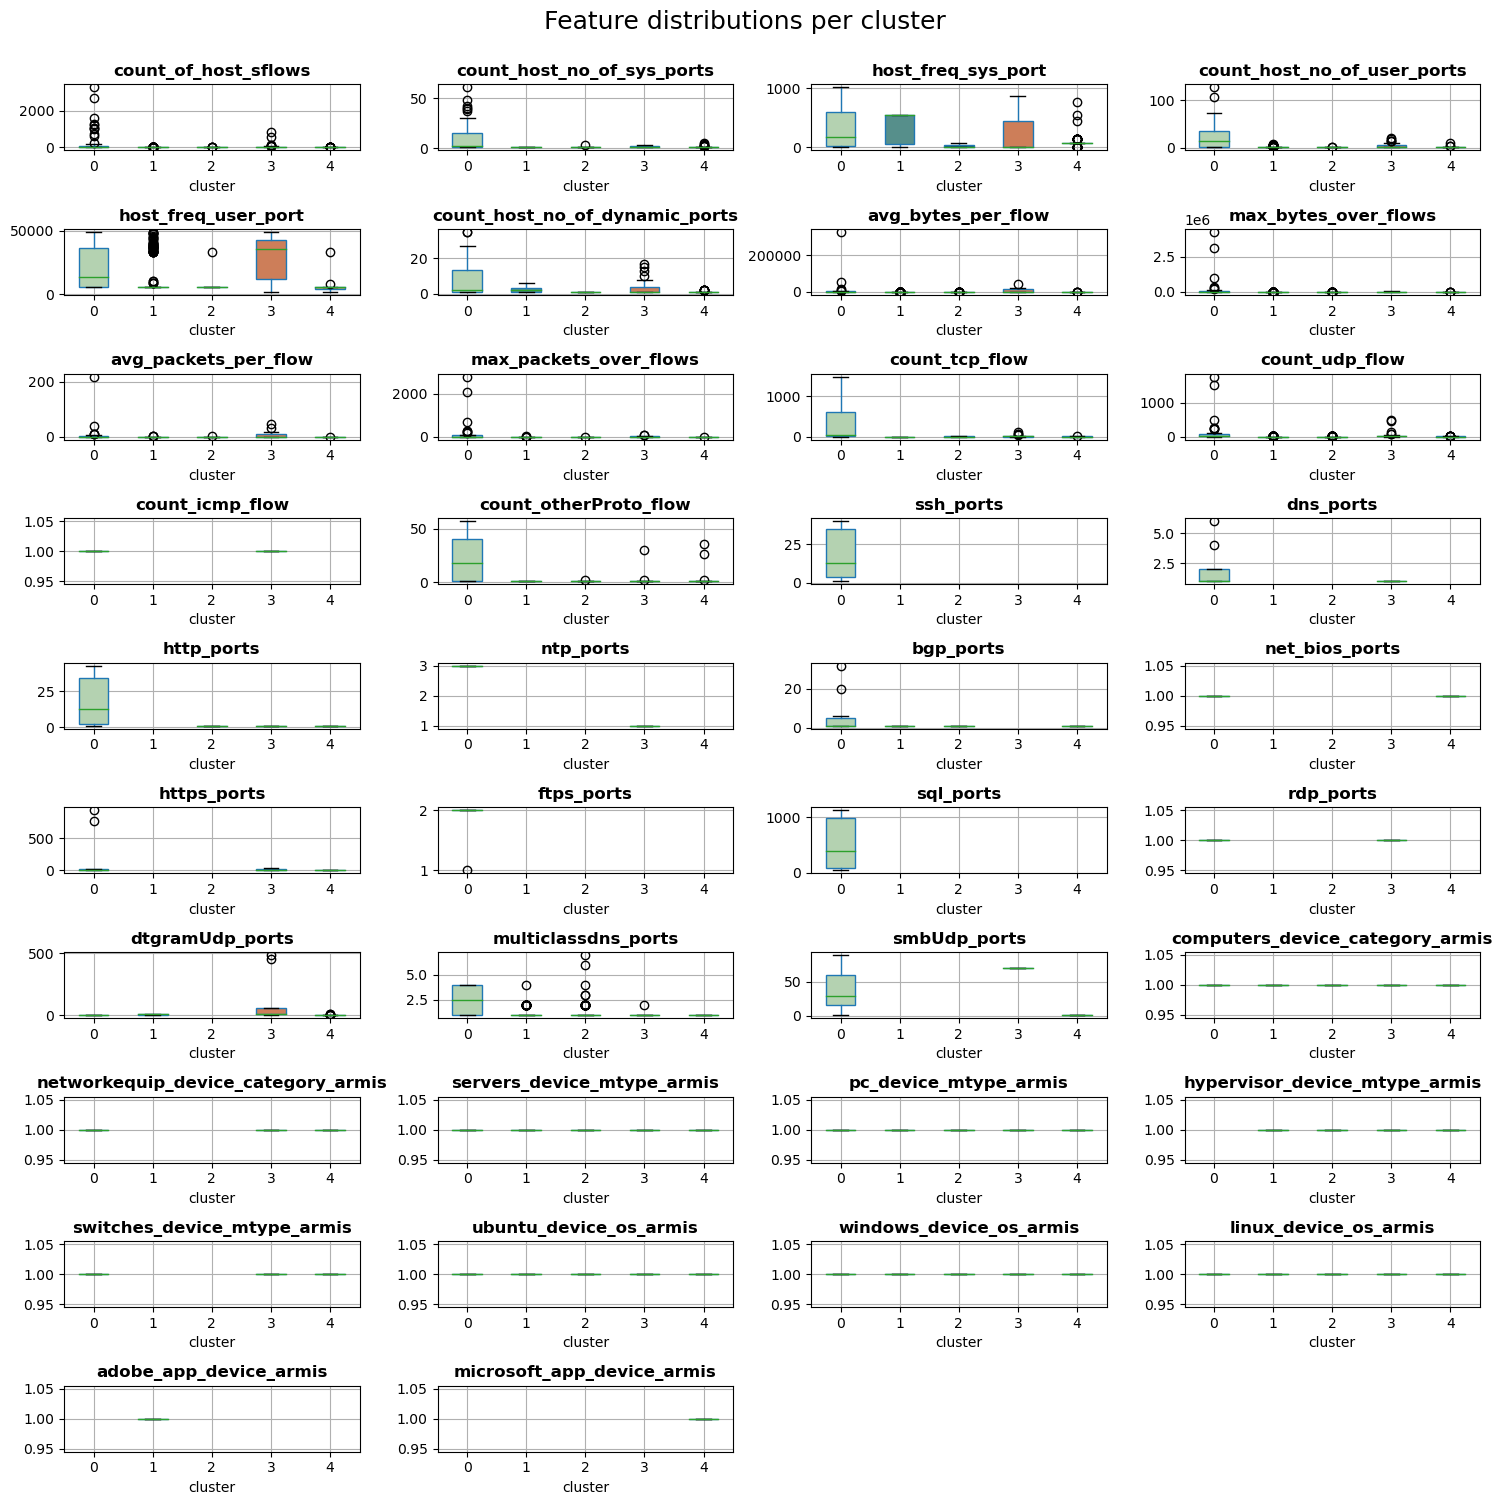

                                   0
cluster category                    
0       Computers          10.322581
        Network Equipment   5.161290
1       Computers          59.021407
2       Computers          53.072626
3       Computers          32.323232
        Network Equipment   4.040404
4       Computers          35.664336
        Network Equipment   1.398601
                                    0
cluster mtype                        
0       Personal Computers   2.580645
        Servers              7.741935
        Switches             5.161290
1       Hypervisor           1.529052
        Personal Computers   4.281346
        Servers             51.376147
2       Hypervisor           1.675978
        Personal Computers   2.793296
        Servers             41.899441
3       Hypervisor           4.040404
        Personal Computers   3.030303
        Servers             25.252525
        Switches             2.020202
4       Hypervisor           2.097902
        Personal Compu

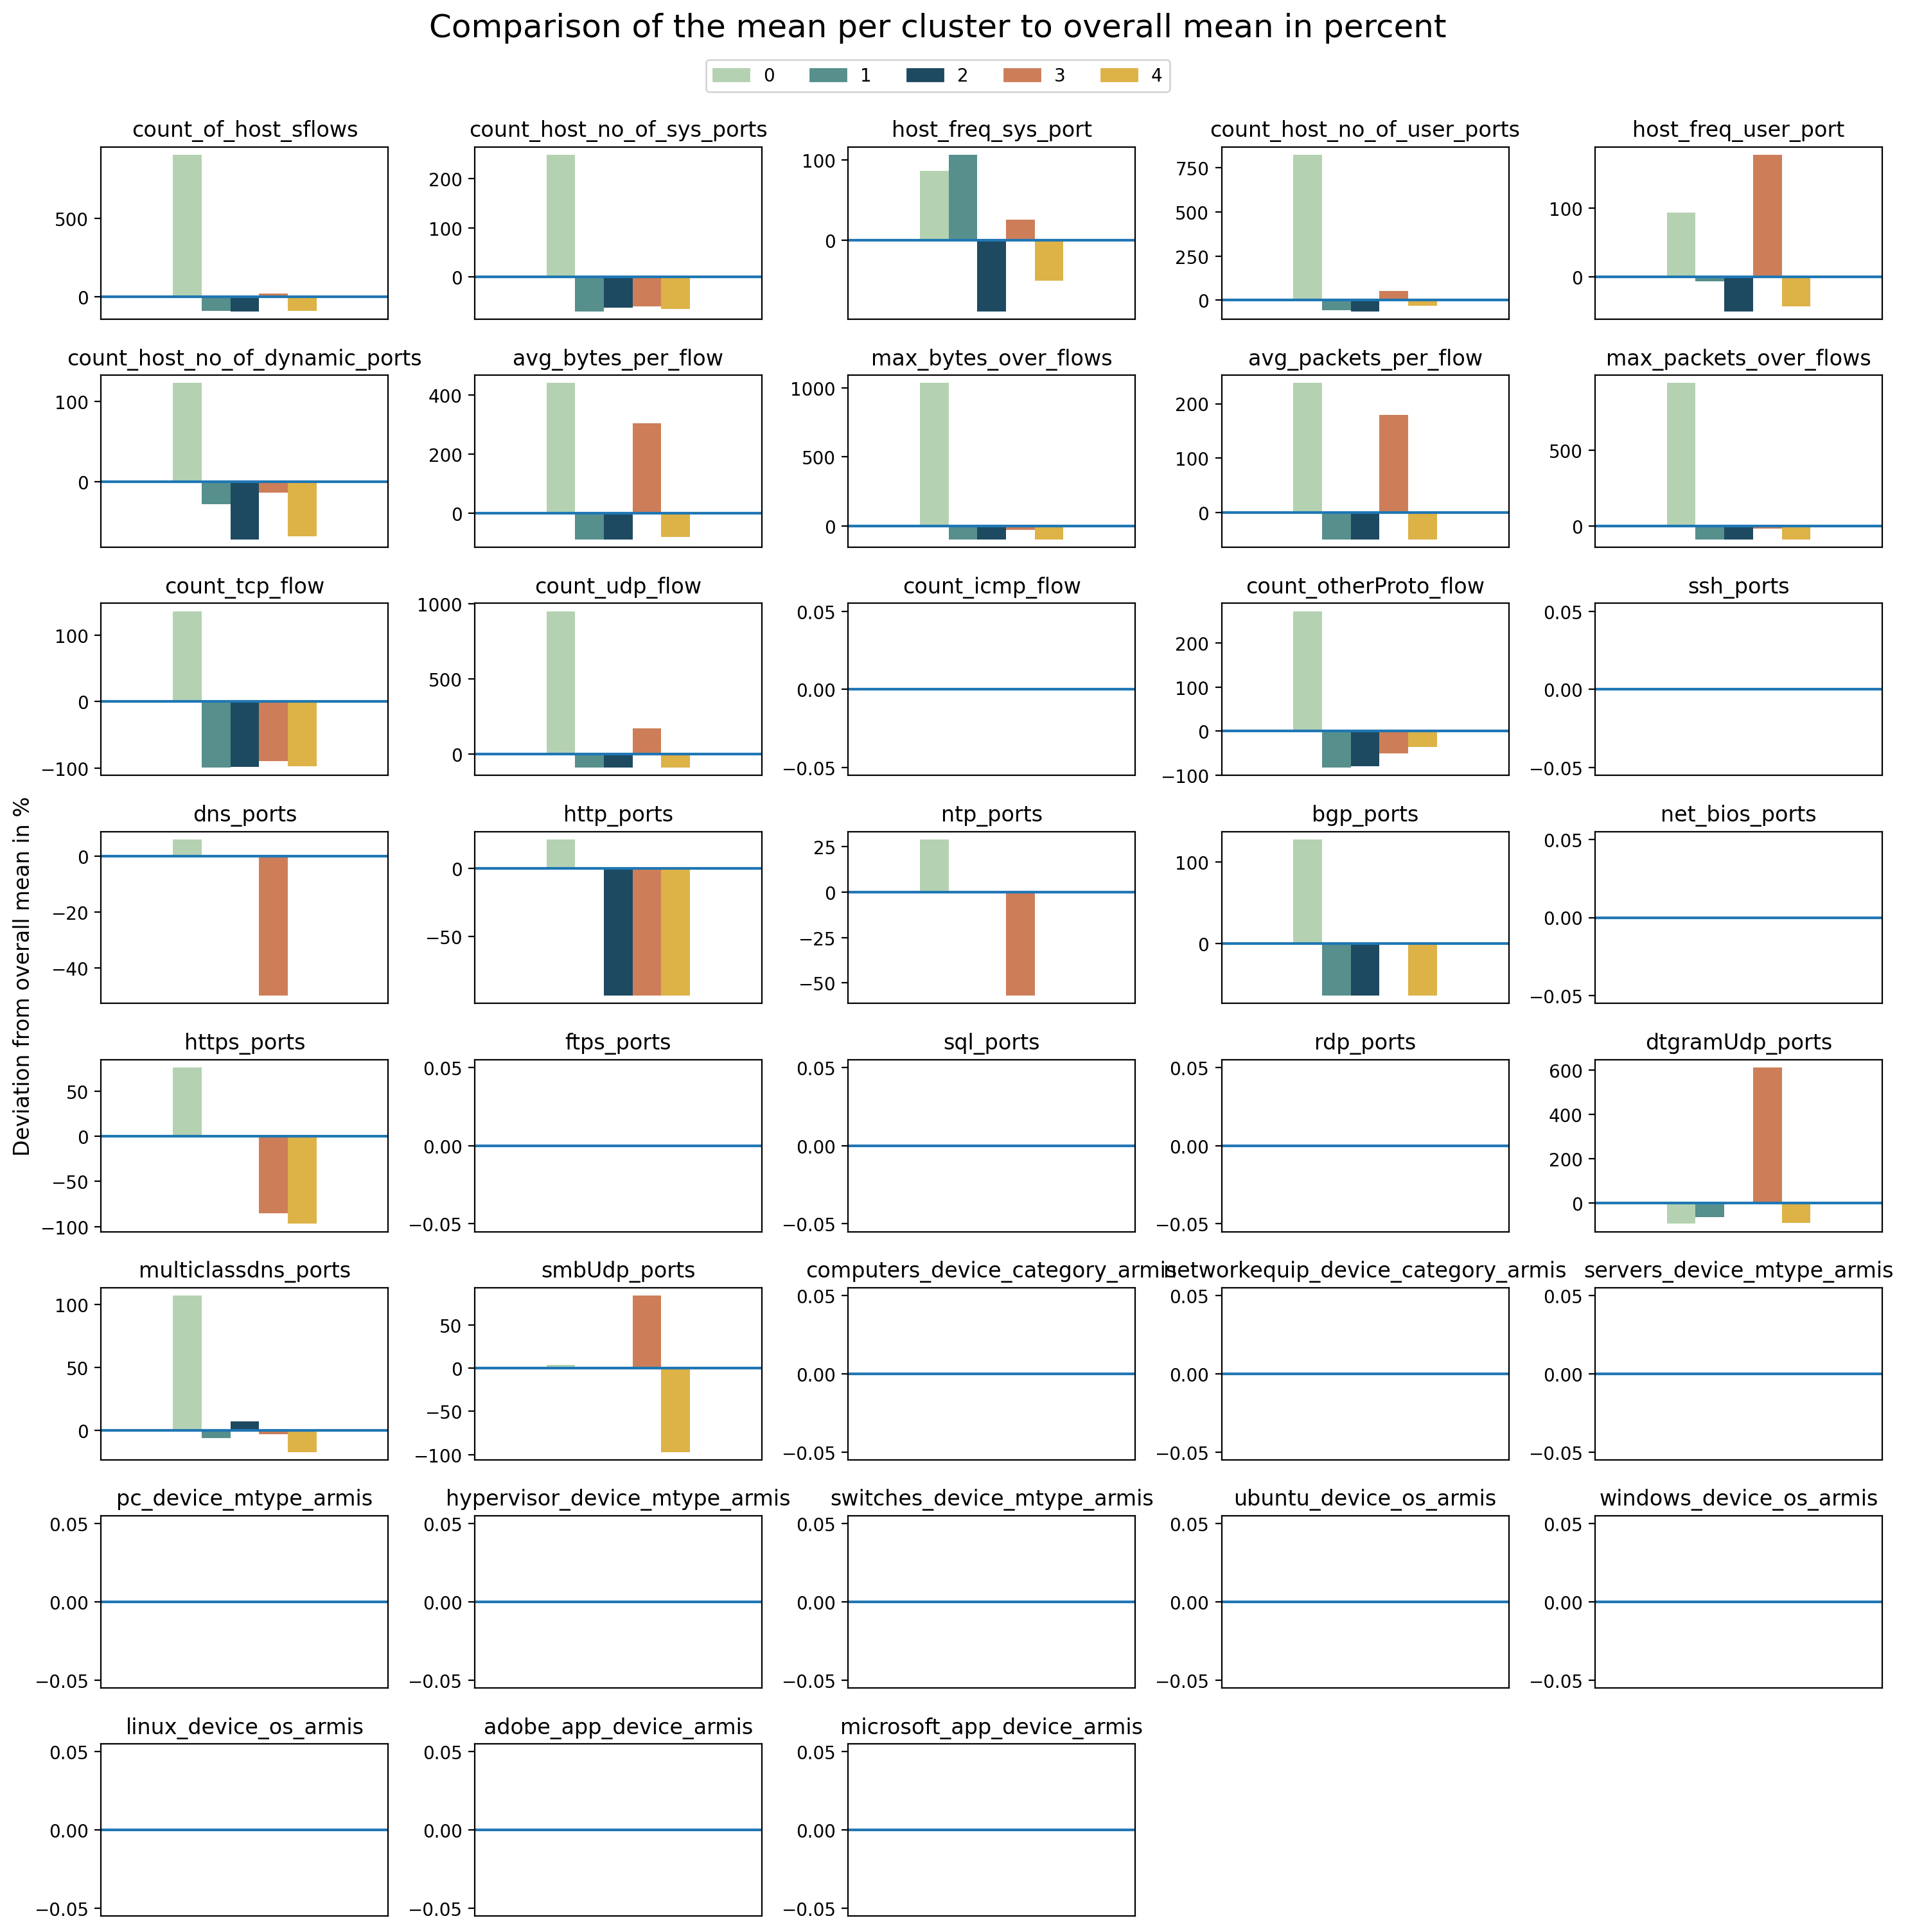

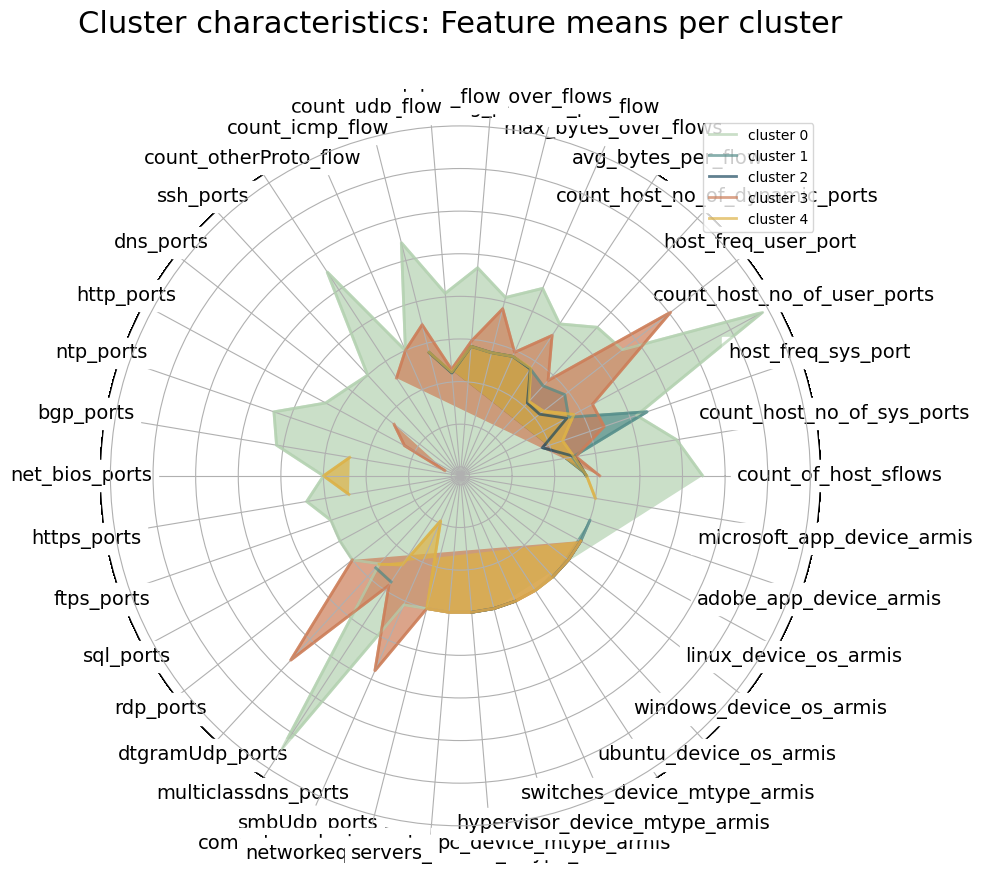

========== alpha=10, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.955600738525391
loss: 5.2940
loss: 4.8214
loss: 4.4356
loss: 4.7222
loss: 4.6964
loss: 4.6543
loss: 4.5812
loss: 4.4554
loss: 4.3207


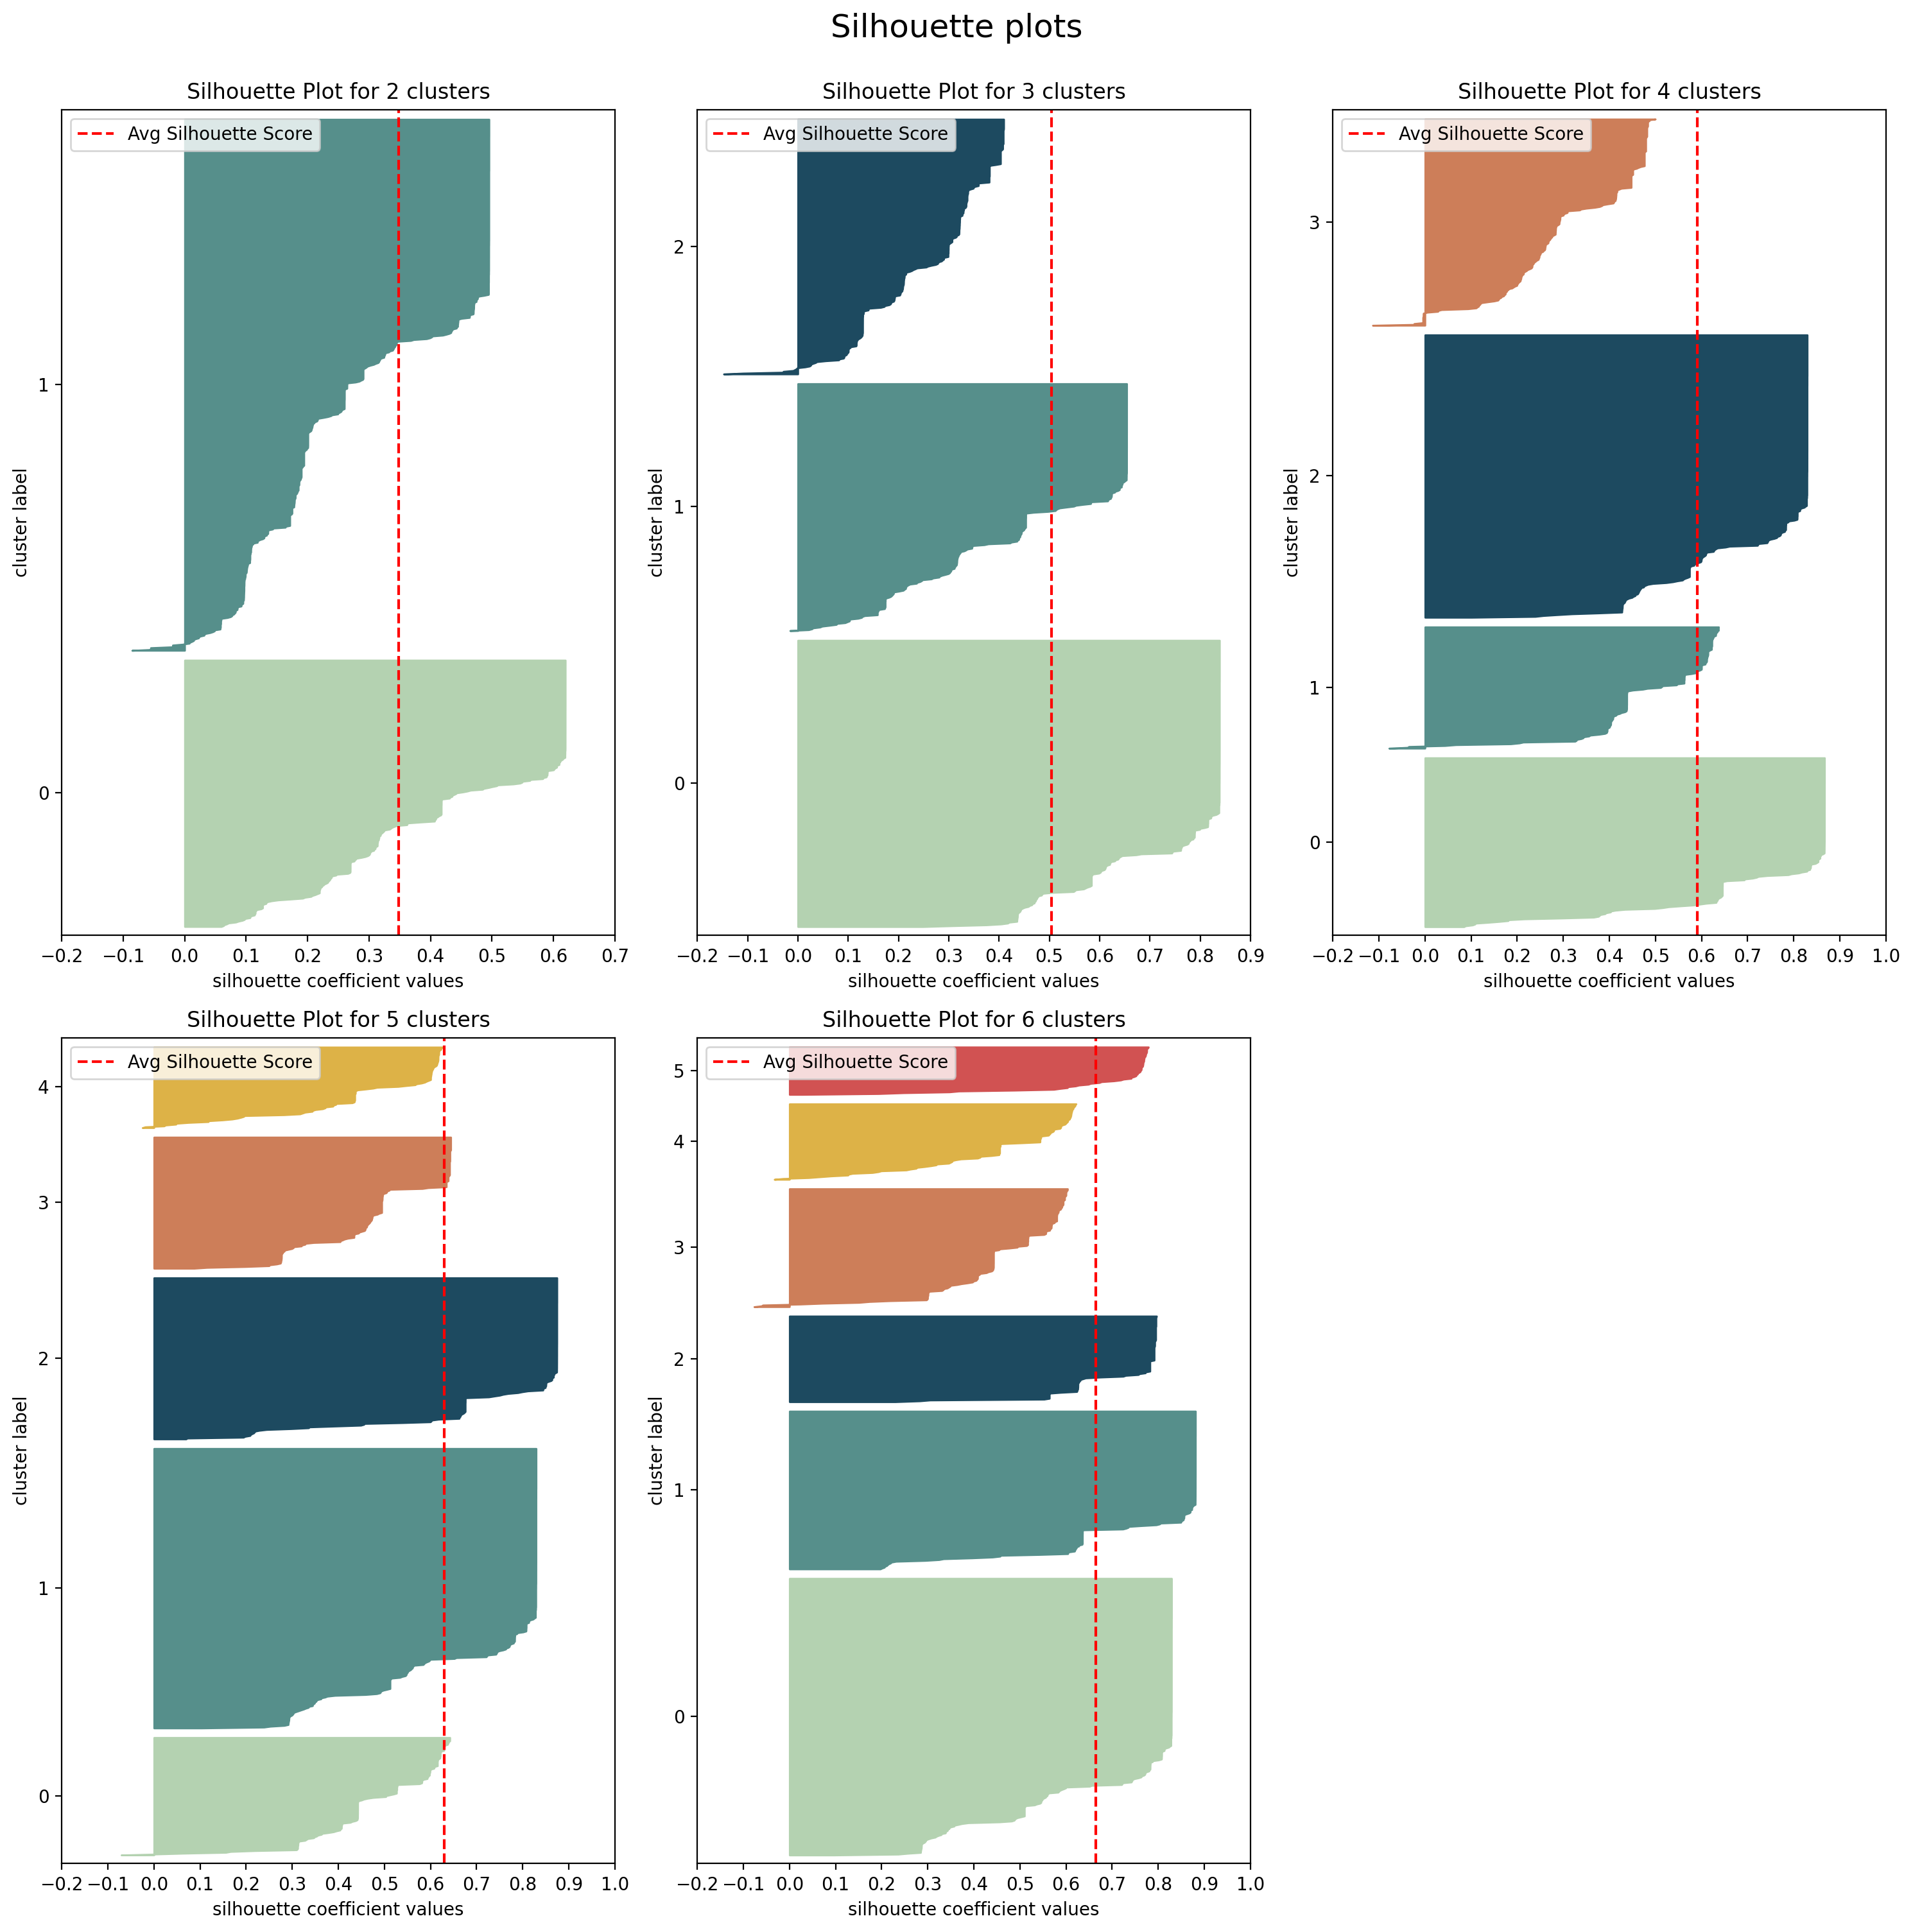

loss: 4.1662
========== reg=10 ==========


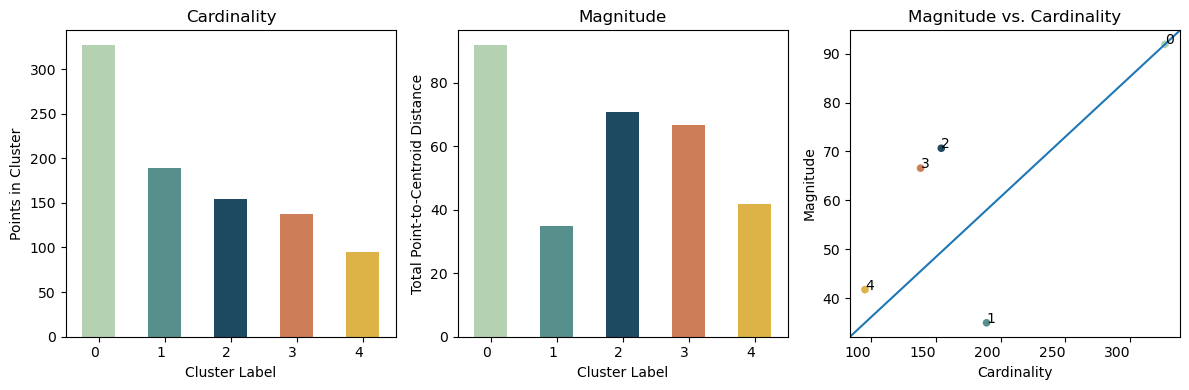

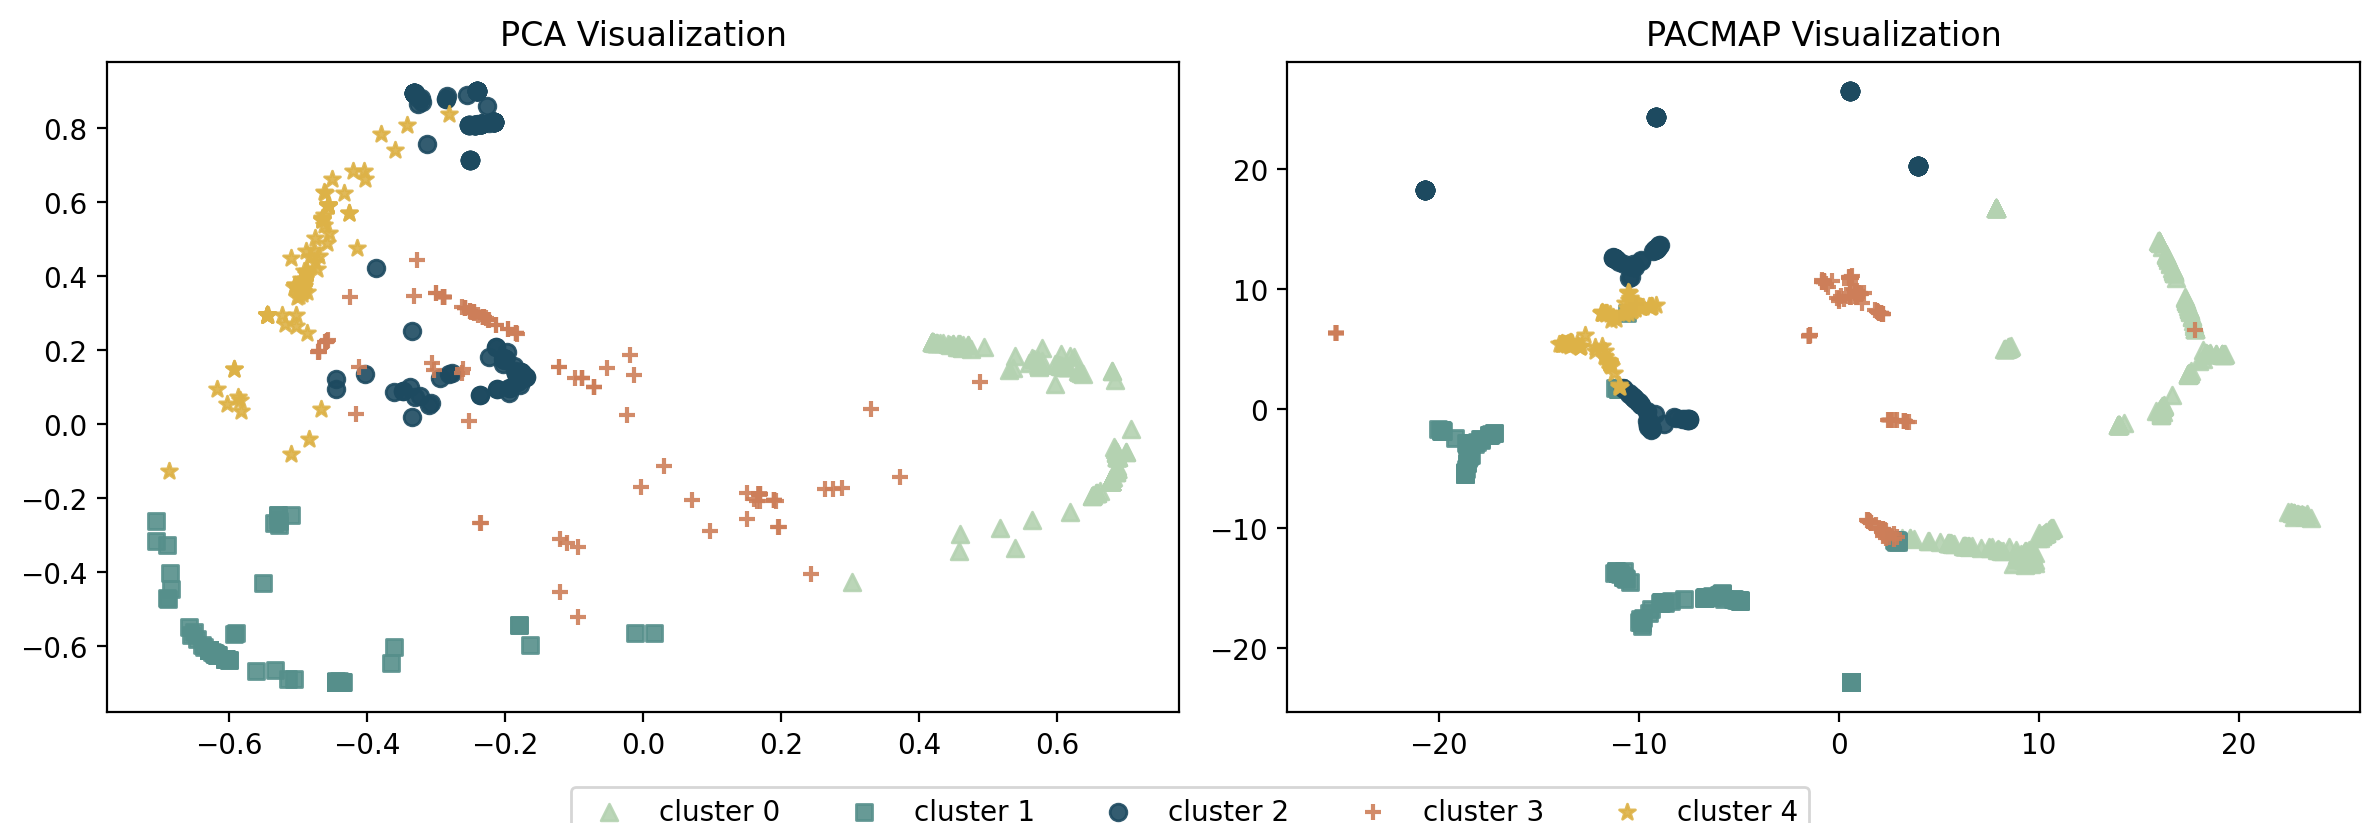

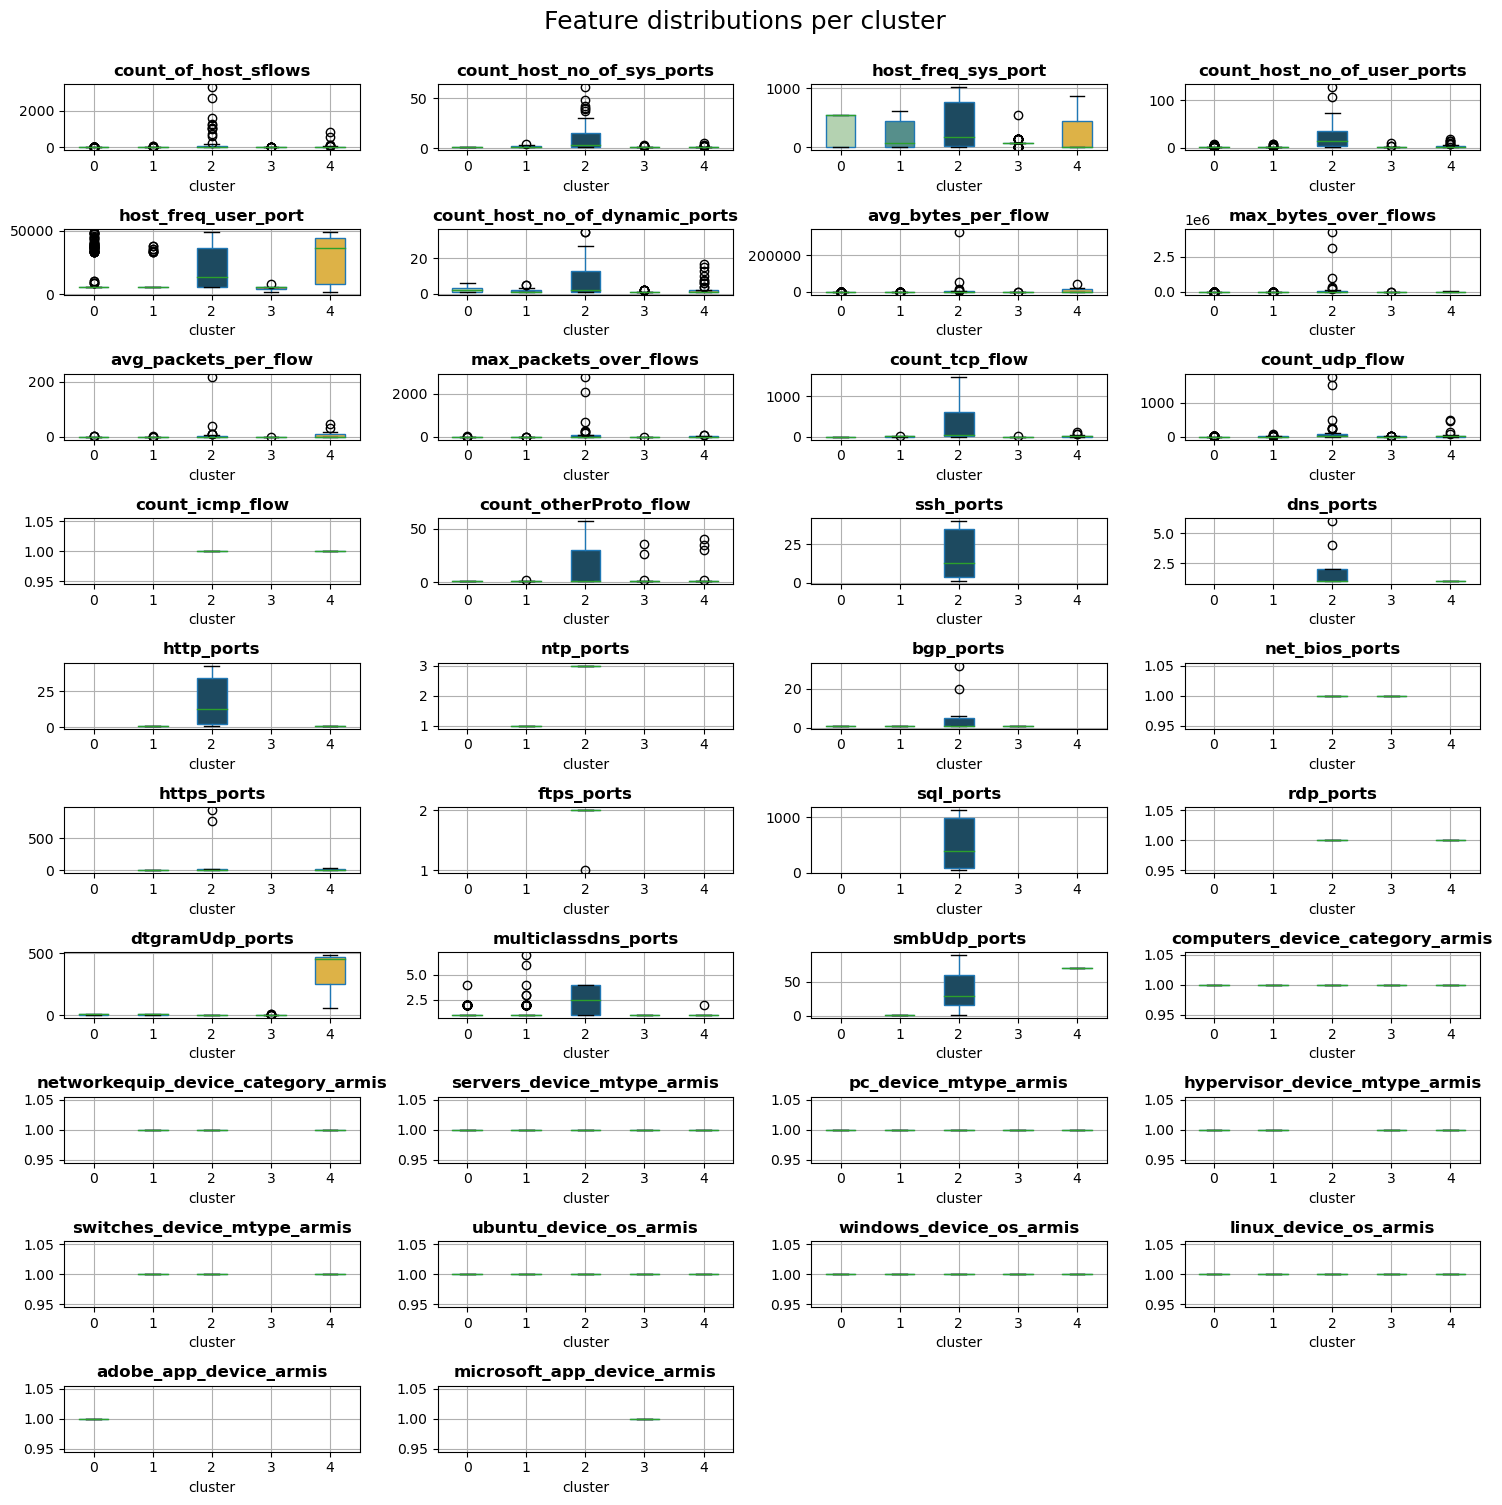

                                   0
cluster category                    
0       Computers          59.327217
1       Computers          50.793651
        Network Equipment   0.529101
2       Computers          10.389610
        Network Equipment   5.194805
3       Computers          35.507246
4       Computers          33.684211
        Network Equipment   5.263158
                                    0
cluster mtype                        
0       Hypervisor           1.529052
        Personal Computers   4.281346
        Servers             51.681957
1       Hypervisor           1.587302
        Personal Computers   2.645503
        Servers             40.211640
        Switches             0.529101
2       Personal Computers   2.597403
        Servers              7.792208
        Switches             5.194805
3       Hypervisor           2.173913
        Personal Computers   4.347826
        Servers             28.985507
4       Hypervisor           4.210526
        Personal Compu

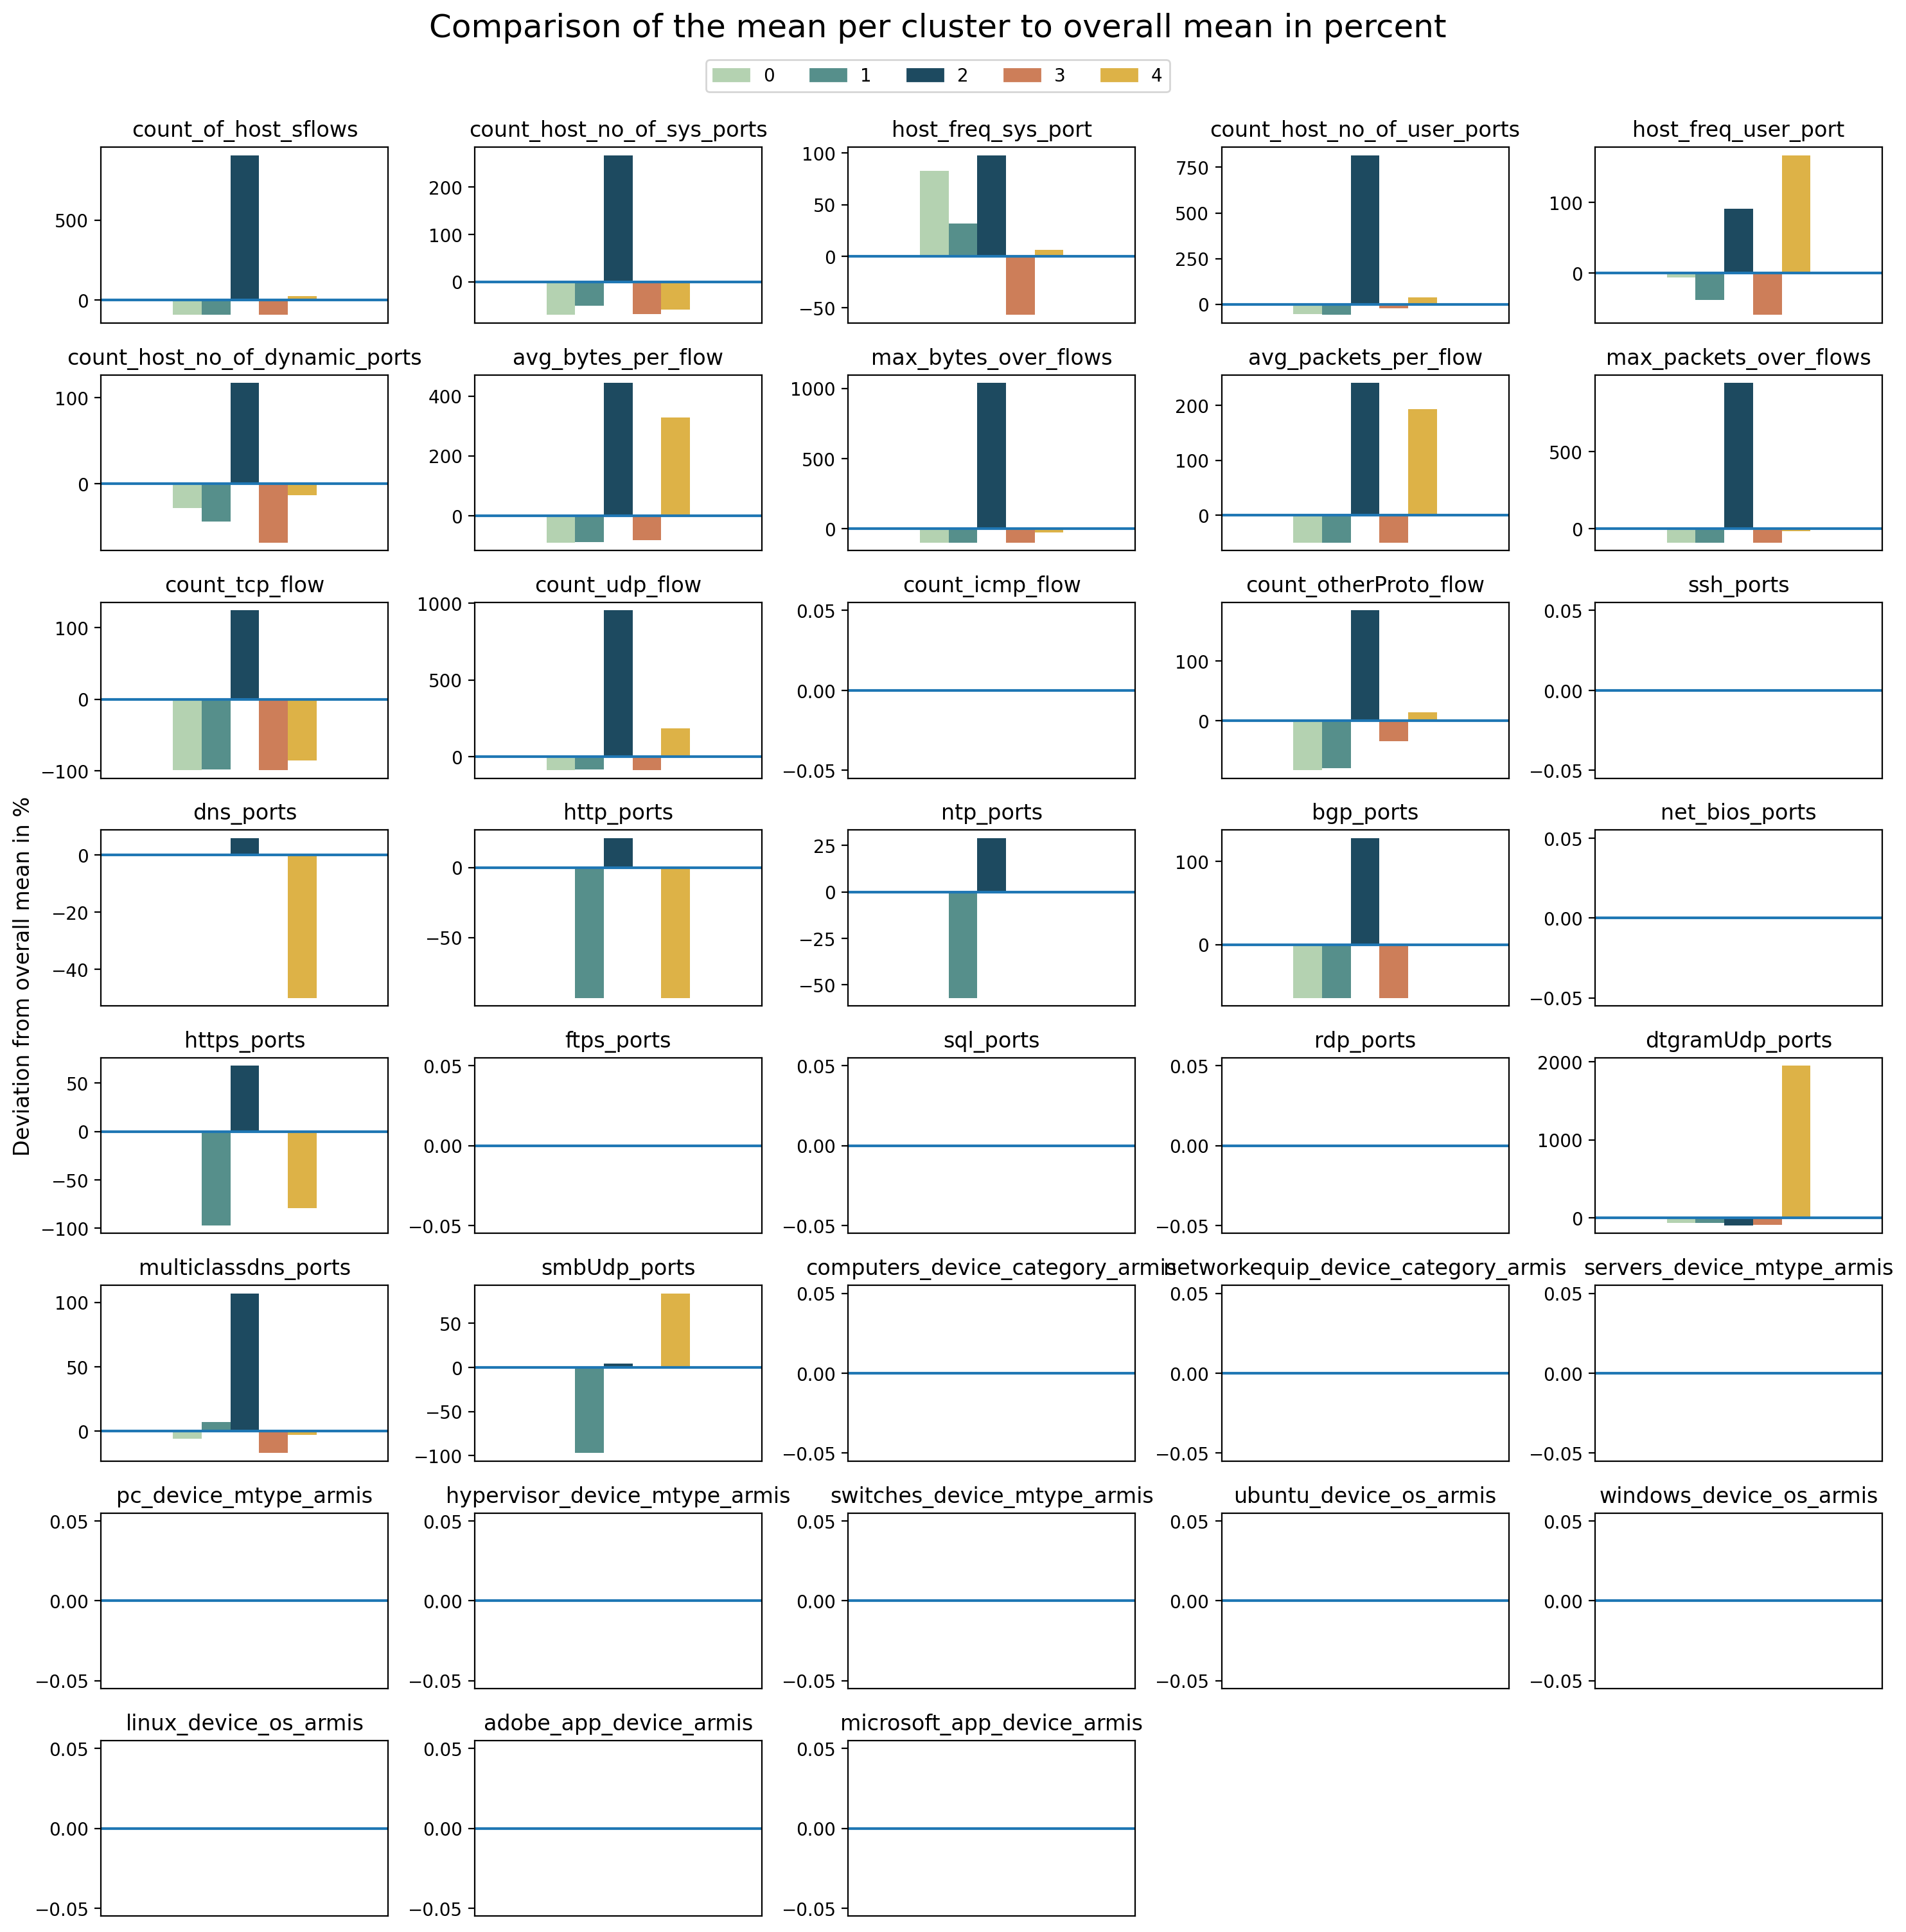

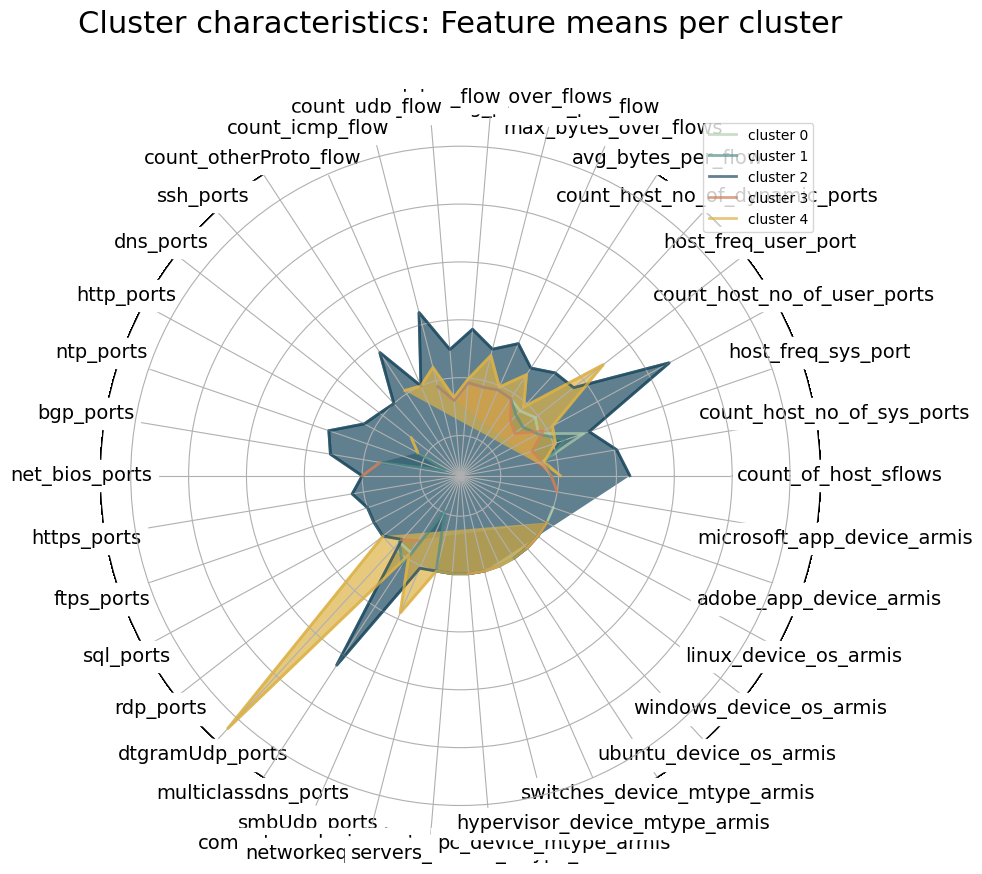

========== alpha=100, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.017023086547852
loss: 5.5554
loss: 5.2626
loss: 4.8789
loss: 4.6765
loss: 4.6528
loss: 4.6245
loss: 4.5149
loss: 4.4188
loss: 4.3176


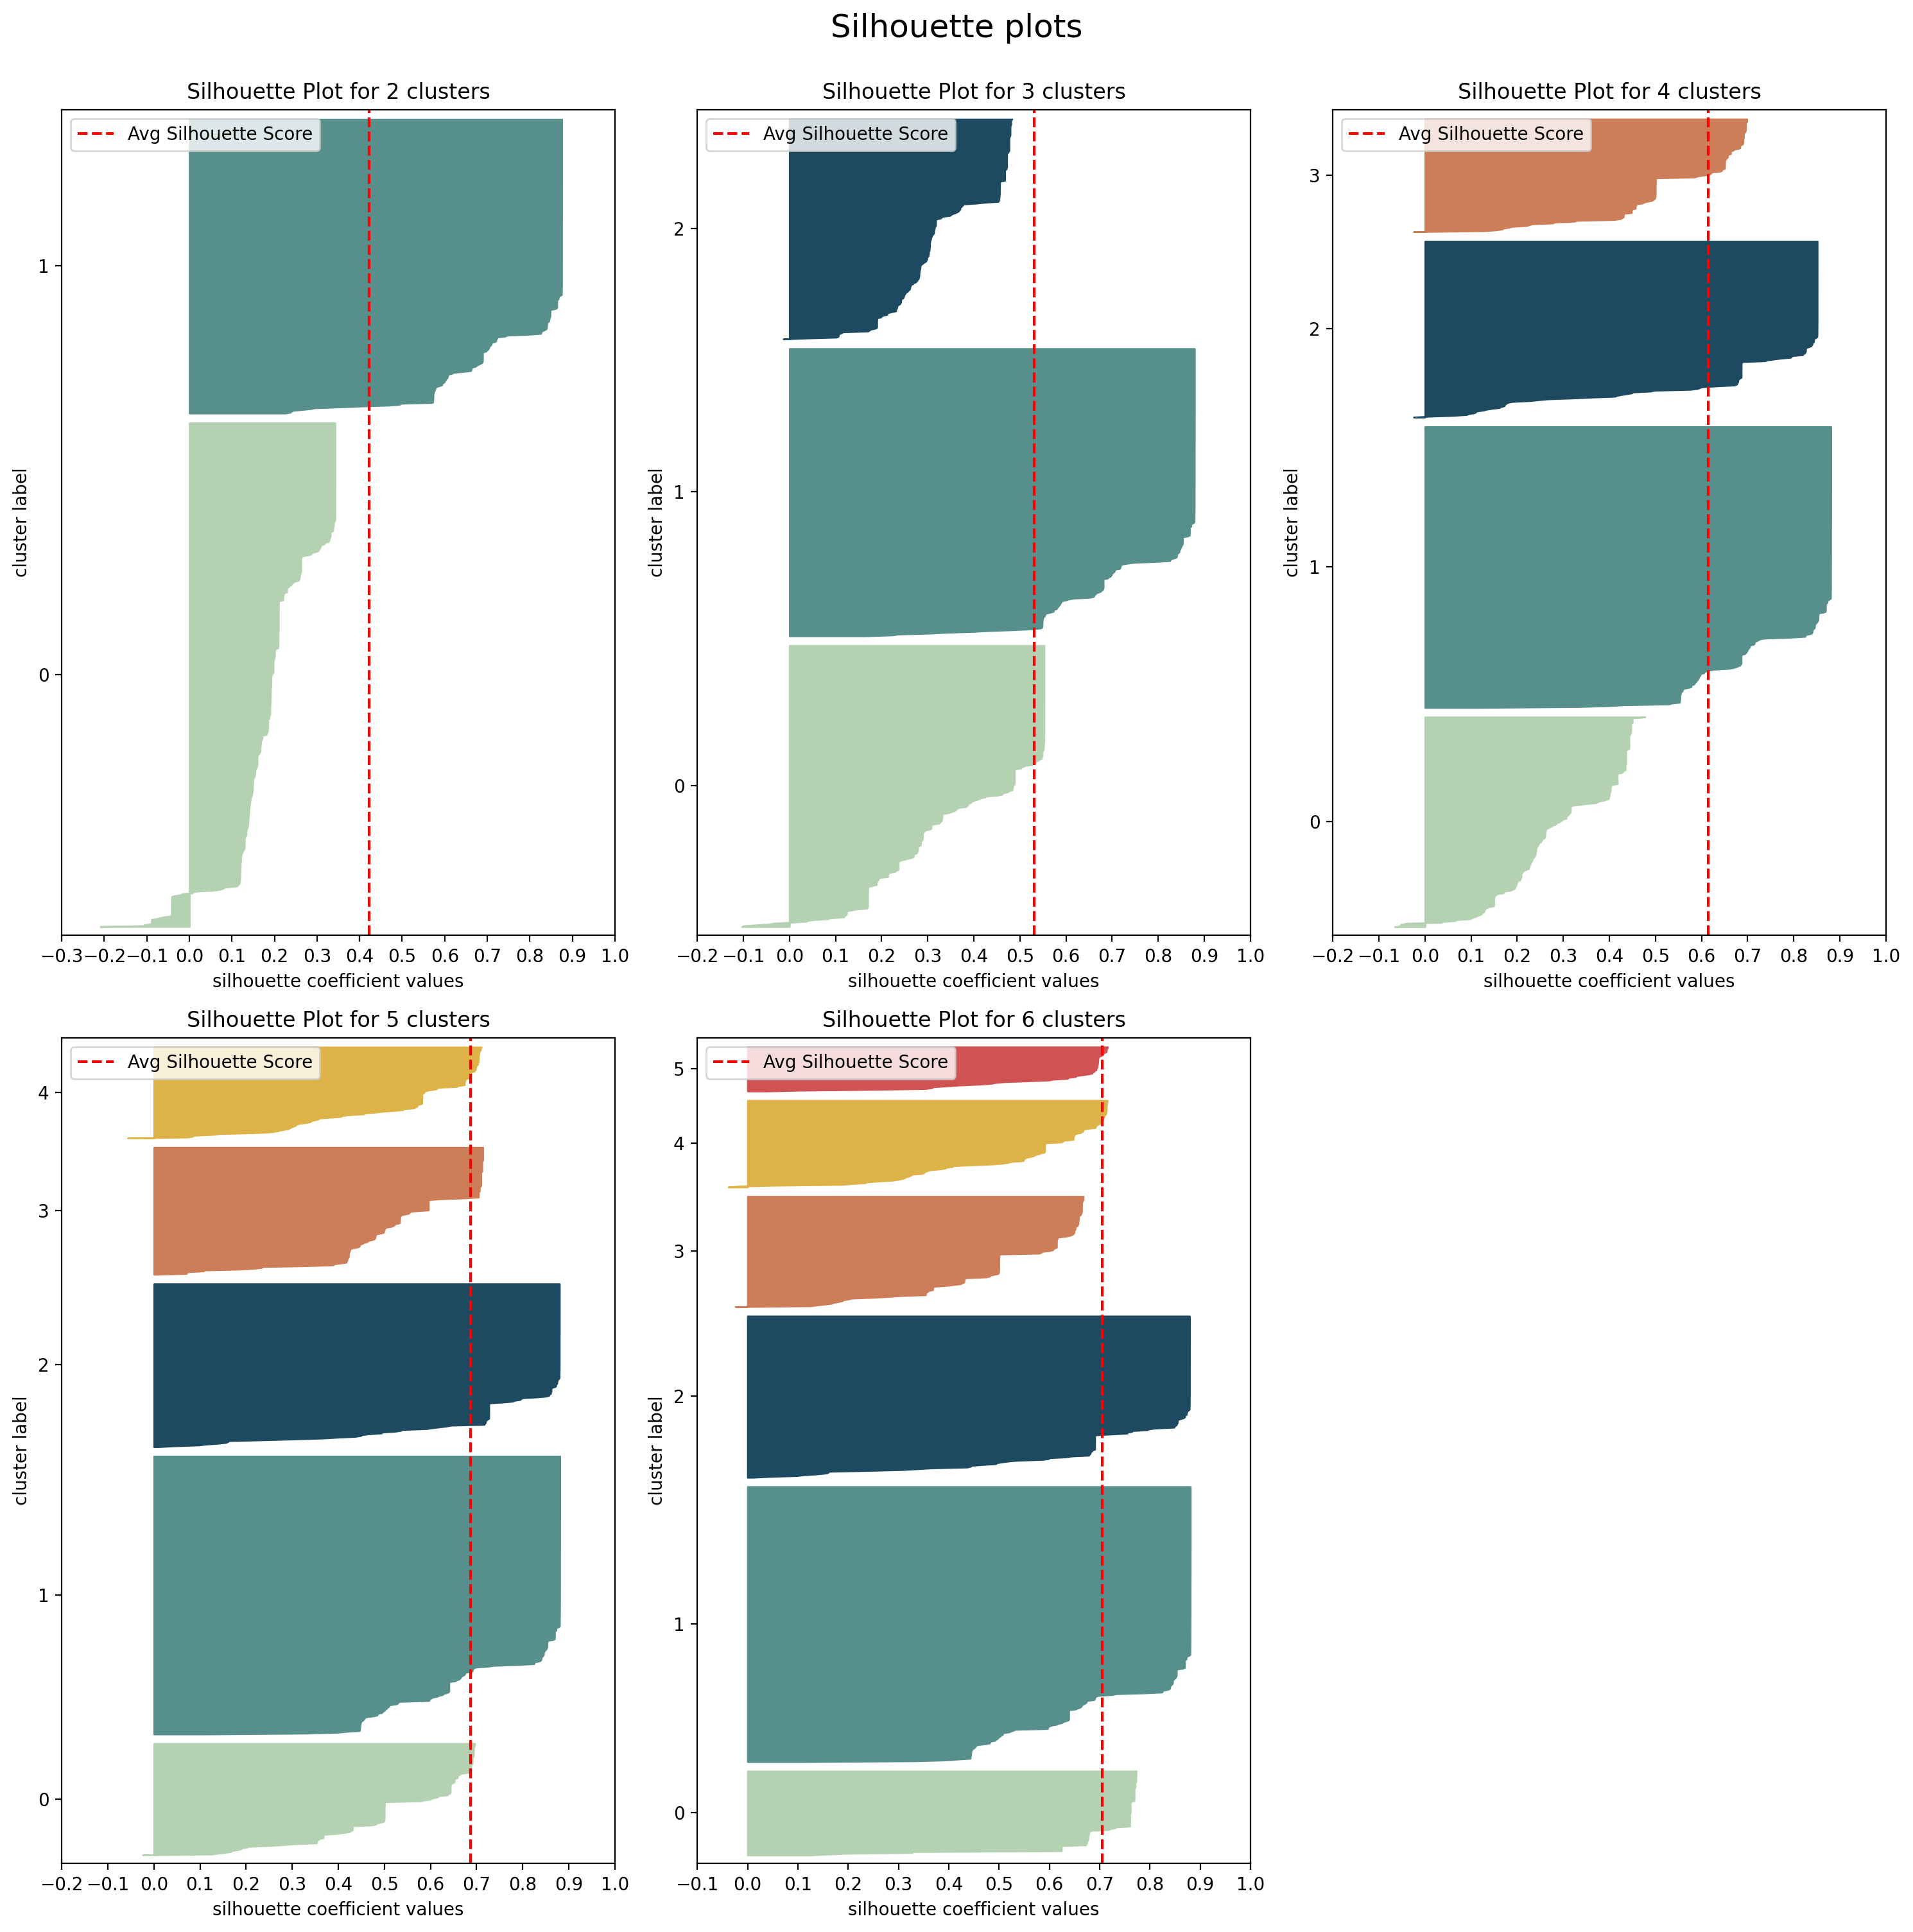

loss: 4.2023
========== reg=100 ==========


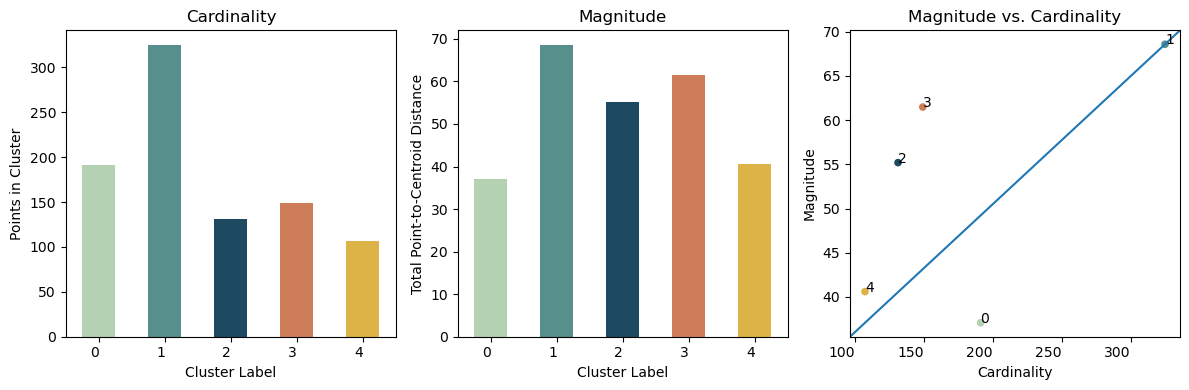

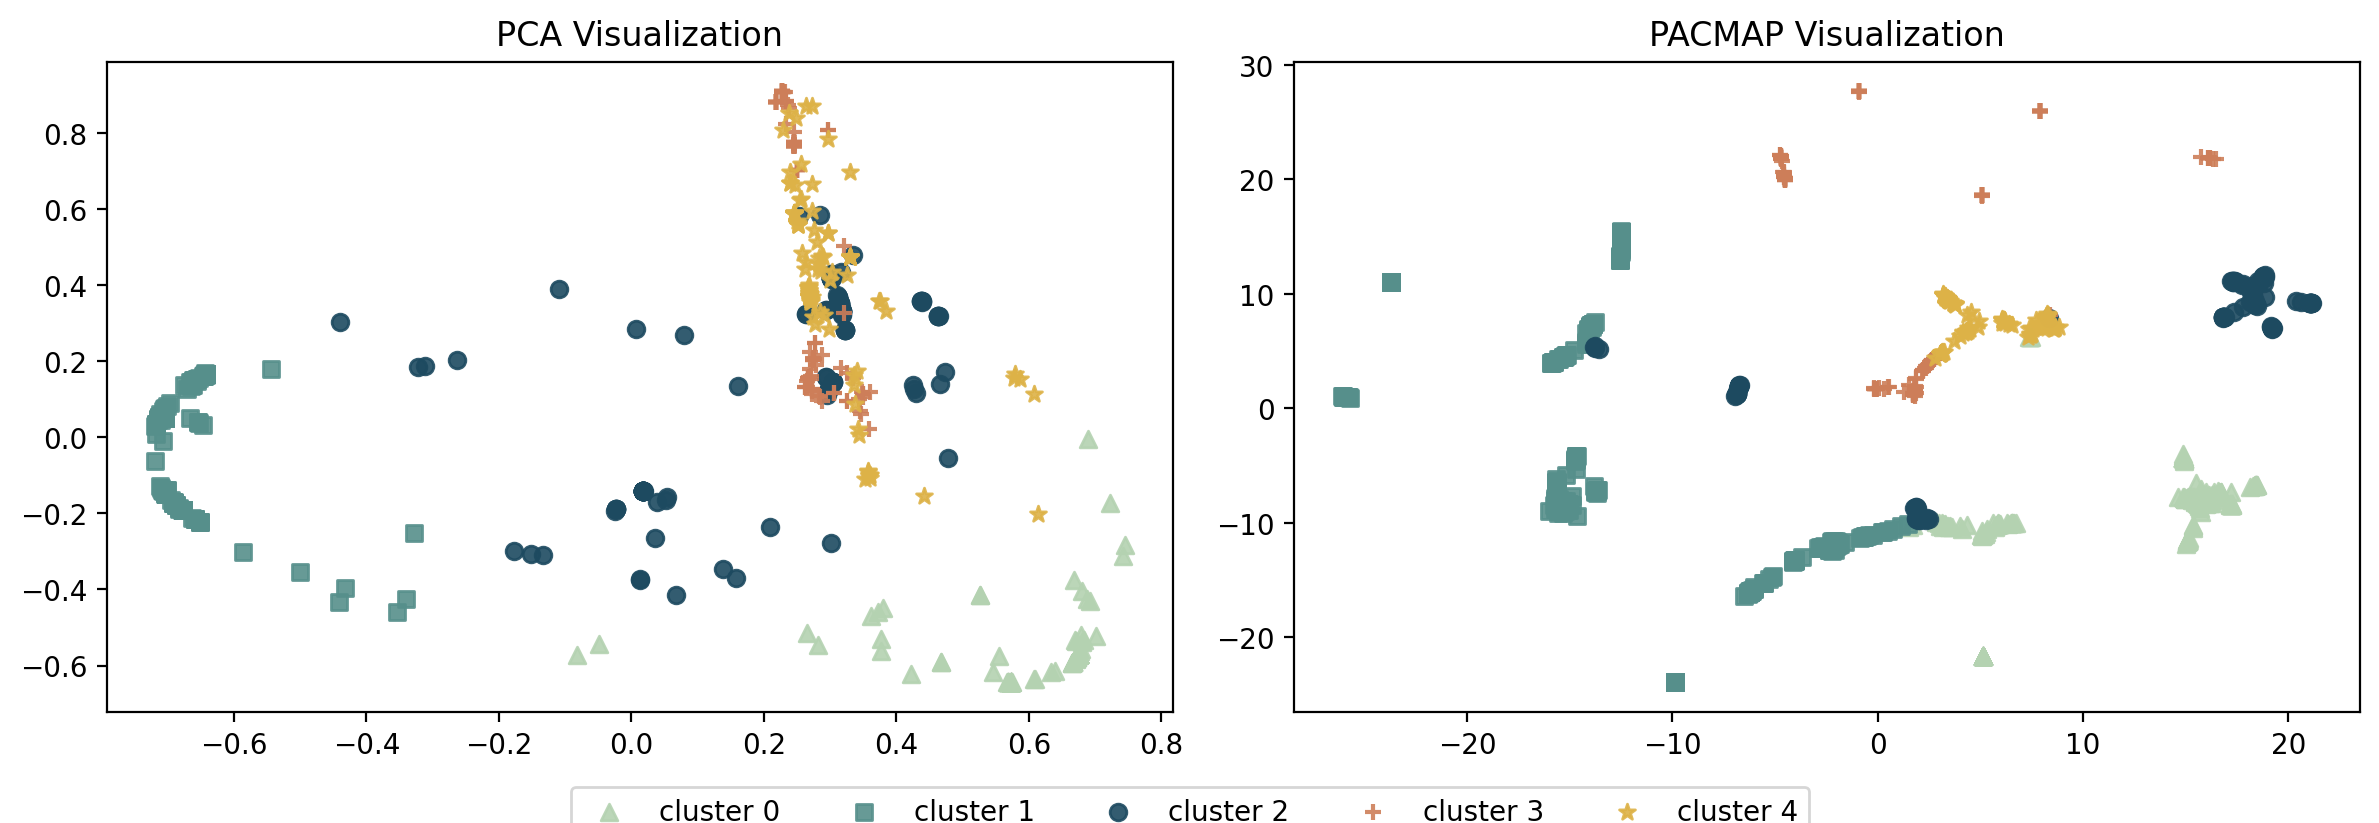

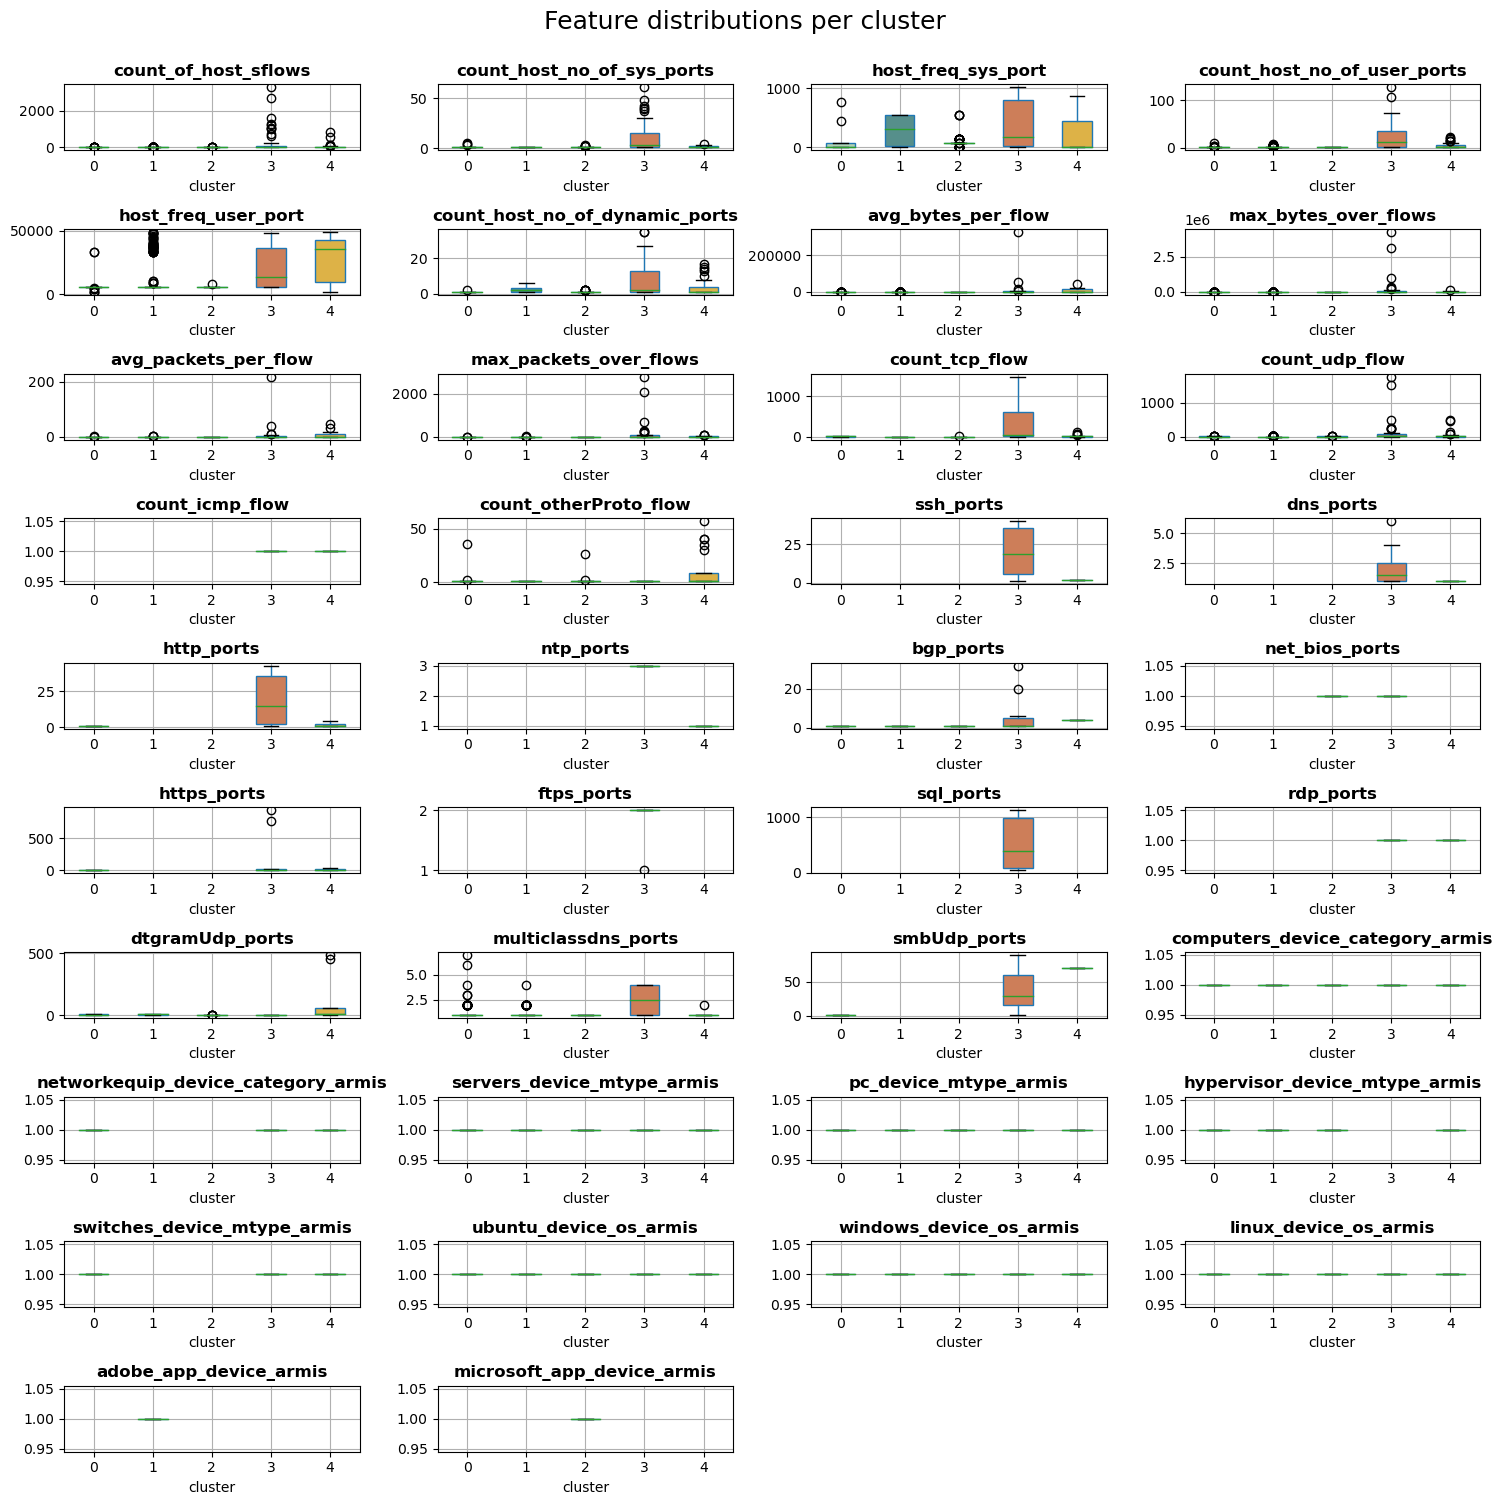

                                   0
cluster category                    
0       Computers          51.308901
        Network Equipment   1.047120
1       Computers          58.769231
2       Computers          38.167939
3       Computers          10.738255
        Network Equipment   5.369128
4       Computers          29.906542
        Network Equipment   3.738318
                                    0
cluster mtype                        
0       Hypervisor           1.570681
        Personal Computers   2.617801
        Servers             40.837696
        Switches             1.047120
1       Hypervisor           1.538462
        Personal Computers   4.307692
        Servers             51.076923
2       Hypervisor           2.290076
        Personal Computers   4.580153
        Servers             31.297710
3       Personal Computers   2.684564
        Servers              8.053691
        Switches             5.369128
4       Hypervisor           3.738318
        Personal Compu

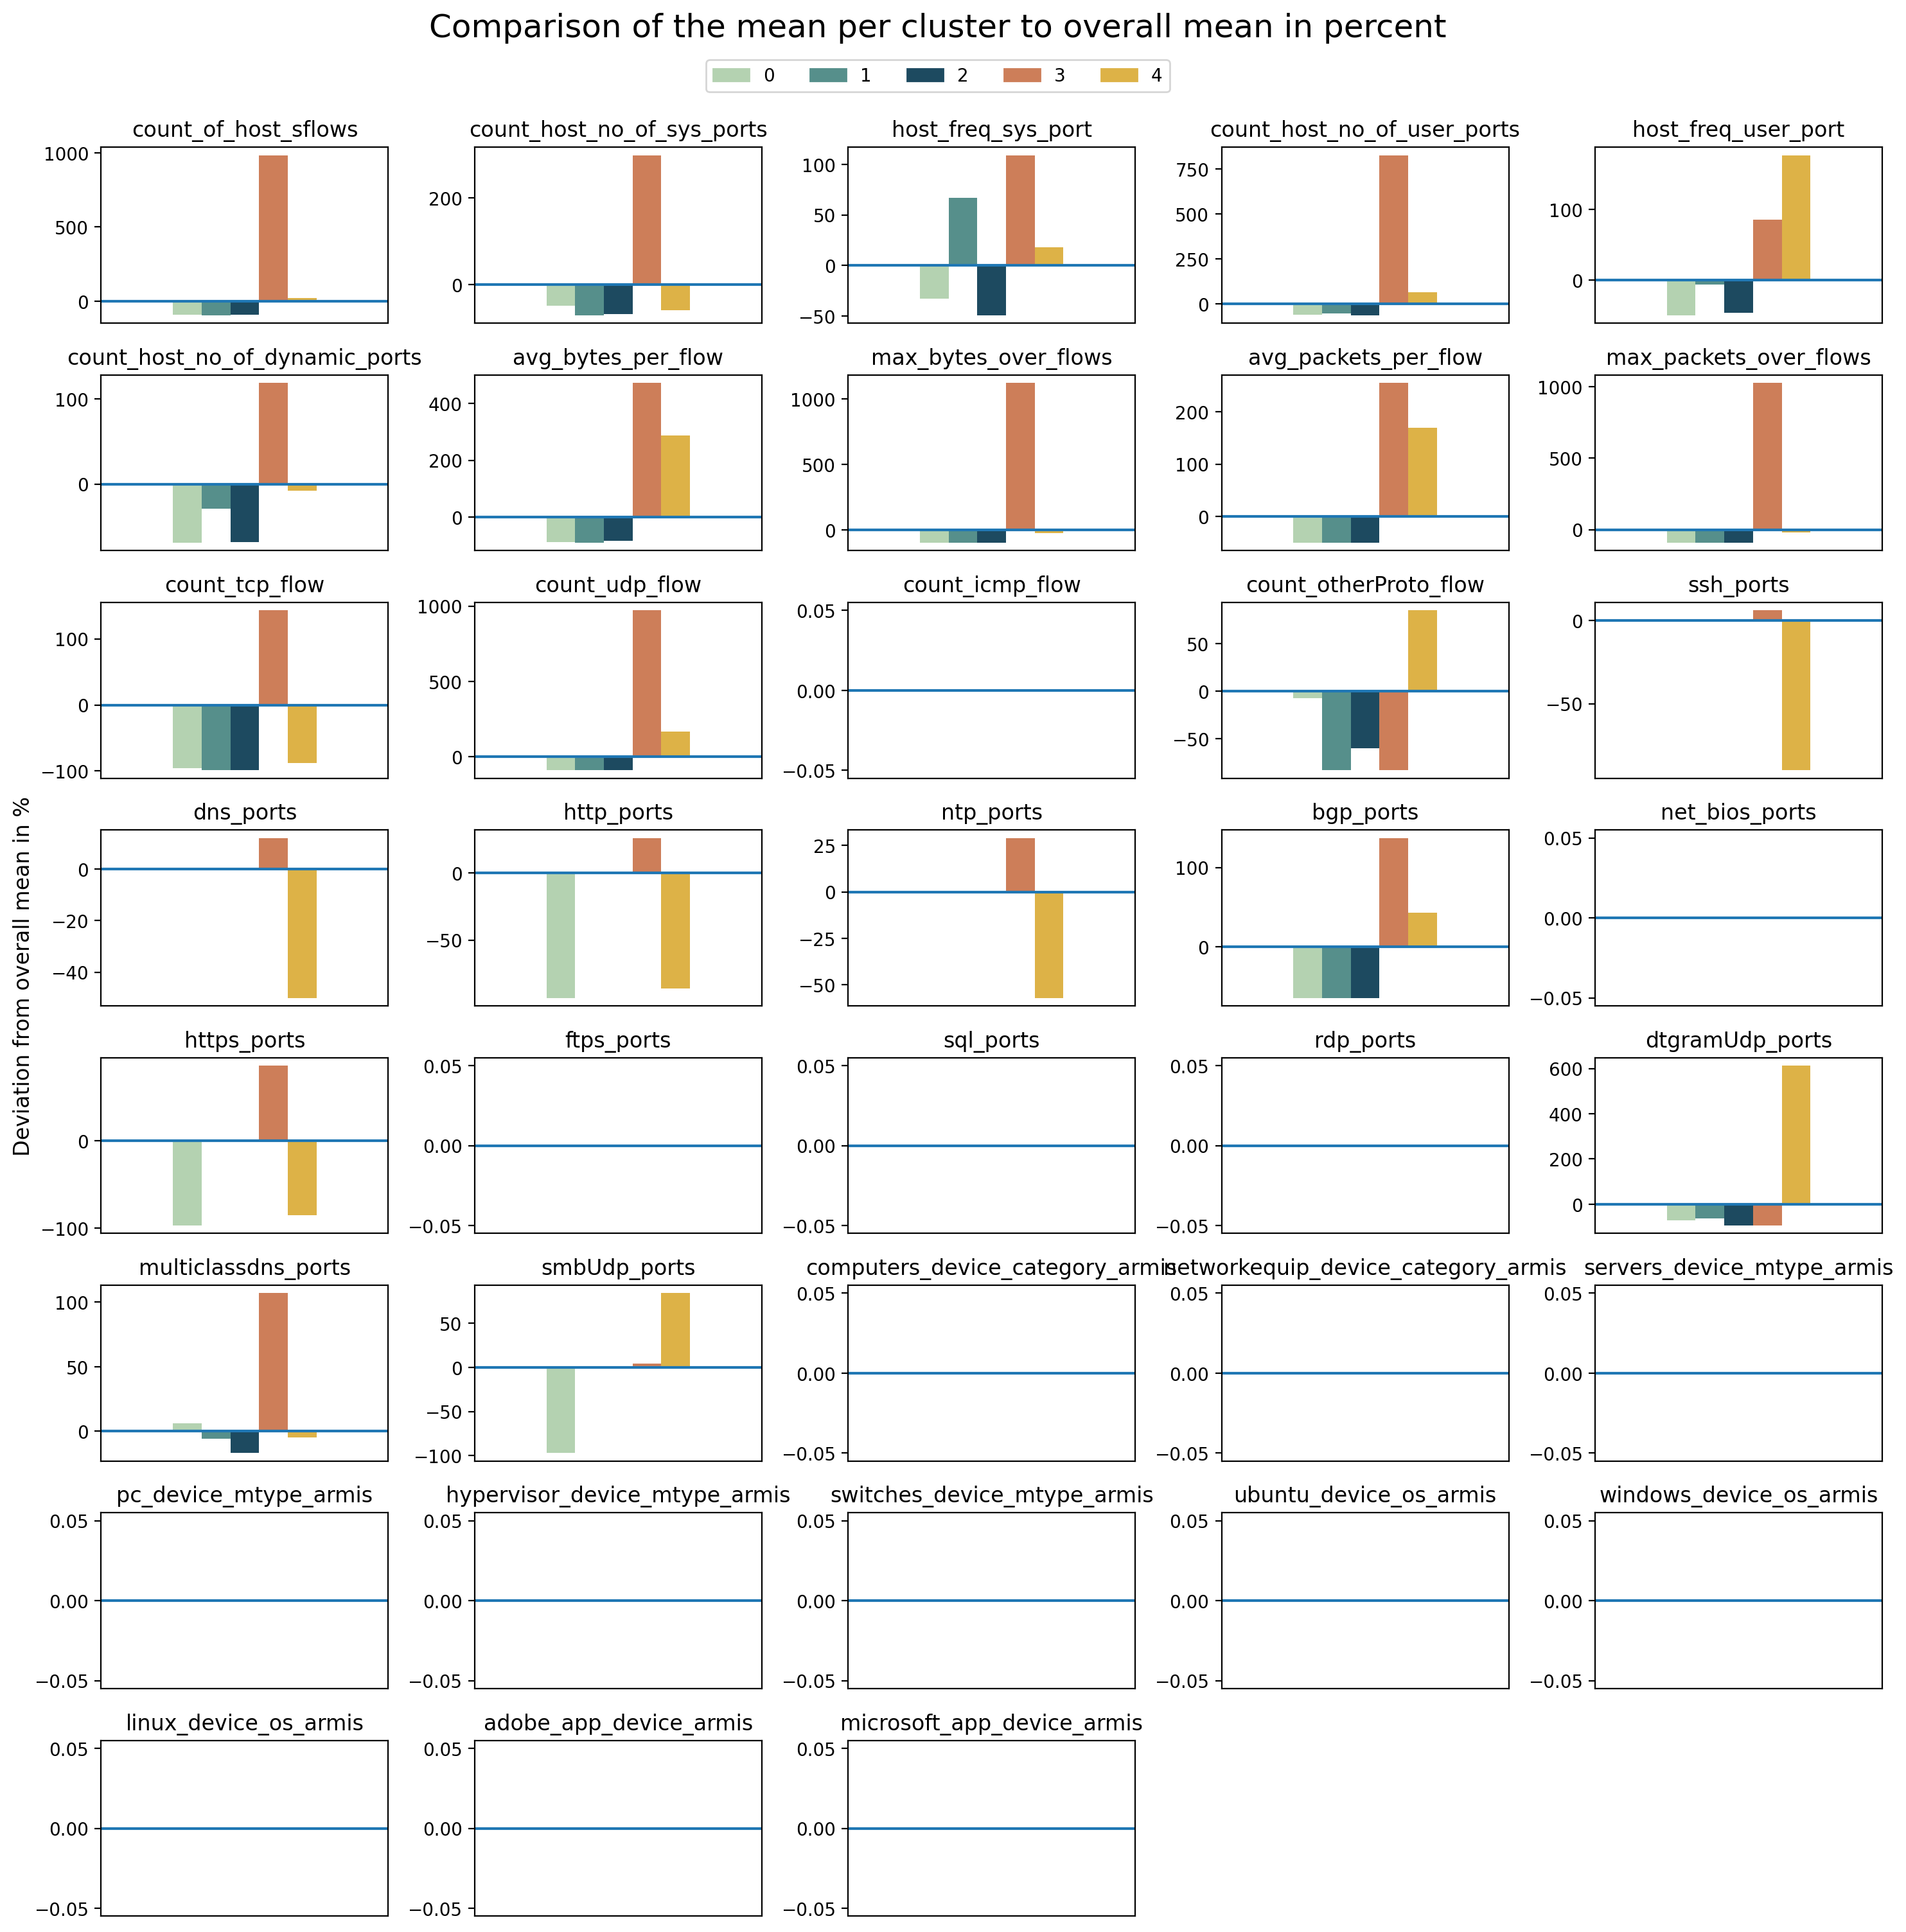

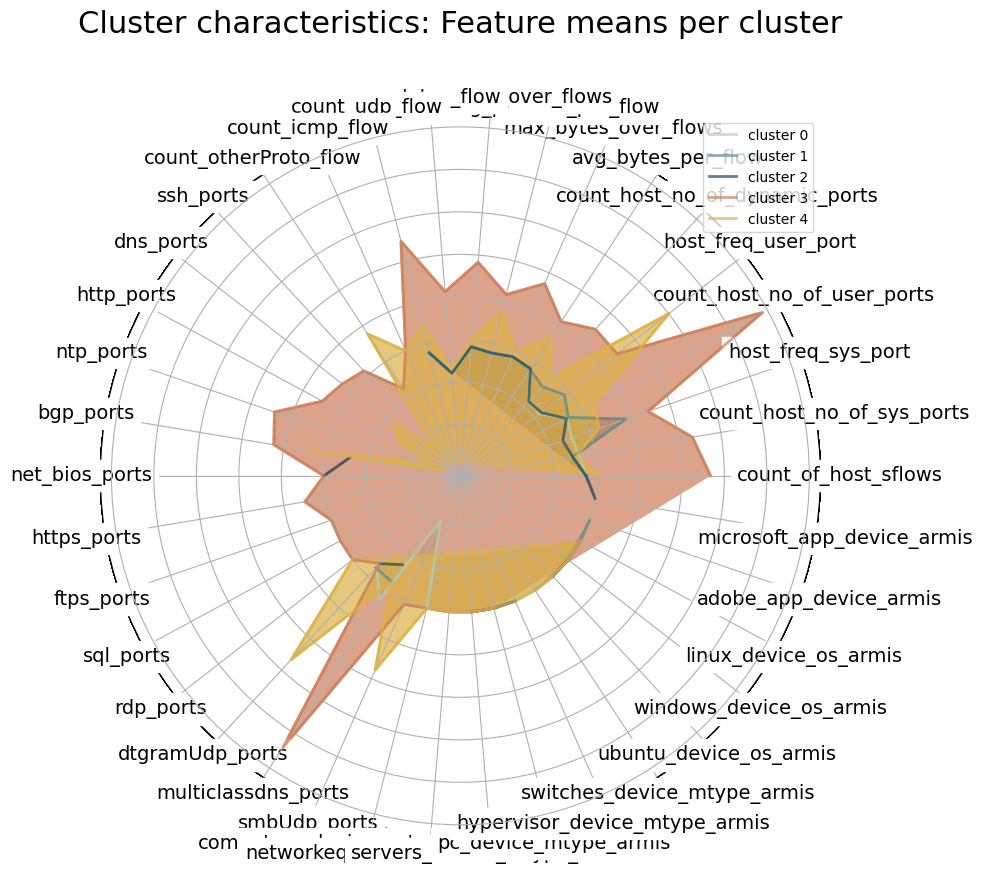

In [8]:

clust_dict = main_s()

### Next steps: 

1. Now that we have evaluated different clusering options, we select the one config where silhouette score is greater or equal than the threshold for all clusters.
2. Extract the updated embedding/indicator for each mac_id (node in the graph). This embedding encapsulates both features (per node) and its connections from the graph (using adjacency matrix)

In [9]:
#clust_dict[0.1]

emb = clust_dict[0.1]['X']
#type(emb)

copy_feat_df = feat_df.copy(deep=True)

emb_df = pd.DataFrame(emb, columns=['emb1','emb2','emb3','emb4','emb5'])
emb_df.shape

feature_emb_df = pd.concat([copy_feat_df, emb_df], axis=1)
feature_emb_df.shape

(903, 46)

In [10]:
feature_emb_df.head()

raw_mac  mac_id  count_of_host_sflows  \
0  0f:00:bc:ec:0e:85       0                   2.0   
1  83:23:21:b7:3f:ab       1                   1.0   
2  f2:0f:82:bd:34:48       2                   1.0   
3  53:04:53:d3:c9:5c       3                   1.0   
4  71:75:eb:77:36:f0       4                   1.0   

   count_host_no_of_sys_ports  host_freq_sys_port  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                         NaN                 NaN   
3                         NaN                 NaN   
4                         NaN                 NaN   

   count_host_no_of_user_ports  host_freq_user_port  \
0                          1.0               5353.0   
1                          1.0               8612.0   
2                          1.0               5353.0   
3                          1.0               5353.0   
4                          1.0               5353.0   

   count_host_no_of_dynamic_ports  avg_bytes_per_flow  max_bytes_over_flows  \
0                             1.0               114.5                 129.0   
1                             NaN                64.0                  64.0   
2                             NaN               149.0                 149.0   
3                             NaN               129.0                 129.0   
4                             NaN               149.0                 149.0   

   avg_packets_per_flow  max_packets_over_flows  count_tcp_flow  \
0                   1.0                     1.0             NaN   
1                   1.0                     1.0             NaN   
2                   1.0                     1.0             NaN   
3                   1.0                     1.0             NaN   
4                   1.0                     1.0             NaN   

   count_udp_flow  count_icmp_flow  count_otherProto_flow  ssh_ports  \
0             2.0              NaN                    NaN        NaN   
1             1.0              NaN                    NaN        NaN   
2             1.0              NaN                    NaN        NaN   
3             1.0              NaN                    NaN        NaN   
4             1.0              NaN                    NaN        NaN   

   dns_ports  http_ports  ntp_ports  bgp_ports  net_bios_ports  https_ports  \
0        NaN         NaN        NaN        NaN             NaN          NaN   
1        NaN         NaN        NaN        NaN             NaN          NaN   
2        NaN         NaN        NaN        NaN             NaN          NaN   
3        NaN         NaN        NaN        NaN             NaN          NaN   
4        NaN         NaN        NaN        NaN             NaN          NaN   

   ftps_ports  sql_ports  rdp_ports  dtgramUdp_ports  multiclassdns_ports  \
0         NaN        NaN        NaN              NaN                  1.0   
1         NaN        NaN        NaN              NaN                  NaN   
2         NaN        NaN        NaN              NaN                  1.0   
3         NaN        NaN        NaN              NaN                  1.0   
4         NaN        NaN        NaN              NaN                  1.0   

   smbUdp_ports  computers_device_category_armis  \
0           NaN                              NaN   
1           NaN                              NaN   
2           NaN                              NaN   
3           NaN                              NaN   
4           NaN                              1.0   

   networkequip_device_category_armis  servers_device_mtype_armis  \
0                                 NaN                         NaN   
1                                 NaN                         NaN   
2                                 NaN                         NaN   
3                                 NaN                         NaN   
4                                 NaN                         1.0   

   pc_device_mtype_armis  hypervisor_device_mtype_armis  \
0 

In [11]:
# Armis data has multiple devices linked to same mac, hence separating and getting them independently

for i in range(0, 5):
    armis_data_device['mac_address_' + str(i)] = None
temp_res = armis_data_device['mac_address'].apply(lambda x : x.split(','))
for index, row in armis_data_device.iterrows():
    for i in range(min(5, len(temp_res[index]))):
        armis_data_device.loc[index,'mac_address_' + str(i)] = temp_res[index][i]
armis_data_device.head()

mac_address   category  \
0  ed:00:72:91:55:4c  Computers   
1  25:c9:2a:3f:3a:6f  Computers   
2  db:32:80:d6:e9:cc  Computers   
3  2b:ac:3f:44:ef:1f  Computers   
4  ab:06:71:9e:ed:11  Computers   

                                      manufacturer  \
0                         Computers Manufacturer 7   
1  Computers and Network Equipment Manufacturer 14   
2  Computers and Network Equipment Manufacturer 14   
3  Computers and Network Equipment Manufacturer 14   
4                         Computers Manufacturer 3   

                                      model            name operatingSystem  \
0                         Computers Model 0  Computers 1709           Linux   
1                         Computers Model 1  Computers 1298          Ubuntu   
2  Computers and Network Equipment Model 28   Computers 754             NaN   
3                         Computers Model 1  Computers 1311          Ubuntu   
4                         Computers Model 4   Computers 669         Windows   

  operatingSystemVersion  riskLevel               mtype      mac_address_0  \
0                    NaN          6             Servers  ed:00:72:91:55:4c   
1                  18.04          4             Servers  25:c9:2a:3f:3a:6f   
2                    NaN          1             Servers  db:32:80:d6:e9:cc   
3                  18.04          4             Servers  2b:ac:3f:44:ef:1f   
4            Server 2022          7  Personal Computers  ab:06:71:9e:ed:11   

  mac_address_1 mac_address_2 mac_address_3 mac_address_4  
0          None          None          None          None  
1          None          None          None          None  
2          None          None          None          None  
3          None          None          None          None  
4          None          None          None          None

### Mapping feature dataframe with category, mtype, manufacturer, device name and risklevel information from armis

In [12]:
feat_df['category'] = None
feat_df['mtype'] = None
feat_df['manufacturer'] = None
feat_df['name'] = None
feat_df['riskLevel'] = None

for index, row in feat_df.iterrows():
    mac = row['raw_mac']
    match_row = armis_data_device.loc[(armis_data_device.mac_address_0==mac) |
                                      (armis_data_device.mac_address_1==mac) |
                                      (armis_data_device.mac_address_2==mac) |
                                      (armis_data_device.mac_address_3==mac) |
                                      (armis_data_device.mac_address_4==mac)
                                     ]
    if match_row.shape[0]>0:
        feat_df.loc[index, 'category'] = match_row['category'].iloc[0]
        feat_df.loc[index, 'mtype'] = match_row['mtype'].iloc[0]
        feat_df.loc[index, 'manufacturer'] = match_row['manufacturer'].iloc[0]
        feat_df.loc[index, 'name'] = match_row['name'].iloc[0]
        feat_df.loc[index, 'riskLevel'] = match_row['riskLevel'].iloc[0]
    else:
        continue

### Cluster visualization


When armis returns no data, mark as unknown for Viz

In [13]:
feat_df['cluster'] = clust_dict[0.1]['predictions']
feat_df['category'].isnull().sum()
feat_df['category'].fillna(value='Unknown', inplace=True)

feat_df['name'].fillna(value='Unknown', inplace=True)


In [14]:
net = Network(filter_menu=True, notebook=True)
#net.toggle_physics(False)
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
attrs = {}
for raw_mac, mac_id in mac_dict.items():
    attrs[mac_id] = {
        #"name":raw_mac,
        "group":int(feat_df.loc[feat_df.mac_id==mac_id,'cluster'].iloc[0]),
        "label":feat_df.loc[feat_df.mac_id==mac_id,'category'].iloc[0],
        #"dev":feat_df.loc[feat_df.mac_id==mac_id,'mtype'].iloc[0],
        "title": feat_df.loc[feat_df.mac_id==mac_id,'name'].iloc[0],
        "color": cluster_colors[feat_df.loc[feat_df.mac_id==mac_id,'cluster'].iloc[0]]
    }
G_2 = G.copy()
nx.set_node_attributes(G_2, attrs)

### The networkX viz used in RSA and other presentations

In [15]:
net.from_nx(G_2)
net.show('ac_v3.html')

ac_v3.html


<font color=#b4d2b1>**Cluster 1**</font>, 
<font color='#568f8b'>**Cluster 2**</font>,
<font color=#1d4a60>**Cluster 3**</font>,
<font color=#cd7e59>**Cluster 4**</font>
and <font color=#ddb247>**Cluster 5**</font>.

### Use cases:

#### Inter group communication

In [16]:
sflow_raw.head(5)

SRC_MAC            DST_MAC           SRC_IP           DST_IP  \
0  88:67:e2:88:87:62  0d:81:34:59:a5:70  192.168.102.133      10.50.49.94   
1  14:08:ec:aa:7c:9d  1b:b5:67:2e:d1:fe    172.28.16.147    172.16.44.115   
2  d2:fe:1a:3d:54:2c  a6:15:ec:b8:af:c6    10.219.76.151   172.23.118.139   
3  88:67:e2:88:87:62  0d:81:34:59:a5:70   172.17.239.190      10.50.49.94   
4  51:f1:7e:33:d1:2c  16:87:ca:d2:3d:f8    172.22.69.109  192.168.207.169   

   SRC_PORT  DST_PORT PROTOCOL  SH_COUNTRY  DH_COUNTRY  SH_LAT  SH_LON  \
0       443     34170      tcp         NaN         NaN     0.0     0.0   
1      8182      8182      udp         NaN         NaN     0.0     0.0   
2     20530      4789      udp         NaN         NaN     0.0     0.0   
3       443     54300      tcp         NaN         NaN     0.0     0.0   
4      5434     53626      tcp         NaN         NaN     0.0     0.0   

   DH_LAT  DH_LON             TIMESTAMP_START  PACKETS  BYTES sflow_type  
0     0.0     0.0  0000-00-00 00:00:00.000000        1   1532    cumulus  
1     0.0     0.0  0000-00-00 00:00:00.000000        1    376    cumulus  
2     0.0     0.0  0000-00-00 00:00:00.000000        1   1582    cumulus  
3     0.0     0.0  0000-00-00 00:00:00.000000        1   1532    cumulus  
4     0.0     0.0  0000-00-00 00:00:00.000000        1    105    cumulus

In [17]:
# Use the mac to id mapping to populate src and mac id in sflow data
sflow_raw['src_mac_id'] = sflow_raw['SRC_MAC'].apply(lambda x : mac_dict[x])
sflow_raw['dst_mac_id'] = sflow_raw['DST_MAC'].apply(lambda x : mac_dict[x])

# Using the mac ID, populate the cluster information from model
sflow_raw['SRC_MAC_cluster'] = sflow_raw['src_mac_id'].apply(lambda x : feat_df.loc[feat_df.mac_id == x,'cluster'].iloc[0])
sflow_raw['DST_MAC_cluster'] = sflow_raw['dst_mac_id'].apply(lambda x : feat_df.loc[feat_df.mac_id == x,'cluster'].iloc[0])

In [18]:
inter_group = sflow_raw.loc[sflow_raw.SRC_MAC_cluster!=sflow_raw.DST_MAC_cluster]
inter_group.shape

(1724, 21)

In [19]:
inter_group.shape[0]*100/sflow_raw.shape[0]

8.620862086208621

### Key takeaway: Only 8.5% devices communicate with devices outside of their cluster

In [20]:
inter_group.shape[0]*100/sflow_raw.shape[0]

8.620862086208621

In [21]:
inter_group.sample()

SRC_MAC            DST_MAC  \
13073  db:4e:3e:78:00:b7  f6:61:0c:db:99:82   

                                        SRC_IP  \
13073  bfed:d754:a58d:c8ab:ef4b:6d92:2aad:8b28   

                                       DST_IP  SRC_PORT  DST_PORT   PROTOCOL  \
13073  eb69:ee11:ef50:966e:a875:f688:a92:40fd         0         0  ipv6-icmp   

       SH_COUNTRY  DH_COUNTRY  SH_LAT  SH_LON  DH_LAT  DH_LON  \
13073         NaN         NaN     0.0     0.0     0.0     0.0   

                  TIMESTAMP_START  PACKETS  BYTES sflow_type  src_mac_id  \
13073  0000-00-00 00:00:00.000000        1     90     arista         779   

       dst_mac_id  SRC_MAC_cluster  DST_MAC_cluster  
13073         186                4                1

### 5. Conclusion


A graph based clustering approach can offer several advantages over standard clustering approaches, especially when dealing with complex data that exhibit non-linear relationships and dependencies. Here are some reasons why a graph based asset clustering approach might be better:

**1. Incorporation of Complex Relationships**:
**Graph Representation**: Graph encoder-based methods can capture intricate relationships between data points, considering both local and global connectivity patterns. This is crucial for data where simple distance-based metrics might not effectively capture underlying structures.

**2. Non-Linearity Handling**:
**Non-Linear Relationships**: Graph encoders, often coupled with graph neural networks (GNNs), can model non-linear relationships effectively. This is particularly useful when data clusters are defined by complex non-linear interactions.

**3. Graph Topology Utilization**:
**Leveraging Graph Structure**: These methods explicitly utilize the graph topology, which might include information about similarity, affinity, or hierarchy among data points. This can improve the clustering by incorporating domain-specific information.

**4. Robustness to Noise and Outliers**:
**Robustness**: Graph encoders can inherently handle noisy data and outliers, as the graph structure smooths out the influence of noisy neighbors. This can lead to more stable and meaningful cluster assignments.

**5. Hierarchical Clustering**:
**Hierarchical Relationships**: Graph-based approaches can naturally handle hierarchical clustering, where data points are grouped at different levels of granularity based on the graph structure.

**6. Feature Learning and Representation**:
**Learned Representations**: Graph encoder-based methods simultaneously learn meaningful feature representations and cluster assignments. This can lead to more informative features that capture underlying characteristics.

**7. Semi-Supervised and Few-Shot Clustering**:
**Semi-Supervised Learning**: Graph encoders can incorporate labeled data or constraints in a semi-supervised manner, which can be especially valuable when a limited amount of labeled information is available.

**8. Community Detection and Overlapping Clusters**:
**Overlapping Clusters**: Graph-based methods naturally handle scenarios where data points can belong to multiple clusters or communities, which might be challenging for traditional clustering techniques.

**9. Transfer Learning and Adaptation**:
**Transfer Learning**: Pre-trained graph encoders can be fine-tuned or adapted to new datasets, making them useful for transfer learning in clustering tasks.


### Reference
[1]. H. Zhang, P. Li, R. Zhang and X. Li, "Embedding Graph Auto-Encoder for Graph Clustering," in IEEE Transactions on Neural Networks and Learning Systems, doi: 10.1109/TNNLS.2022.3158654.